In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

import random

import optuna

warnings.filterwarnings('ignore')

In [14]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = text.replace('machine learning', 'machinelearning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X


class Optimize_by_Optuna:
    def __init__(self, data, features, target_colname, target_name_2=None, _objective=None):
        self.data = data
        self.features = features
        self.target = target_colname
        if not target_colname:
            self.target_2 = target_colname
        else:
            self.target_2 = target_name_2
        self._objective = _objective
        
    
    def make_score(self, y, preds):
        s_1=1 - metrics.accuracy_score(y, preds)
        s_2=list(self.model.best_score['valid_1'].values())[0]

        return (s_1+s_2)/2

    def objective(self, trial):
                        
        PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
        

            'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.1, 1.8),


            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'subsample': trial.suggest_uniform('subsample', 0.4, 0.9),
            'subsample_freq': trial.suggest_uniform('subsample_freq', 0.4, 0.9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 4, 2*5),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.0001, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.0001, 10.0),
        }
        
        score = 0
        k = StratifiedKFold(n_splits=5)
        for trn, val in k.split(self.data, self.data[self.target_2]):
            train_df = self.data.iloc[trn,:]
            val_df = self.data.iloc[val,:]
            train_set= lgb.Dataset(train_df[self.features],  train_df[self.target])
            val_set = lgb.Dataset(val_df[self.features],  val_df[self.target])   
            
            self.model = lgb.train(
                train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
                early_stopping_rounds=200, verbose_eval=500
                )
                
            preds = self.model.predict(val_df[self.features])
            preds = np.round(preds)
            y = val_df[self.target]
            s = self.make_score(y, preds)
            score+=s/5
            
        return score


class Null_Importance:
    def __init__(self, train_X, train_y, PARAMS, y_2=None):
        self.train_X = train_X
        self.train_y = train_y
        self.y_2= y_2
        self.PARAMS = PARAMS

    def make_null_importance_df(self):
        null_importance=pd.DataFrame()
        null_importance['col'] = self.train_X.columns.tolist()
        try:
            for i in range(50):
                tmp_null_importance=[]
                
                _train_y = self.train_y.apply(lambda x: random.choice([0,1]))
                _train_y_2 = self.y_2.sample(frac=1).values
                
                print(f"""
                
                Train Null Importance   {i+1}
                
                """ )
                k = StratifiedKFold(n_splits=5)
                for trn, val in k.split(self.train_X, _train_y_2):
                    trn_X, val_X = self.train_X.iloc[trn,:], self.train_X.iloc[val,:]
                    trn_y, val_y = _train_y.iloc[trn].astype(int), _train_y.iloc[val].astype(int)
                    train_set = lgb.Dataset(trn_X, trn_y)
                    val_set = lgb.Dataset(val_X, val_y)

                    model = lgb.train(params=self.PARAMS,
                                      train_set=train_set, 
                                      valid_sets=[train_set, val_set],
                                    num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
                    
                    preds = model.predict(val_X)
                    tmp_null_importance.append(model.feature_importance('gain'))
                null_importance[f'null_importance_{i+1}'] = np.mean(tmp_null_importance, axis=0)
            return null_importance
        except:
            return null_importance

    def calu_importance(self, importance_df, null_importance_df):
        importance_df = pd.merge(
            importance_df, null_importance_df, on='col'
            )
        null_importance_col = [col for col in importance_df.columns if 'null' in col]
        null_importance=pd.DataFrame()
        for idx, row in importance_df.iterrows():
            acc_v = 1e-10+row['true_importance']
            null_v = 1+np.percentile(row[null_importance_col], 75)
            null_importance[row['col']] = [np.log(acc_v/null_v)]
        null_importance = null_importance.T
        return null_importance

    def all_flow(self):
        k = StratifiedKFold(n_splits=5)
        score=[]
        importance=[]

        importance_df=pd.DataFrame()
        importance_df['col'] = self.train_X.columns
        print("""
        
        Train True Importance
        
        """ )
        for trn, val in k.split(self.train_X, self.y_2):
            trn_X, val_X = self.train_X.iloc[trn,:], self.train_X.iloc[val,:]
            trn_y, val_y = self.train_y.iloc[trn].astype(int), self.train_y.iloc[val].astype(int)
            train_set = lgb.Dataset(trn_X, trn_y)
            val_set = lgb.Dataset(val_X, val_y)
            
            PARAMS['random_state']+=1
            model = lgb.train(params=self.PARAMS, train_set=train_set, valid_sets=[train_set, val_set],
                            num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
            preds = model.predict(val_X)
            importance.append(model.feature_importance('gain'))
        importance_df['true_importance'] = np.mean(importance, axis=0)
        
        print("""
        
        Train Null Importance
        
        """ )
        try:
            null_importance_df = self.make_null_importance_df()
        except:
            pass
        print("""
        
        Calulate null_null_importance
        
        """ )
        null_importance = self.calu_importance(importance_df, null_importance_df)
        null_importance = null_importance.reset_index()
        null_importance.columns = ['col', 'score']
        null_importance = null_importance.sort_values('score', ascending=False)
        return null_importance

In [6]:
df = pd.concat([
    pd.read_csv('train.csv'),
    pd.read_csv('test.csv')],
    axis=0,ignore_index=True)
preprocessing = Preprocessing()
df.description = df.description.apply(lambda x: preprocessing.change_text(x))

In [8]:
X = preprocessing.vectorize_cnt(df)
X = pd.concat([df.jobflag, X], axis=1)
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

### label 2

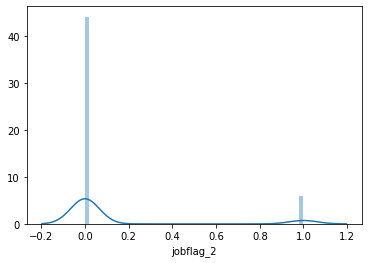

In [9]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==2 else 0)
sns.distplot(train_df.jobflag_2)

In [10]:
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
optimize_optuna = Optimize_by_Optuna(data=train_df, features=feature,target_colname= 'jobflag_2',target_name_2= 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[234]	training's tweedie: 1.17191	valid_1's tweedie: 1.18086
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.17029	valid_1's tweedie: 1.17893
Early stopping, best iteration is:
[440]	training's tweedie: 1.17115	valid_1's tweedie: 1.17743
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.16556	valid_1's tweedie: 1.17804
Early stopping, best iteration is:
[644]	training's tweedie: 1.16131	valid_1's tweedie: 1.17587
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.1665	valid_1's tweedie: 1.18842
Early stopping, best iteration is:
[314]	training's tweedie: 1.16991	valid_1's tweedie: 1.18462
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	training's tweedie: 1.17968	valid_1's tweedie: 1.18394


[I 2020-08-19 20:49:00,995] Finished trial#0 with value: 0.6498077896634735 with parameters: {'tweedie_variance_power': 1.1726046506137489, 'max_bin': 54, 'subsample': 0.41511787619636814, 'subsample_freq': 0.6380789603398381, 'learning_rate': 0.038228794391383825, 'num_leaves': 9, 'feature_fraction': 0.9395349350842735, 'bagging_freq': 2, 'min_child_samples': 78, 'lambda_l1': 0.0009296518319667738, 'lambda_l2': 0.010014307614086794}. Best is trial#0 with value: 0.6498077896634735.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.11925	valid_1's tweedie: 1.16738
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.07387	valid_1's tweedie: 1.16809
Early stopping, best iteration is:
[354]	training's tweedie: 1.08898	valid_1's tweedie: 1.12913
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[289]	training's tweedie: 1.09347	valid_1's tweedie: 1.14661
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.14939	valid_1's tweedie: 1.17594
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.13292	valid_1's tweedie: 1.14462


[I 2020-08-19 20:49:08,836] Finished trial#1 with value: 0.6343674308928661 with parameters: {'tweedie_variance_power': 1.4498522345622447, 'max_bin': 182, 'subsample': 0.4269963135834173, 'subsample_freq': 0.5984423496516414, 'learning_rate': 0.051997589657533545, 'num_leaves': 7, 'feature_fraction': 0.9626597713676959, 'bagging_freq': 6, 'min_child_samples': 51, 'lambda_l1': 0.00249107093388623, 'lambda_l2': 0.010950162749282575}. Best is trial#1 with value: 0.6343674308928661.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.02156	valid_1's tweedie: 1.05164
Early stopping, best iteration is:
[378]	training's tweedie: 1.02509	valid_1's tweedie: 1.04901
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's tweedie: 1.63647	valid_1's tweedie: 1.63855
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.71752	valid_1's tweedie: 1.72029
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[272]	training's tweedie: 1.02797	valid_1's tweedie: 1.05518
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.02686	valid_1's tweedie: 1.05526
Early stopping, best iteration is:
[612]	training's tweedie: 1.02426	valid_1's tweedie: 1.05451


[I 2020-08-19 20:49:16,772] Finished trial#2 with value: 0.8629061861714511 with parameters: {'tweedie_variance_power': 1.2522831195916373, 'max_bin': 74, 'subsample': 0.44931634977567114, 'subsample_freq': 0.8711122817321353, 'learning_rate': 0.09595344230431359, 'num_leaves': 8, 'feature_fraction': 0.8575157738510393, 'bagging_freq': 1, 'min_child_samples': 81, 'lambda_l1': 0.0035582749013964112, 'lambda_l2': 2.6065807120536597}. Best is trial#1 with value: 0.6343674308928661.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.05553	valid_1's tweedie: 1.16152
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.04845	valid_1's tweedie: 1.10922
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.09582	valid_1's tweedie: 1.15734
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.09607	valid_1's tweedie: 1.18216
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.12361	valid_1's tweedie: 1.15341


[I 2020-08-19 20:49:24,630] Finished trial#3 with value: 0.6347075805005274 with parameters: {'tweedie_variance_power': 1.4644913995470672, 'max_bin': 219, 'subsample': 0.8176995043247222, 'subsample_freq': 0.43136009508161327, 'learning_rate': 0.09682814713953262, 'num_leaves': 9, 'feature_fraction': 0.7858531193061269, 'bagging_freq': 7, 'min_child_samples': 18, 'lambda_l1': 0.011308117177397764, 'lambda_l2': 0.2616494067634142}. Best is trial#1 with value: 0.6343674308928661.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's tweedie: 1.00937	valid_1's tweedie: 1.07141
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.02055	valid_1's tweedie: 1.05049
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	training's tweedie: 0.990243	valid_1's tweedie: 1.06502
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.03024	valid_1's tweedie: 1.07643
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.06515	valid_1's tweedie: 1.06766


[I 2020-08-19 20:49:32,417] Finished trial#4 with value: 0.5911054688793413 with parameters: {'tweedie_variance_power': 1.3979025303157693, 'max_bin': 211, 'subsample': 0.509490912700103, 'subsample_freq': 0.49042336519539603, 'learning_rate': 0.0866005220507833, 'num_leaves': 7, 'feature_fraction': 0.7645651312828445, 'bagging_freq': 3, 'min_child_samples': 37, 'lambda_l1': 2.3072130684635326, 'lambda_l2': 0.001173632894442907}. Best is trial#4 with value: 0.5911054688793413.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.74892	valid_1's tweedie: 1.81558
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.7031	valid_1's tweedie: 1.77581
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.71788	valid_1's tweedie: 1.75473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's tweedie: 1.80408	valid_1's tweedie: 1.85319
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.75248	valid_1's tweedie: 1.78077


[I 2020-08-19 20:49:40,083] Finished trial#5 with value: 0.9551590141973891 with parameters: {'tweedie_variance_power': 1.6270135189379924, 'max_bin': 264, 'subsample': 0.6144739893538047, 'subsample_freq': 0.6114852341427568, 'learning_rate': 0.2747950221145781, 'num_leaves': 6, 'feature_fraction': 0.7293542541969109, 'bagging_freq': 7, 'min_child_samples': 69, 'lambda_l1': 0.0007785533213074263, 'lambda_l2': 0.0015407449618565952}. Best is trial#4 with value: 0.5911054688793413.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 2.95378	valid_1's tweedie: 3.1373
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 2.95063	valid_1's tweedie: 3.05235
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 3.0187	valid_1's tweedie: 3.14146
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 3.07986	valid_1's tweedie: 3.21785
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 3.04673	valid_1's tweedie: 3.13494


[I 2020-08-19 20:49:47,941] Finished trial#6 with value: 1.6267302239672852 with parameters: {'tweedie_variance_power': 1.7618077819437956, 'max_bin': 201, 'subsample': 0.5821204991000634, 'subsample_freq': 0.4213345406845059, 'learning_rate': 0.06598431558384199, 'num_leaves': 7, 'feature_fraction': 0.5809042165525341, 'bagging_freq': 4, 'min_child_samples': 14, 'lambda_l1': 1.0870071107852526, 'lambda_l2': 0.00038308471782429117}. Best is trial#4 with value: 0.5911054688793413.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 0.95166	valid_1's tweedie: 1.01735
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 0.96623	valid_1's tweedie: 1.00674
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 0.912726	valid_1's tweedie: 1.00157
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 0.986548	valid_1's tweedie: 1.02109
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 0.984362	valid_1's tweedie: 1.01296


[I 2020-08-19 20:49:56,004] Finished trial#7 with value: 0.5629519692427407 with parameters: {'tweedie_variance_power': 1.245672708104842, 'max_bin': 272, 'subsample': 0.6693489472907324, 'subsample_freq': 0.8790487297603446, 'learning_rate': 0.12151273262992432, 'num_leaves': 10, 'feature_fraction': 0.9553142270316669, 'bagging_freq': 6, 'min_child_samples': 39, 'lambda_l1': 0.3341523469661429, 'lambda_l2': 0.38175701781749244}. Best is trial#7 with value: 0.5629519692427407.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 6.25026	valid_1's tweedie: 6.28891
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's tweedie: 6.24997	valid_1's tweedie: 6.28691
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's tweedie: 6.24834	valid_1's tweedie: 6.28878
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's tweedie: 6.26369	valid_1's tweedie: 6.22228
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	training's tweedie: 6.26537	valid_1's tweedie: 6.22849


[I 2020-08-19 20:50:03,785] Finished trial#8 with value: 3.187659709403352 with parameters: {'tweedie_variance_power': 1.0200638467297158, 'max_bin': 139, 'subsample': 0.7619424134740928, 'subsample_freq': 0.60761274803406, 'learning_rate': 0.15007715491968937, 'num_leaves': 9, 'feature_fraction': 0.9491420034188567, 'bagging_freq': 6, 'min_child_samples': 69, 'lambda_l1': 6.4741144489777165, 'lambda_l2': 0.001736393367863072}. Best is trial#7 with value: 0.5629519692427407.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[167]	training's tweedie: 1.06273	valid_1's tweedie: 1.13608
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.02719	valid_1's tweedie: 1.10728
Early stopping, best iteration is:
[479]	training's tweedie: 1.02985	valid_1's tweedie: 1.10278
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[189]	training's tweedie: 1.05759	valid_1's tweedie: 1.11053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.11138	valid_1's tweedie: 1.15327
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.10182	valid_1's tweedie: 1.13658


[I 2020-08-19 20:50:11,756] Finished trial#9 with value: 0.6200514805318104 with parameters: {'tweedie_variance_power': 1.4400659280357253, 'max_bin': 147, 'subsample': 0.7182538675996599, 'subsample_freq': 0.6459795725500779, 'learning_rate': 0.08239686177353123, 'num_leaves': 9, 'feature_fraction': 0.453152903673669, 'bagging_freq': 7, 'min_child_samples': 74, 'lambda_l1': 0.02614037666228333, 'lambda_l2': 0.003351633629812574}. Best is trial#7 with value: 0.5629519692427407.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 2.22186	valid_1's tweedie: 2.26198
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 2.21837	valid_1's tweedie: 2.25737
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 2.20289	valid_1's tweedie: 2.25702
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.25346	valid_1's tweedie: 2.24338
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 2.23321	valid_1's tweedie: 2.23713


[I 2020-08-19 20:50:19,562] Finished trial#10 with value: 1.180785015352214 with parameters: {'tweedie_variance_power': 1.0629528461293627, 'max_bin': 293, 'subsample': 0.8573679996935208, 'subsample_freq': 0.8625887479357827, 'learning_rate': 0.46806697580613255, 'num_leaves': 5, 'feature_fraction': 0.5507257187130725, 'bagging_freq': 5, 'min_child_samples': 35, 'lambda_l1': 0.3240022097534197, 'lambda_l2': 7.749980611134443}. Best is trial#7 with value: 0.5629519692427407.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's tweedie: 0.958961	valid_1's tweedie: 0.995277
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 0.971897	valid_1's tweedie: 0.985654
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[172]	training's tweedie: 0.946722	valid_1's tweedie: 0.998527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 0.98593	valid_1's tweedie: 1.00185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 0.997426	valid_1's tweedie: 0.996593


[I 2020-08-19 20:50:27,386] Finished trial#11 with value: 0.5547693273793017 with parameters: {'tweedie_variance_power': 1.2835488109653566, 'max_bin': 260, 'subsample': 0.5368836134386983, 'subsample_freq': 0.7698297108393706, 'learning_rate': 0.1646185094483444, 'num_leaves': 4, 'feature_fraction': 0.8308824323373553, 'bagging_freq': 3, 'min_child_samples': 37, 'lambda_l1': 0.2752950669449309, 'lambda_l2': 0.35987211550389936}. Best is trial#11 with value: 0.5547693273793017.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 0.951371	valid_1's tweedie: 1.0017
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's tweedie: 0.948688	valid_1's tweedie: 1.00304
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 0.937876	valid_1's tweedie: 0.997109
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 0.97338	valid_1's tweedie: 1.01004
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 0.994023	valid_1's tweedie: 0.992311


[I 2020-08-19 20:50:35,156] Finished trial#12 with value: 0.5567149257078797 with parameters: {'tweedie_variance_power': 1.2626387049285388, 'max_bin': 265, 'subsample': 0.6694083958858997, 'subsample_freq': 0.7717554934598729, 'learning_rate': 0.20192319810169634, 'num_leaves': 4, 'feature_fraction': 0.8517421096904568, 'bagging_freq': 4, 'min_child_samples': 35, 'lambda_l1': 0.17672287041409526, 'lambda_l2': 0.2431842876620763}. Best is trial#11 with value: 0.5547693273793017.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 0.941663	valid_1's tweedie: 0.990774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 0.942991	valid_1's tweedie: 0.983528
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 0.963013	valid_1's tweedie: 0.993335
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 0.985376	valid_1's tweedie: 1.00405
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 0.983484	valid_1's tweedie: 0.991884


[I 2020-08-19 20:50:42,992] Finished trial#13 with value: 0.5555537687895638 with parameters: {'tweedie_variance_power': 1.298826993896821, 'max_bin': 243, 'subsample': 0.5404236623142575, 'subsample_freq': 0.7765566918686336, 'learning_rate': 0.20817507054431839, 'num_leaves': 4, 'feature_fraction': 0.8442927108752005, 'bagging_freq': 3, 'min_child_samples': 25, 'lambda_l1': 0.11637466933546448, 'lambda_l2': 0.1467956618331695}. Best is trial#11 with value: 0.5547693273793017.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.06744	valid_1's tweedie: 1.07359
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.06899	valid_1's tweedie: 1.07454


KeyboardInterrupt: 

In [11]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3078829583409979, 'max_bin': 84, 'subsample': 0.8885315436054777, 
    'subsample_freq': 0.40058113013872815, 'learning_rate': 0.21019607825492564, 'num_leaves': 8, 'feature_fraction': 0.8907460920487789,
    'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 1.141030388835325, 'lambda_l2': 0.6880091897055302
}
null_Importance_maker = Null_Importance(
    train_df.drop(columns=['jobflag', 'jobflag_2']),
    train_df['jobflag_2'],
    PARAMS,
    train_df['jobflag']
)


        
        Train True Importance
        
        
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 0.910288	valid_1's tweedie: 0.990012
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 0.894045	valid_1's tweedie: 0.966429
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's tweedie: 0.87103	valid_1's tweedie: 0.977307
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 0.927664	valid_1's tweedie: 0.996847
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 0.889259	valid_1's tweedie: 0.972425

        
        Train Null Importance
        
        

                
                Train Null Importance   1
                
             

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 2.78651	valid_1's tweedie: 2.81379
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 2.78705	valid_1's tweedie: 2.82948
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 2.80533	valid_1's tweedie: 2.75496
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.79031	valid_1's tweedie: 2.82098

                
                Train Null Importance   10
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 2.85258	valid_1's tweedie: 2.9013
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 

[13]	training's tweedie: 2.83293	valid_1's tweedie: 2.94364
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.8604	valid_1's tweedie: 2.84831
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 2.8792	valid_1's tweedie: 2.76389

                
                Train Null Importance   19
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.85729	valid_1's tweedie: 2.86176
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.85814	valid_1's tweedie: 2.8593
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 2.85838	valid_1's tweedie: 2.84904
Training until validation scores don't improve for 200 rounds
E

[30]	training's tweedie: 2.86595	valid_1's tweedie: 2.83374

                
                Train Null Importance   28
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.85385	valid_1's tweedie: 2.84531
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.85207	valid_1's tweedie: 2.85355
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.85182	valid_1's tweedie: 2.8673
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.8392	valid_1's tweedie: 2.90288
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 2.85444	valid_1's tweedie: 2.8717

                
                Train Null Importance   29
   

[11]	training's tweedie: 2.86282	valid_1's tweedie: 2.95078
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 2.87465	valid_1's tweedie: 2.91141
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.87613	valid_1's tweedie: 2.88267
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 2.8871	valid_1's tweedie: 2.8237
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 2.87361	valid_1's tweedie: 2.89915

                
                Train Null Importance   38
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 2.88945	valid_1's tweedie: 2.92258
Training until validation scores don't improve for 200 rounds


[9]	training's tweedie: 2.85471	valid_1's tweedie: 2.95922
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.8711	valid_1's tweedie: 2.87267
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 2.87322	valid_1's tweedie: 2.84397

                
                Train Null Importance   47
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.88527	valid_1's tweedie: 2.90839
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 2.88395	valid_1's tweedie: 2.89482
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 2.87318	valid_1's tweedie: 2.95354
Training until validation scores don't improve for 200 rounds


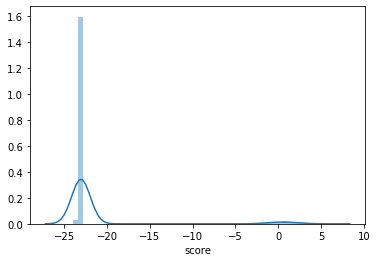

In [12]:
null_importance = null_Importance_maker.all_flow()
sns.distplot(null_importance['score'])
new_cols = null_importance[null_importance['score']>-15].col.tolist()
print(new_cols)

In [13]:
feature =['machinelearn', 'model', 'client', 'ai', 'data', 'provid', 'code', 'analysi', 'prototyp', 'test', 'support', 'learn', 'team',
          'control', 'sale', 'program', 'architectur', 'deep', 'key', 'concept', 'scientist', 'effici', 'integr', 'differ', 'technolog', 
          'approach', 'research', 'respons', 'manag', 'insight', 'environ', 'algorithm', 'pipelin', 'scienc', 'includ', 'activ', 'explor',
          'busi', 'network', 'custom', 'document', 'sourc', 'improv', 'deliveri', 'partner', 'featur', 'particip', 'architect', 'translat',
          'procedur', 'recommend', 'process', 'review', 'level', 'compani', 'techniqu', 'ensur', 'report', 'product', 'deploy', 'write',
          'complex', 'optim', 'appropri', 'avail', 'applic', 'exist', 'vision', 'issu', 'task', 'use', 'limit', 'plan', 'dataset',
          'collabor', 'engin', 'oper', 'configur', 'effect', 'analyz', 'expert', 'mainten', 'softwar', 'drive', 'abil', 'gener', 'predict',
          'across', 'advanc', 'determin', 'opportun', 'unit', 'need', 'infrastructur', 'qualiti', 'execut', 'troubleshoot', 'design',
          'distribut', 'train', 'system', 'develop', 'build', 'continu', 'domain', 'market', 'scalabl', 'new', 'platform', 'strateg',
          'assist', 'may', 'statist', 'technic', 'contribut', 'project', 'valu', 'commun', 'extract', 'secur', 'capabl', 'risk',
          'structur', 'detail', 'demonstr', 'lead', 'embed', 'tool', 'web', 'maintain', 'relev', 'analyt', 'function', 'defin', 'best',
          'conduct', 'meet', 'assign', 'effort', 'skill', 'engag', 'appli', 'knowledg', 'abl', 'interpret', 'agil', 'independ', 'investig',
          'evalu', 'variou', 'python', 'visual', 'requir', 'util', 'enhanc', 'databas', 'end', 'etc', 'trend', 'api', 'creat', 'leverag', 
          'think', 'simul', 'solv', 'action', 'scope', 'scale', 'accuraci', 'make', 'member', 'method', 'stakehold', 'address', 'establish',
          'pattern', 'work', 'servic', 'organ', 'real', 'identifi', 'mentor', 'statu', 'relat', 'must', 'standard', 'object', 'deliv',
          'impact', 'within', 'solut', 'experi', 'resourc', 'direct', 'valid', 'multipl', 'coordin']
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2', 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 1.6061	valid_1's tweedie: 1.70359
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's tweedie: 1.59928	valid_1's tweedie: 1.65377
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.62536	valid_1's tweedie: 1.67699
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.67162	valid_1's tweedie: 1.75043
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.65694	valid_1's tweedie: 1.70263


[I 2020-08-19 20:58:41,497] Finished trial#0 with value: 0.9074266142866596 with parameters: {'tweedie_variance_power': 1.6122842645343125, 'max_bin': 130, 'subsample': 0.7571330507715055, 'subsample_freq': 0.8554680178340941, 'learning_rate': 0.07392043932853828, 'num_leaves': 6, 'feature_fraction': 0.5731668010120945, 'bagging_freq': 1, 'min_child_samples': 45, 'lambda_l1': 0.3327851855180656, 'lambda_l2': 0.03818832102424524}. Best is trial#0 with value: 0.9074266142866596.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 0.949389	valid_1's tweedie: 1.01295
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's tweedie: 0.934661	valid_1's tweedie: 0.994493
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's tweedie: 0.947503	valid_1's tweedie: 1.01437
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's tweedie: 0.957296	valid_1's tweedie: 1.01886
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[159]	training's tweedie: 0.912765	valid_1's tweedie: 1.0103


[I 2020-08-19 20:58:42,342] Finished trial#1 with value: 0.564460116837473 with parameters: {'tweedie_variance_power': 1.3562608831077119, 'max_bin': 168, 'subsample': 0.5993467711041245, 'subsample_freq': 0.6215274144327789, 'learning_rate': 0.09874555330050301, 'num_leaves': 6, 'feature_fraction': 0.4378122045645874, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 0.0016040133092622025, 'lambda_l2': 1.1555201493861975}. Best is trial#1 with value: 0.564460116837473.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's tweedie: 0.904844	valid_1's tweedie: 0.996189
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.845355	valid_1's tweedie: 0.990642
Early stopping, best iteration is:
[324]	training's tweedie: 0.876198	valid_1's tweedie: 0.982677
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[209]	training's tweedie: 0.900747	valid_1's tweedie: 0.983354
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 0.944011	valid_1's tweedie: 0.989528
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's tweedie: 0.942022	valid_1's tweedie: 0.972833


[I 2020-08-19 20:58:43,362] Finished trial#2 with value: 0.5501126814635521 with parameters: {'tweedie_variance_power': 1.268193195757134, 'max_bin': 282, 'subsample': 0.4883687333887594, 'subsample_freq': 0.4505318084517009, 'learning_rate': 0.03721325468689302, 'num_leaves': 9, 'feature_fraction': 0.8007753645912574, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.01739445758708282, 'lambda_l2': 0.2045662106091708}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.79076	valid_1's tweedie: 1.85768
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.71186	valid_1's tweedie: 1.72378
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.78761	valid_1's tweedie: 1.83981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.79773	valid_1's tweedie: 1.84895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.78659	valid_1's tweedie: 1.82654


[I 2020-08-19 20:58:44,122] Finished trial#3 with value: 0.9686991442014659 with parameters: {'tweedie_variance_power': 1.6327870495617582, 'max_bin': 77, 'subsample': 0.4810341157550278, 'subsample_freq': 0.4954332975308724, 'learning_rate': 0.20279707296521918, 'num_leaves': 6, 'feature_fraction': 0.864407642173286, 'bagging_freq': 3, 'min_child_samples': 12, 'lambda_l1': 0.00031932489402339596, 'lambda_l2': 0.006815312459314552}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 4.81658	valid_1's tweedie: 4.82922
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 4.81497	valid_1's tweedie: 4.83569
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[173]	training's tweedie: 4.13966	valid_1's tweedie: 4.17083
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 4.15459	valid_1's tweedie: 4.13983
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 4.1601	valid_1's tweedie: 4.14075


[I 2020-08-19 20:58:44,841] Finished trial#4 with value: 2.4240231260186205 with parameters: {'tweedie_variance_power': 1.0313542746480668, 'max_bin': 79, 'subsample': 0.48612902107226996, 'subsample_freq': 0.8436507913793734, 'learning_rate': 0.3825962566851312, 'num_leaves': 4, 'feature_fraction': 0.7493367741646257, 'bagging_freq': 2, 'min_child_samples': 75, 'lambda_l1': 0.02082188322771748, 'lambda_l2': 5.3406990033323245}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.50135	valid_1's tweedie: 1.50312
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 1.64302	valid_1's tweedie: 1.64648
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 1.64377	valid_1's tweedie: 1.64612
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 1.6435	valid_1's tweedie: 1.63947
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.64272	valid_1's tweedie: 1.63971


[I 2020-08-19 20:58:45,511] Finished trial#5 with value: 1.2481253751510148 with parameters: {'tweedie_variance_power': 1.2726265263287002, 'max_bin': 299, 'subsample': 0.6326374915558381, 'subsample_freq': 0.4491509976207996, 'learning_rate': 0.03684646399954504, 'num_leaves': 5, 'feature_fraction': 0.8672062255419862, 'bagging_freq': 5, 'min_child_samples': 82, 'lambda_l1': 1.794606232073189, 'lambda_l2': 5.30508851892319}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.943119	valid_1's tweedie: 1.0002
Early stopping, best iteration is:
[315]	training's tweedie: 0.952772	valid_1's tweedie: 0.993226
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's tweedie: 0.959263	valid_1's tweedie: 0.987165
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's tweedie: 0.959368	valid_1's tweedie: 1.00323
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's tweedie: 0.977236	valid_1's tweedie: 1.00251
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's tweedie: 0.973001	valid_1's tweedie: 0.992174


[I 2020-08-19 20:58:46,371] Finished trial#6 with value: 0.5544678849319881 with parameters: {'tweedie_variance_power': 1.281776129757973, 'max_bin': 153, 'subsample': 0.6086547037206805, 'subsample_freq': 0.8357483424799124, 'learning_rate': 0.038519145140117755, 'num_leaves': 4, 'feature_fraction': 0.6709980586576318, 'bagging_freq': 5, 'min_child_samples': 39, 'lambda_l1': 0.04762573611262296, 'lambda_l2': 0.3158420748174342}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 2.18993	valid_1's tweedie: 2.2798
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 2.20112	valid_1's tweedie: 2.21285
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[187]	training's tweedie: 2.17428	valid_1's tweedie: 2.22283
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 2.22173	valid_1's tweedie: 2.29119
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 2.24642	valid_1's tweedie: 2.27391


[I 2020-08-19 20:58:47,123] Finished trial#7 with value: 1.1855493484041189 with parameters: {'tweedie_variance_power': 1.690321477942967, 'max_bin': 181, 'subsample': 0.5703968790652552, 'subsample_freq': 0.6362874733067021, 'learning_rate': 0.04892672488353916, 'num_leaves': 4, 'feature_fraction': 0.6303678438313315, 'bagging_freq': 5, 'min_child_samples': 53, 'lambda_l1': 0.03848291092456147, 'lambda_l2': 0.0012317431389936297}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.25849	valid_1's tweedie: 1.34158
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.3016	valid_1's tweedie: 1.32799
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.29773	valid_1's tweedie: 1.34822
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.3239	valid_1's tweedie: 1.36791
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.34109	valid_1's tweedie: 1.35504


[I 2020-08-19 20:58:47,865] Finished trial#8 with value: 0.7325858660845068 with parameters: {'tweedie_variance_power': 1.5316986838570008, 'max_bin': 263, 'subsample': 0.5136953196205465, 'subsample_freq': 0.5032905036263461, 'learning_rate': 0.1740013174627427, 'num_leaves': 4, 'feature_fraction': 0.8708192010087117, 'bagging_freq': 3, 'min_child_samples': 14, 'lambda_l1': 0.06347378278840224, 'lambda_l2': 3.8439517015024327}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's tweedie: 1.17975	valid_1's tweedie: 1.24908
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[163]	training's tweedie: 1.19477	valid_1's tweedie: 1.22264
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 1.1825	valid_1's tweedie: 1.23027
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.22244	valid_1's tweedie: 1.27022
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 1.22504	valid_1's tweedie: 1.24461


[I 2020-08-19 20:58:48,722] Finished trial#9 with value: 0.6778081820504946 with parameters: {'tweedie_variance_power': 1.49482162289419, 'max_bin': 116, 'subsample': 0.6276273915703445, 'subsample_freq': 0.8163362939330103, 'learning_rate': 0.040214427146047636, 'num_leaves': 8, 'feature_fraction': 0.7670954238678307, 'bagging_freq': 6, 'min_child_samples': 50, 'lambda_l1': 2.735071191604672, 'lambda_l2': 0.0007325419713726986}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.60634	valid_1's tweedie: 1.61256
Early stopping, best iteration is:
[534]	training's tweedie: 1.60632	valid_1's tweedie: 1.612
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	training's tweedie: 1.61126	valid_1's tweedie: 1.61425
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.60532	valid_1's tweedie: 1.61397
Early stopping, best iteration is:
[588]	training's tweedie: 1.60552	valid_1's tweedie: 1.61148
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[230]	training's tweedie: 1.61015	valid_1's tweedie: 1.61033
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.6101	valid_1's tweedie: 1.60417
Early stopping, best iteration is:
[513]	training's tweedie: 1.60991	valid_1's tweedie: 1.60288


[I 2020-08-19 20:58:49,621] Finished trial#10 with value: 0.8646288266562522 with parameters: {'tweedie_variance_power': 1.1010769125704254, 'max_bin': 237, 'subsample': 0.4043410291833227, 'subsample_freq': 0.4032617307528087, 'learning_rate': 0.06679820958248751, 'num_leaves': 10, 'feature_fraction': 0.495962559261712, 'bagging_freq': 7, 'min_child_samples': 100, 'lambda_l1': 0.0018762983865446517, 'lambda_l2': 0.09264994375739333}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[260]	training's tweedie: 1.01099	valid_1's tweedie: 1.07419
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[208]	training's tweedie: 1.0227	valid_1's tweedie: 1.06494
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[242]	training's tweedie: 1.01554	valid_1's tweedie: 1.0588
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[163]	training's tweedie: 1.03114	valid_1's tweedie: 1.07818
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[250]	training's tweedie: 1.01358	valid_1's tweedie: 1.06257


[I 2020-08-19 20:58:50,647] Finished trial#11 with value: 0.5891417193088421 with parameters: {'tweedie_variance_power': 1.1992204097847383, 'max_bin': 207, 'subsample': 0.7617643042304527, 'subsample_freq': 0.7520442248757979, 'learning_rate': 0.03086326930901861, 'num_leaves': 9, 'feature_fraction': 0.9977565381381553, 'bagging_freq': 5, 'min_child_samples': 33, 'lambda_l1': 0.008234535103305109, 'lambda_l2': 0.21383507359968643}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 0.921644	valid_1's tweedie: 1.01323
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[235]	training's tweedie: 0.917017	valid_1's tweedie: 0.987574
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 0.939511	valid_1's tweedie: 1.00329
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 0.975033	valid_1's tweedie: 1.03264
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's tweedie: 0.963155	valid_1's tweedie: 1.00983


[I 2020-08-19 20:58:51,621] Finished trial#12 with value: 0.5611244787751469 with parameters: {'tweedie_variance_power': 1.3609420214019143, 'max_bin': 295, 'subsample': 0.8990961190822946, 'subsample_freq': 0.709812472403858, 'learning_rate': 0.03154167664256201, 'num_leaves': 10, 'feature_fraction': 0.6645061552909554, 'bagging_freq': 4, 'min_child_samples': 33, 'lambda_l1': 0.11907958143753074, 'lambda_l2': 0.3967693628751734}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 0.974832	valid_1's tweedie: 1.06279
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 0.990343	valid_1's tweedie: 1.04787
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's tweedie: 1.00932	valid_1's tweedie: 1.04319
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's tweedie: 0.995179	valid_1's tweedie: 1.04397
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's tweedie: 1.00697	valid_1's tweedie: 1.04563


[I 2020-08-19 20:58:52,521] Finished trial#13 with value: 0.580125372868202 with parameters: {'tweedie_variance_power': 1.2074981301731103, 'max_bin': 134, 'subsample': 0.4170888137164016, 'subsample_freq': 0.5473171673898805, 'learning_rate': 0.05875472744504984, 'num_leaves': 8, 'feature_fraction': 0.7904649489993787, 'bagging_freq': 7, 'min_child_samples': 6, 'lambda_l1': 0.5586979605768201, 'lambda_l2': 0.007794482865128979}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[171]	training's tweedie: 1.3495	valid_1's tweedie: 1.39817
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.37688	valid_1's tweedie: 1.39191
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 1.37138	valid_1's tweedie: 1.39521
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.38032	valid_1's tweedie: 1.39498
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.37818	valid_1's tweedie: 1.39402


[I 2020-08-19 20:58:53,339] Finished trial#14 with value: 0.7532131034181244 with parameters: {'tweedie_variance_power': 1.1203242181996762, 'max_bin': 215, 'subsample': 0.7109120148939747, 'subsample_freq': 0.7066496559602136, 'learning_rate': 0.1204514866554464, 'num_leaves': 8, 'feature_fraction': 0.9644662002353506, 'bagging_freq': 4, 'min_child_samples': 66, 'lambda_l1': 0.0033782437402361813, 'lambda_l2': 0.5278625642155746}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 1.12031	valid_1's tweedie: 1.14577
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.09001	valid_1's tweedie: 1.12898
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.06495	valid_1's tweedie: 1.11354
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 1.11593	valid_1's tweedie: 1.16132
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.09799	valid_1's tweedie: 1.14155


[I 2020-08-19 20:58:54,124] Finished trial#15 with value: 0.6262652510299445 with parameters: {'tweedie_variance_power': 1.437761015020044, 'max_bin': 165, 'subsample': 0.5446384510984915, 'subsample_freq': 0.5921908179325197, 'learning_rate': 0.48593716942839493, 'num_leaves': 9, 'feature_fraction': 0.5638879348092848, 'bagging_freq': 6, 'min_child_samples': 27, 'lambda_l1': 0.00011549939046657026, 'lambda_l2': 0.00010464088382173046}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 0.967181	valid_1's tweedie: 1.00398
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's tweedie: 0.960224	valid_1's tweedie: 0.995474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[282]	training's tweedie: 0.941581	valid_1's tweedie: 0.985488
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 0.985161	valid_1's tweedie: 1.00661
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's tweedie: 0.952855	valid_1's tweedie: 0.991727


[I 2020-08-19 20:58:55,017] Finished trial#16 with value: 0.55445266728628 with parameters: {'tweedie_variance_power': 1.2677111069158595, 'max_bin': 264, 'subsample': 0.6926375261442602, 'subsample_freq': 0.8962236426311087, 'learning_rate': 0.0472875826158212, 'num_leaves': 7, 'feature_fraction': 0.7067333676477544, 'bagging_freq': 6, 'min_child_samples': 42, 'lambda_l1': 0.018011308098624227, 'lambda_l2': 1.4392666732059516}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 0.963054	valid_1's tweedie: 1.00015
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's tweedie: 0.955355	valid_1's tweedie: 0.985474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[192]	training's tweedie: 0.939198	valid_1's tweedie: 0.99358
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 0.979126	valid_1's tweedie: 1.00748
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 0.978211	valid_1's tweedie: 0.991982


[I 2020-08-19 20:58:55,852] Finished trial#17 with value: 0.5534820730204667 with parameters: {'tweedie_variance_power': 1.272425039031144, 'max_bin': 268, 'subsample': 0.8848693950514073, 'subsample_freq': 0.8931596334289856, 'learning_rate': 0.08158725873878717, 'num_leaves': 7, 'feature_fraction': 0.7255004400180878, 'bagging_freq': 6, 'min_child_samples': 60, 'lambda_l1': 0.007472232887314886, 'lambda_l2': 1.65226716792343}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's tweedie: 8.95903	valid_1's tweedie: 9.01312
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	training's tweedie: 8.95584	valid_1's tweedie: 9.01798
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's tweedie: 8.95264	valid_1's tweedie: 9.02773
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 8.99362	valid_1's tweedie: 8.93678
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 8.98037	valid_1's tweedie: 8.94668


[I 2020-08-19 20:58:56,785] Finished trial#18 with value: 4.549328475707597 with parameters: {'tweedie_variance_power': 1.0137219523616916, 'max_bin': 277, 'subsample': 0.8997995331643668, 'subsample_freq': 0.41961216998640666, 'learning_rate': 0.08233389335749072, 'num_leaves': 7, 'feature_fraction': 0.9283674784308847, 'bagging_freq': 1, 'min_child_samples': 60, 'lambda_l1': 0.00046688642655596586, 'lambda_l2': 0.0614965719126264}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's tweedie: 1.23062	valid_1's tweedie: 1.27893
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.20451	valid_1's tweedie: 1.26199
Early stopping, best iteration is:
[406]	training's tweedie: 1.21226	valid_1's tweedie: 1.25902
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[151]	training's tweedie: 1.23165	valid_1's tweedie: 1.27055
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	training's tweedie: 1.24889	valid_1's tweedie: 1.27752
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.26807	valid_1's tweedie: 1.26844


[I 2020-08-19 20:58:57,696] Finished trial#19 with value: 0.6912302516998341 with parameters: {'tweedie_variance_power': 1.1394866162383044, 'max_bin': 239, 'subsample': 0.8432491207994813, 'subsample_freq': 0.7752771784985848, 'learning_rate': 0.1564735159856011, 'num_leaves': 9, 'feature_fraction': 0.8054213845374327, 'bagging_freq': 7, 'min_child_samples': 88, 'lambda_l1': 0.006231466947031343, 'lambda_l2': 1.5184198103409725}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.01327	valid_1's tweedie: 1.08367
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.02775	valid_1's tweedie: 1.05154
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.03366	valid_1's tweedie: 1.07243
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.05801	valid_1's tweedie: 1.0992
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.03258	valid_1's tweedie: 1.06619


[I 2020-08-19 20:58:58,521] Finished trial#20 with value: 0.5944517408525644 with parameters: {'tweedie_variance_power': 1.4094408430074374, 'max_bin': 296, 'subsample': 0.829888853881919, 'subsample_freq': 0.5661177572464172, 'learning_rate': 0.27377651582731555, 'num_leaves': 10, 'feature_fraction': 0.7133755250145288, 'bagging_freq': 2, 'min_child_samples': 65, 'lambda_l1': 0.27458793537307796, 'lambda_l2': 0.010322668125848766}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	training's tweedie: 0.966715	valid_1's tweedie: 0.999616
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's tweedie: 0.962073	valid_1's tweedie: 0.987014
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[269]	training's tweedie: 0.949127	valid_1's tweedie: 0.988258
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 0.979082	valid_1's tweedie: 1.00177
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 0.977505	valid_1's tweedie: 0.99259


[I 2020-08-19 20:58:59,395] Finished trial#21 with value: 0.5528791755182881 with parameters: {'tweedie_variance_power': 1.2790512837121368, 'max_bin': 269, 'subsample': 0.6716473028179342, 'subsample_freq': 0.8766962758776237, 'learning_rate': 0.0544702329022638, 'num_leaves': 7, 'feature_fraction': 0.7301452898594634, 'bagging_freq': 6, 'min_child_samples': 58, 'lambda_l1': 0.014918474386362303, 'lambda_l2': 1.9179723983117472}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's tweedie: 1.01279	valid_1's tweedie: 1.03148
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.00776	valid_1's tweedie: 1.03923
Early stopping, best iteration is:
[438]	training's tweedie: 1.00899	valid_1's tweedie: 1.03256
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[198]	training's tweedie: 1.01754	valid_1's tweedie: 1.023
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 1.02235	valid_1's tweedie: 1.04478
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.00587	valid_1's tweedie: 1.03352
Early stopping, best iteration is:
[420]	training's tweedie: 1.00868	valid_1's tweedie: 1.02716


[I 2020-08-19 20:59:00,337] Finished trial#22 with value: 0.5757763119890346 with parameters: {'tweedie_variance_power': 1.2966145589112974, 'max_bin': 250, 'subsample': 0.4552609253537055, 'subsample_freq': 0.8801138902599014, 'learning_rate': 0.056587095956086096, 'num_leaves': 7, 'feature_fraction': 0.8348118555616922, 'bagging_freq': 6, 'min_child_samples': 73, 'lambda_l1': 0.010086501927334629, 'lambda_l2': 0.15158379742025097}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[113]	training's tweedie: 1.04162	valid_1's tweedie: 1.07793
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.00232	valid_1's tweedie: 1.06611
Early stopping, best iteration is:
[473]	training's tweedie: 1.00437	valid_1's tweedie: 1.06351
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[169]	training's tweedie: 1.03442	valid_1's tweedie: 1.07305
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.06117	valid_1's tweedie: 1.07657
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.05993	valid_1's tweedie: 1.07566


[I 2020-08-19 20:59:01,260] Finished trial#23 with value: 0.5927974561320425 with parameters: {'tweedie_variance_power': 1.1982268340794524, 'max_bin': 282, 'subsample': 0.6805441121164085, 'subsample_freq': 0.8992166428272347, 'learning_rate': 0.09195792526241733, 'num_leaves': 8, 'feature_fraction': 0.7322284656620159, 'bagging_freq': 6, 'min_child_samples': 60, 'lambda_l1': 0.0015949403247463602, 'lambda_l2': 0.9669316542183566}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 0.957021	valid_1's tweedie: 1.00423
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's tweedie: 0.957562	valid_1's tweedie: 0.995443
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 0.955832	valid_1's tweedie: 1.00816
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 0.988941	valid_1's tweedie: 1.02307
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 0.972625	valid_1's tweedie: 1.00419


[I 2020-08-19 20:59:02,065] Finished trial#24 with value: 0.5596346796593202 with parameters: {'tweedie_variance_power': 1.3398199357506895, 'max_bin': 209, 'subsample': 0.8401321674900224, 'subsample_freq': 0.7889784937635724, 'learning_rate': 0.11053882085184093, 'num_leaves': 6, 'feature_fraction': 0.6138339737272678, 'bagging_freq': 4, 'min_child_samples': 53, 'lambda_l1': 0.11986789003502749, 'lambda_l2': 2.8213432023013834}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	training's tweedie: 1.112	valid_1's tweedie: 1.16434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[287]	training's tweedie: 1.1161	valid_1's tweedie: 1.14111
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[210]	training's tweedie: 1.11849	valid_1's tweedie: 1.14869
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.14639	valid_1's tweedie: 1.18007
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.14231	valid_1's tweedie: 1.16106


[I 2020-08-19 20:59:02,912] Finished trial#25 with value: 0.6356535365015912 with parameters: {'tweedie_variance_power': 1.458493886536816, 'max_bin': 226, 'subsample': 0.766104199950381, 'subsample_freq': 0.70382915196291, 'learning_rate': 0.050911466212405054, 'num_leaves': 5, 'feature_fraction': 0.9068035538052246, 'bagging_freq': 7, 'min_child_samples': 73, 'lambda_l1': 0.005441040106564394, 'lambda_l2': 7.433926961483719}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.06184	valid_1's tweedie: 1.0871
Early stopping, best iteration is:
[315]	training's tweedie: 1.06711	valid_1's tweedie: 1.08409
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[275]	training's tweedie: 1.07821	valid_1's tweedie: 1.08762
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.06085	valid_1's tweedie: 1.08288
Early stopping, best iteration is:
[333]	training's tweedie: 1.06791	valid_1's tweedie: 1.07901
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's tweedie: 1.07076	valid_1's tweedie: 1.08527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's tweedie: 1.07641	valid_1's tweedie: 1.0904


[I 2020-08-19 20:59:03,828] Finished trial#26 with value: 0.6018329262663754 with parameters: {'tweedie_variance_power': 1.2167888652251535, 'max_bin': 262, 'subsample': 0.5409210680273503, 'subsample_freq': 0.6746203698939914, 'learning_rate': 0.06678417428486662, 'num_leaves': 7, 'feature_fraction': 0.8143621024869178, 'bagging_freq': 5, 'min_child_samples': 95, 'lambda_l1': 0.0005752919699314363, 'lambda_l2': 0.6625484604530033}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 0.987984	valid_1's tweedie: 1.01586
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.84592	valid_1's tweedie: 1.84792
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.961134	valid_1's tweedie: 1.0059
Early stopping, best iteration is:
[391]	training's tweedie: 0.967319	valid_1's tweedie: 0.996623
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's tweedie: 1.84692	valid_1's tweedie: 1.84391
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.964702	valid_1's tweedie: 1.04013
Early stopping, best iteration is:
[428]	training's tweedie: 0.969302	valid_1's tweedie: 1.02737


[I 2020-08-19 20:59:04,683] Finished trial#27 with value: 0.8862909708897672 with parameters: {'tweedie_variance_power': 1.3245466630223204, 'max_bin': 280, 'subsample': 0.4346616180685834, 'subsample_freq': 0.7537528009031911, 'learning_rate': 0.1400897808134306, 'num_leaves': 9, 'feature_fraction': 0.6611354070996376, 'bagging_freq': 6, 'min_child_samples': 59, 'lambda_l1': 0.01984559539181925, 'lambda_l2': 9.021657175089238}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.29238	valid_1's tweedie: 2.33124
Early stopping, best iteration is:
[445]	training's tweedie: 2.29426	valid_1's tweedie: 2.33025
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.2932	valid_1's tweedie: 2.33087
Early stopping, best iteration is:
[412]	training's tweedie: 2.29648	valid_1's tweedie: 2.32838
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.29485	valid_1's tweedie: 2.33736
Early stopping, best iteration is:
[464]	training's tweedie: 2.29587	valid_1's tweedie: 2.33595
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's tweedie: 2.32355	valid_1's tweedie: 2.31873
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.29729	valid_1's tweedie: 2.31559
Early stopping, best iteration is:
[320]	training's tweedie: 2.

[I 2020-08-19 20:59:05,711] Finished trial#28 with value: 1.2190336014132575 with parameters: {'tweedie_variance_power': 1.0605580239067842, 'max_bin': 199, 'subsample': 0.7835284514967271, 'subsample_freq': 0.8778844642551196, 'learning_rate': 0.03013456075101678, 'num_leaves': 5, 'feature_fraction': 0.7599704641777173, 'bagging_freq': 5, 'min_child_samples': 48, 'lambda_l1': 0.0034007281273159863, 'lambda_l2': 0.023509944390887244}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's tweedie: 1.22827	valid_1's tweedie: 1.24991
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[198]	training's tweedie: 1.22638	valid_1's tweedie: 1.23385
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's tweedie: 1.22678	valid_1's tweedie: 1.23937
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	training's tweedie: 1.22513	valid_1's tweedie: 1.228
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[283]	training's tweedie: 1.22315	valid_1's tweedie: 1.22174


[I 2020-08-19 20:59:06,533] Finished trial#29 with value: 0.6759670136467173 with parameters: {'tweedie_variance_power': 1.1496847497173905, 'max_bin': 250, 'subsample': 0.7241250221463633, 'subsample_freq': 0.8098272899132342, 'learning_rate': 0.08058521548098202, 'num_leaves': 6, 'feature_fraction': 0.5633646419821154, 'bagging_freq': 4, 'min_child_samples': 67, 'lambda_l1': 9.730396898383193, 'lambda_l2': 2.4471767116737775}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	training's tweedie: 0.983688	valid_1's tweedie: 1.04557
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 0.990825	valid_1's tweedie: 1.01622
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's tweedie: 0.994523	valid_1's tweedie: 1.02278
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.03018	valid_1's tweedie: 1.06192
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.01335	valid_1's tweedie: 1.03439


[I 2020-08-19 20:59:07,396] Finished trial#30 with value: 0.5759187059197528 with parameters: {'tweedie_variance_power': 1.3779673789684814, 'max_bin': 282, 'subsample': 0.814716634843844, 'subsample_freq': 0.4764660160736172, 'learning_rate': 0.07028081536584102, 'num_leaves': 8, 'feature_fraction': 0.7042442037475628, 'bagging_freq': 2, 'min_child_samples': 80, 'lambda_l1': 0.0839035661475367, 'lambda_l2': 0.12966587711595087}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[282]	training's tweedie: 0.944679	valid_1's tweedie: 1.0012
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's tweedie: 0.965629	valid_1's tweedie: 0.991842
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[258]	training's tweedie: 0.951968	valid_1's tweedie: 0.990652
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's tweedie: 0.992907	valid_1's tweedie: 1.00877
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	training's tweedie: 0.962311	valid_1's tweedie: 0.993239


[I 2020-08-19 20:59:08,319] Finished trial#31 with value: 0.5552075335701718 with parameters: {'tweedie_variance_power': 1.265451748085514, 'max_bin': 263, 'subsample': 0.6749333604622546, 'subsample_freq': 0.8963733259358359, 'learning_rate': 0.04304491500695337, 'num_leaves': 7, 'feature_fraction': 0.7019099065169246, 'bagging_freq': 6, 'min_child_samples': 44, 'lambda_l1': 0.015073255061196663, 'lambda_l2': 1.7565340344097387}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	training's tweedie: 0.96819	valid_1's tweedie: 1.01408
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	training's tweedie: 0.984345	valid_1's tweedie: 1.00324
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[223]	training's tweedie: 0.966781	valid_1's tweedie: 1.01801
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 0.995592	valid_1's tweedie: 1.0177
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's tweedie: 0.994348	valid_1's tweedie: 1.0056


[I 2020-08-19 20:59:09,181] Finished trial#32 with value: 0.5638653236281378 with parameters: {'tweedie_variance_power': 1.2451217720124867, 'max_bin': 250, 'subsample': 0.6618099610071716, 'subsample_freq': 0.8484697914244399, 'learning_rate': 0.05041194272773158, 'num_leaves': 7, 'feature_fraction': 0.6115818812241964, 'bagging_freq': 7, 'min_child_samples': 43, 'lambda_l1': 0.026287395971736634, 'lambda_l2': 0.9801057324628855}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 0.960834	valid_1's tweedie: 0.996076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 0.963732	valid_1's tweedie: 0.993551
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 0.946473	valid_1's tweedie: 0.996663
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 0.979126	valid_1's tweedie: 1.0067
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 0.982045	valid_1's tweedie: 0.997751


[I 2020-08-19 20:59:10,019] Finished trial#33 with value: 0.5562258956147931 with parameters: {'tweedie_variance_power': 1.319643471194441, 'max_bin': 269, 'subsample': 0.7235664740822331, 'subsample_freq': 0.8616340653240279, 'learning_rate': 0.0613730773418234, 'num_leaves': 6, 'feature_fraction': 0.7661285150008317, 'bagging_freq': 6, 'min_child_samples': 56, 'lambda_l1': 0.011324274131482586, 'lambda_l2': 0.3340593707179074}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.08408	valid_1's tweedie: 1.16374
Early stopping, best iteration is:
[392]	training's tweedie: 1.092	valid_1's tweedie: 1.16207
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.08543	valid_1's tweedie: 1.1729
Early stopping, best iteration is:
[395]	training's tweedie: 1.09381	valid_1's tweedie: 1.16519
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's tweedie: 1.10639	valid_1's tweedie: 1.16161
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[210]	training's tweedie: 1.11456	valid_1's tweedie: 1.1619
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's tweedie: 1.12283	valid_1's tweedie: 1.14875


[I 2020-08-19 20:59:11,276] Finished trial#34 with value: 0.6362496598447778 with parameters: {'tweedie_variance_power': 1.1639954710296687, 'max_bin': 298, 'subsample': 0.5656629376564666, 'subsample_freq': 0.867364368655291, 'learning_rate': 0.043718125087553274, 'num_leaves': 7, 'feature_fraction': 0.7411291517268026, 'bagging_freq': 6, 'min_child_samples': 20, 'lambda_l1': 0.0011265145916847462, 'lambda_l2': 0.7638959278440207}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 0.978183	valid_1's tweedie: 1.00947
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 0.981952	valid_1's tweedie: 1.00782
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[219]	training's tweedie: 0.951878	valid_1's tweedie: 1.01143
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.00014	valid_1's tweedie: 1.02636
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's tweedie: 0.957223	valid_1's tweedie: 1.01231


[I 2020-08-19 20:59:12,196] Finished trial#35 with value: 0.5637193257405999 with parameters: {'tweedie_variance_power': 1.2456198203956539, 'max_bin': 235, 'subsample': 0.5848808129484091, 'subsample_freq': 0.8906889882613387, 'learning_rate': 0.10046589327912119, 'num_leaves': 6, 'feature_fraction': 0.8314176122077357, 'bagging_freq': 3, 'min_child_samples': 38, 'lambda_l1': 0.0036374040032159374, 'lambda_l2': 0.0469363792101352}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[296]	training's tweedie: 0.947343	valid_1's tweedie: 1.06444
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.920745	valid_1's tweedie: 1.05081
Early stopping, best iteration is:
[424]	training's tweedie: 0.931882	valid_1's tweedie: 1.04285
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.921046	valid_1's tweedie: 1.04773
Early stopping, best iteration is:
[342]	training's tweedie: 0.948501	valid_1's tweedie: 1.03764
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	training's tweedie: 1.00898	valid_1's tweedie: 1.06371
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 1.00577	valid_1's tweedie: 1.0429


[I 2020-08-19 20:59:13,356] Finished trial#36 with value: 0.581621831524014 with parameters: {'tweedie_variance_power': 1.4036823228867792, 'max_bin': 50, 'subsample': 0.6323576989557657, 'subsample_freq': 0.8329471835145319, 'learning_rate': 0.03678907735850921, 'num_leaves': 8, 'feature_fraction': 0.6808000598147846, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 0.20131644620950184, 'lambda_l2': 8.962065706309485}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[248]	training's tweedie: 1.83519	valid_1's tweedie: 1.86505
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.8307	valid_1's tweedie: 1.85429
[1000]	training's tweedie: 1.81763	valid_1's tweedie: 1.84995
Early stopping, best iteration is:
[1149]	training's tweedie: 1.81471	valid_1's tweedie: 1.84713
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.8269	valid_1's tweedie: 1.86513
Early stopping, best iteration is:
[322]	training's tweedie: 1.83396	valid_1's tweedie: 1.86106
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's tweedie: 1.84432	valid_1's tweedie: 1.85116
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's tweedie: 1.85842	valid_1's tweedie: 1.85104


[I 2020-08-19 20:59:14,438] Finished trial#37 with value: 0.9835015930288087 with parameters: {'tweedie_variance_power': 1.0802717167043956, 'max_bin': 186, 'subsample': 0.7024087632991547, 'subsample_freq': 0.8999083503208823, 'learning_rate': 0.08051594273033386, 'num_leaves': 5, 'feature_fraction': 0.6446724066445821, 'bagging_freq': 7, 'min_child_samples': 69, 'lambda_l1': 0.03380265694799785, 'lambda_l2': 3.47227119494408}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.01388	valid_1's tweedie: 1.03719
Early stopping, best iteration is:
[319]	training's tweedie: 1.01849	valid_1's tweedie: 1.03579
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[276]	training's tweedie: 1.02559	valid_1's tweedie: 1.03823
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.01054	valid_1's tweedie: 1.03197
Early stopping, best iteration is:
[342]	training's tweedie: 1.01667	valid_1's tweedie: 1.02799
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[265]	training's tweedie: 1.01701	valid_1's tweedie: 1.04454
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.01473	valid_1's tweedie: 1.0347
Early stopping, best iteration is:
[724]	training's tweedie: 1.01007	valid_1's tweedie: 1.03147


[I 2020-08-19 20:59:15,524] Finished trial#38 with value: 0.5778477995831474 with parameters: {'tweedie_variance_power': 1.305855046657652, 'max_bin': 288, 'subsample': 0.50025717400447, 'subsample_freq': 0.7995435847810237, 'learning_rate': 0.03625763681017151, 'num_leaves': 6, 'feature_fraction': 0.780162946660919, 'bagging_freq': 5, 'min_child_samples': 82, 'lambda_l1': 0.016432948351555683, 'lambda_l2': 1.1650489594994622}. Best is trial#2 with value: 0.5501126814635521.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's tweedie: 1.28365	valid_1's tweedie: 1.39503
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's tweedie: 1.26541	valid_1's tweedie: 1.35493
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.31997	valid_1's tweedie: 1.39638
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.31702	valid_1's tweedie: 1.42411
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.29805	valid_1's tweedie: 1.39094


[I 2020-08-19 20:59:16,462] Finished trial#39 with value: 0.7548229966006653 with parameters: {'tweedie_variance_power': 1.5458703279667123, 'max_bin': 221, 'subsample': 0.6082378705036562, 'subsample_freq': 0.5336436316506117, 'learning_rate': 0.04559168998612666, 'num_leaves': 7, 'feature_fraction': 0.7254173349558408, 'bagging_freq': 3, 'min_child_samples': 16, 'lambda_l1': 0.03971129922620922, 'lambda_l2': 0.19477700385831573}. Best is trial#2 with value: 0.5501126814635521.


0.5501126814635521
{'tweedie_variance_power': 1.268193195757134, 'max_bin': 282, 'subsample': 0.4883687333887594, 'subsample_freq': 0.4505318084517009, 'learning_rate': 0.03721325468689302, 'num_leaves': 9, 'feature_fraction': 0.8007753645912574, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.01739445758708282, 'lambda_l2': 0.2045662106091708}


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's tweedie: 0.904844	valid_1's tweedie: 0.996189
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 0.845355	valid_1's tweedie: 0.990642
Early stopping, best iteration is:
[324]	training's tweedie: 0.876198	valid_1's tweedie: 0.982677
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[209]	training's tweedie: 0.900747	valid_1's tweedie: 0.983354
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 0.944011	valid_1's tweedie: 0.989528
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's tweedie: 0.942022	valid_1's tweedie: 0.972833
0.8386216308427158


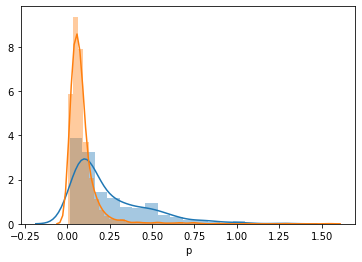

In [15]:
PARAMS={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    'tweedie_variance_power': 1.268193195757134, 'max_bin': 282, 'subsample': 0.4883687333887594, 'subsample_freq': 0.4505318084517009, 
    'learning_rate': 0.03721325468689302, 'num_leaves': 9, 'feature_fraction': 0.8007753645912574, 'bagging_freq': 4,
    'min_child_samples': 5, 'lambda_l1': 0.01739445758708282, 'lambda_l2': 0.2045662106091708
}

score = 0
k = StratifiedKFold(n_splits=5)
off_df=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_data = train_df.iloc[trn,:]
    val_data = train_df.iloc[val,:]
    
    train_set= lgb.Dataset(trn_data[new_cols],  trn_data['jobflag_2'])
    val_set = lgb.Dataset(val_data[new_cols],  val_data['jobflag_2'])   
    
    model = lgb.train(
        train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
        early_stopping_rounds=200, verbose_eval=500
    )
    
    val_data['p'] = model.predict(val_data[new_cols])
    off_df.append(val_data[['jobflag', 'jobflag_2', 'p']])
    
off_df = pd.concat(off_df, axis=0)
off_df['pred'] = off_df.p.apply(lambda x: 1 if x>0.15 else 0)

print(metrics.accuracy_score(off_df.jobflag_2, off_df.pred))

sns.distplot(off_df[off_df.jobflag_2==1].p)
sns.distplot(off_df[off_df.jobflag_2==0].p)

#### label 4

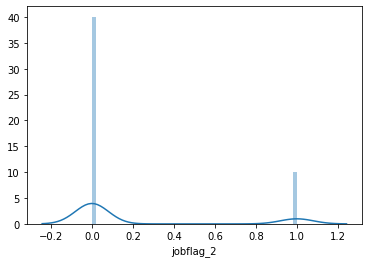

In [16]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==4 else 0)
sns.distplot(train_df.jobflag_2)

In [47]:
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
optimize_optuna = Optimize_by_Optuna(data=train_df, features=feature,target_colname= 'jobflag_2',target_name_2= 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.91875	valid_1's tweedie: 2.00467
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.93945	valid_1's tweedie: 2.01051
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's tweedie: 1.84328	valid_1's tweedie: 1.895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's tweedie: 1.84324	valid_1's tweedie: 1.90081
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.87795	valid_1's tweedie: 1.95369


[I 2020-08-19 15:59:18,711] Finished trial#0 with value: 1.0697791848941236 with parameters: {'tweedie_variance_power': 1.600089915512092, 'max_bin': 279, 'subsample': 0.6559945339862616, 'subsample_freq': 0.6325112768319816, 'learning_rate': 0.06866907727935392, 'num_leaves': 6, 'feature_fraction': 0.44407552825175023, 'bagging_freq': 4, 'min_child_samples': 61, 'lambda_l1': 0.02648129358138311, 'lambda_l2': 0.9228098558212354}. Best is trial#0 with value: 1.0697791848941236.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.46971	valid_1's tweedie: 1.53636
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 1.4565	valid_1's tweedie: 1.51904
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.47589	valid_1's tweedie: 1.51604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.47841	valid_1's tweedie: 1.49906
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.46732	valid_1's tweedie: 1.52267


[I 2020-08-19 15:59:26,751] Finished trial#1 with value: 0.8524579845248792 with parameters: {'tweedie_variance_power': 1.2299753068589563, 'max_bin': 293, 'subsample': 0.5099854931606935, 'subsample_freq': 0.8194713010785144, 'learning_rate': 0.16819677707124053, 'num_leaves': 9, 'feature_fraction': 0.5055065747887347, 'bagging_freq': 7, 'min_child_samples': 40, 'lambda_l1': 0.01830208715380742, 'lambda_l2': 0.00016785296294128784}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.59233	valid_1's tweedie: 1.66895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.56637	valid_1's tweedie: 1.63172
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.51486	valid_1's tweedie: 1.56363
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.52963	valid_1's tweedie: 1.57907
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.43351	valid_1's tweedie: 1.58436


[I 2020-08-19 15:59:34,772] Finished trial#2 with value: 0.8918177183177995 with parameters: {'tweedie_variance_power': 1.5041367947776854, 'max_bin': 123, 'subsample': 0.7989167831486267, 'subsample_freq': 0.665446824346272, 'learning_rate': 0.3400577437714441, 'num_leaves': 7, 'feature_fraction': 0.8125214556054352, 'bagging_freq': 7, 'min_child_samples': 40, 'lambda_l1': 0.007893511657902749, 'lambda_l2': 0.02195956139290191}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.84485	valid_1's tweedie: 1.94975
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.8791	valid_1's tweedie: 1.94964
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.82227	valid_1's tweedie: 1.83877
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.81323	valid_1's tweedie: 1.8541
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.8034	valid_1's tweedie: 1.8893


[I 2020-08-19 15:59:42,755] Finished trial#3 with value: 1.0416407714355054 with parameters: {'tweedie_variance_power': 1.5865701388708975, 'max_bin': 160, 'subsample': 0.5238738078259793, 'subsample_freq': 0.4483877853700213, 'learning_rate': 0.16897733587897795, 'num_leaves': 6, 'feature_fraction': 0.6069114303466593, 'bagging_freq': 1, 'min_child_samples': 48, 'lambda_l1': 0.0001738143338444797, 'lambda_l2': 0.00048264154631729096}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's tweedie: 2.11017	valid_1's tweedie: 2.23639
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 2.22788	valid_1's tweedie: 2.32579
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[258]	training's tweedie: 2.10684	valid_1's tweedie: 2.20376
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[209]	training's tweedie: 2.10835	valid_1's tweedie: 2.18601
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[186]	training's tweedie: 2.07871	valid_1's tweedie: 2.17538


[I 2020-08-19 15:59:50,818] Finished trial#4 with value: 1.2082660151132734 with parameters: {'tweedie_variance_power': 1.6402286898307097, 'max_bin': 110, 'subsample': 0.7909513876915165, 'subsample_freq': 0.6779314671598884, 'learning_rate': 0.059515447244853185, 'num_leaves': 5, 'feature_fraction': 0.7918262897193, 'bagging_freq': 3, 'min_child_samples': 97, 'lambda_l1': 0.1494651515192782, 'lambda_l2': 6.361080576953711}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.71151	valid_1's tweedie: 1.78148
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.73901	valid_1's tweedie: 1.77857
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.62603	valid_1's tweedie: 1.65271
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.58749	valid_1's tweedie: 1.64485
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.65029	valid_1's tweedie: 1.71371


[I 2020-08-19 15:59:58,807] Finished trial#5 with value: 0.9511234626264464 with parameters: {'tweedie_variance_power': 1.5385901021618007, 'max_bin': 206, 'subsample': 0.8973515270297477, 'subsample_freq': 0.7217140330439669, 'learning_rate': 0.21014416708244865, 'num_leaves': 5, 'feature_fraction': 0.8681166684380501, 'bagging_freq': 1, 'min_child_samples': 60, 'lambda_l1': 0.010934355754877181, 'lambda_l2': 0.12550098757066155}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 12.7975	valid_1's tweedie: 12.8611
Early stopping, best iteration is:
[314]	training's tweedie: 12.8075	valid_1's tweedie: 12.8577
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	training's tweedie: 12.8211	valid_1's tweedie: 12.8743
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's tweedie: 12.8148	valid_1's tweedie: 12.8644
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 12.8389	valid_1's tweedie: 12.7929
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[114]	training's tweedie: 12.8322	valid_1's tweedie: 12.8307


[I 2020-08-19 16:00:06,855] Finished trial#6 with value: 6.5202514921333155 with parameters: {'tweedie_variance_power': 1.0160940175637714, 'max_bin': 118, 'subsample': 0.6328046370147313, 'subsample_freq': 0.7282913411204508, 'learning_rate': 0.08364458350029463, 'num_leaves': 6, 'feature_fraction': 0.7812266831147292, 'bagging_freq': 7, 'min_child_samples': 97, 'lambda_l1': 0.2570431460071185, 'lambda_l2': 0.10869657955520325}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.51694	valid_1's tweedie: 1.57876
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.52286	valid_1's tweedie: 1.56483
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.51891	valid_1's tweedie: 1.55576
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.51478	valid_1's tweedie: 1.53483
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.51748	valid_1's tweedie: 1.55817


[I 2020-08-19 16:00:14,879] Finished trial#7 with value: 0.8693062843508023 with parameters: {'tweedie_variance_power': 1.2122573693605774, 'max_bin': 158, 'subsample': 0.6387786503744253, 'subsample_freq': 0.5181472936504408, 'learning_rate': 0.14017810116574497, 'num_leaves': 8, 'feature_fraction': 0.8010536291363177, 'bagging_freq': 6, 'min_child_samples': 38, 'lambda_l1': 0.16699498101682492, 'lambda_l2': 0.000467167843303247}. Best is trial#1 with value: 0.8524579845248792.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's tweedie: 1.46693	valid_1's tweedie: 1.55962
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.5304	valid_1's tweedie: 1.56293
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's tweedie: 1.44752	valid_1's tweedie: 1.47808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[192]	training's tweedie: 1.46682	valid_1's tweedie: 1.48198
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 1.46269	valid_1's tweedie: 1.51429


[I 2020-08-19 16:00:22,977] Finished trial#8 with value: 0.8507889715477717 with parameters: {'tweedie_variance_power': 1.4616572741379197, 'max_bin': 145, 'subsample': 0.6343837811878572, 'subsample_freq': 0.6495301622470209, 'learning_rate': 0.04683046747786626, 'num_leaves': 5, 'feature_fraction': 0.9843225687482132, 'bagging_freq': 6, 'min_child_samples': 60, 'lambda_l1': 3.7538595585093693, 'lambda_l2': 0.004253165192875187}. Best is trial#8 with value: 0.8507889715477717.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.89532	valid_1's tweedie: 1.97991
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.95488	valid_1's tweedie: 1.99328
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[134]	training's tweedie: 1.80116	valid_1's tweedie: 1.89063
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.83188	valid_1's tweedie: 1.89156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.81911	valid_1's tweedie: 1.90391


[I 2020-08-19 16:00:30,938] Finished trial#9 with value: 1.0604338554545714 with parameters: {'tweedie_variance_power': 1.596122381639389, 'max_bin': 194, 'subsample': 0.6707182096442121, 'subsample_freq': 0.8982591804094648, 'learning_rate': 0.14887532728090538, 'num_leaves': 4, 'feature_fraction': 0.4020528768899986, 'bagging_freq': 5, 'min_child_samples': 62, 'lambda_l1': 0.0013767888173660053, 'lambda_l2': 0.00018859833459665556}. Best is trial#8 with value: 0.8507889715477717.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 3.47257	valid_1's tweedie: 3.6124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 3.57115	valid_1's tweedie: 3.67023
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 3.41807	valid_1's tweedie: 3.41757
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 3.06382	valid_1's tweedie: 3.29622
Early stopping, best iteration is:
[414]	training's tweedie: 3.10526	valid_1's tweedie: 3.27245
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[218]	training's tweedie: 3.22964	valid_1's tweedie: 3.35624


[I 2020-08-19 16:00:39,172] Finished trial#10 with value: 1.8294402679319925 with parameters: {'tweedie_variance_power': 1.7637720562194381, 'max_bin': 56, 'subsample': 0.7609457961283077, 'subsample_freq': 0.5611381697944247, 'learning_rate': 0.031022744089479633, 'num_leaves': 4, 'feature_fraction': 0.9882498338261272, 'bagging_freq': 3, 'min_child_samples': 8, 'lambda_l1': 7.004684591964104, 'lambda_l2': 0.006264289861620885}. Best is trial#8 with value: 0.8507889715477717.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35857	valid_1's tweedie: 1.4262
Early stopping, best iteration is:
[564]	training's tweedie: 1.35305	valid_1's tweedie: 1.42484
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36737	valid_1's tweedie: 1.40711
Early stopping, best iteration is:
[533]	training's tweedie: 1.3651	valid_1's tweedie: 1.40698
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38404	valid_1's tweedie: 1.41454
Early stopping, best iteration is:
[333]	training's tweedie: 1.38404	valid_1's tweedie: 1.41454
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38095	valid_1's tweedie: 1.41349
Early stopping, best iteration is:
[367]	training's tweedie: 1.38097	valid_1's tweedie: 1.41347
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36278	valid_1's tweedie: 1.43342
Ear

[I 2020-08-19 16:00:47,641] Finished trial#11 with value: 0.794834289054108 with parameters: {'tweedie_variance_power': 1.296029701119492, 'max_bin': 295, 'subsample': 0.5001586369941206, 'subsample_freq': 0.857896083576887, 'learning_rate': 0.03975264832742246, 'num_leaves': 10, 'feature_fraction': 0.5800407241840084, 'bagging_freq': 6, 'min_child_samples': 19, 'lambda_l1': 9.354584478780701, 'lambda_l2': 0.002404802393099737}. Best is trial#11 with value: 0.794834289054108.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.31794	valid_1's tweedie: 1.41433
Early stopping, best iteration is:
[563]	training's tweedie: 1.31143	valid_1's tweedie: 1.41083
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.32647	valid_1's tweedie: 1.38472
Early stopping, best iteration is:
[486]	training's tweedie: 1.32676	valid_1's tweedie: 1.38443
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.32643	valid_1's tweedie: 1.39759
Early stopping, best iteration is:
[619]	training's tweedie: 1.31322	valid_1's tweedie: 1.39156
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.32841	valid_1's tweedie: 1.38024
Early stopping, best iteration is:
[586]	training's tweedie: 1.32	valid_1's tweedie: 1.37962
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.31877	valid_1's tweedie: 1.41361
Earl

[I 2020-08-19 16:00:56,532] Finished trial#12 with value: 0.7832340309352894 with parameters: {'tweedie_variance_power': 1.3550453972213072, 'max_bin': 249, 'subsample': 0.44558834664799596, 'subsample_freq': 0.8007645551516496, 'learning_rate': 0.03518137046082547, 'num_leaves': 10, 'feature_fraction': 0.6198565706800311, 'bagging_freq': 5, 'min_child_samples': 8, 'lambda_l1': 9.158923232248503, 'lambda_l2': 0.0028594401194864463}. Best is trial#12 with value: 0.7832340309352894.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.32501	valid_1's tweedie: 1.41991
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.23305	valid_1's tweedie: 1.40497
Early stopping, best iteration is:
[335]	training's tweedie: 1.26849	valid_1's tweedie: 1.38408
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's tweedie: 1.30907	valid_1's tweedie: 1.39249
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 1.30987	valid_1's tweedie: 1.36422
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[166]	training's tweedie: 1.31796	valid_1's tweedie: 1.40611


[I 2020-08-19 16:01:05,224] Finished trial#13 with value: 0.7830027267096454 with parameters: {'tweedie_variance_power': 1.307306265460617, 'max_bin': 248, 'subsample': 0.4169537949950859, 'subsample_freq': 0.8849580019138057, 'learning_rate': 0.033677603225831486, 'num_leaves': 10, 'feature_fraction': 0.62055013736942, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 1.3270163527129084, 'lambda_l2': 0.0033622154524905845}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's tweedie: 1.31046	valid_1's tweedie: 1.41311
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	training's tweedie: 1.3199	valid_1's tweedie: 1.39321
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	training's tweedie: 1.29674	valid_1's tweedie: 1.38074
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.30168	valid_1's tweedie: 1.36149
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's tweedie: 1.3189	valid_1's tweedie: 1.39466


[I 2020-08-19 16:01:13,680] Finished trial#14 with value: 0.783197899221016 with parameters: {'tweedie_variance_power': 1.3541961029794634, 'max_bin': 236, 'subsample': 0.4007425779934237, 'subsample_freq': 0.7998496681961945, 'learning_rate': 0.03316184159846841, 'num_leaves': 10, 'feature_fraction': 0.6571433367158777, 'bagging_freq': 4, 'min_child_samples': 7, 'lambda_l1': 1.2521091431678613, 'lambda_l2': 0.0018754632849619056}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.98713	valid_1's tweedie: 2.03201
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[279]	training's tweedie: 1.92877	valid_1's tweedie: 2.0083
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.99521	valid_1's tweedie: 2.02053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 1.94957	valid_1's tweedie: 2.00655
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	training's tweedie: 1.95482	valid_1's tweedie: 2.01995


[I 2020-08-19 16:01:21,911] Finished trial#15 with value: 1.0960755840721175 with parameters: {'tweedie_variance_power': 1.1350601980496402, 'max_bin': 247, 'subsample': 0.403217300130561, 'subsample_freq': 0.8963512207815281, 'learning_rate': 0.09272407215245741, 'num_leaves': 9, 'feature_fraction': 0.6790847104592757, 'bagging_freq': 3, 'min_child_samples': 21, 'lambda_l1': 1.4327127726943112, 'lambda_l2': 0.017734294372101538}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 1.47825	valid_1's tweedie: 1.51737
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[284]	training's tweedie: 1.46934	valid_1's tweedie: 1.4776
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.45473	valid_1's tweedie: 1.48461
Early stopping, best iteration is:
[524]	training's tweedie: 1.45327	valid_1's tweedie: 1.48197
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.46282	valid_1's tweedie: 1.47876
Early stopping, best iteration is:
[360]	training's tweedie: 1.4698	valid_1's tweedie: 1.472
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	training's tweedie: 1.4761	valid_1's tweedie: 1.48966


[I 2020-08-19 16:01:30,012] Finished trial#16 with value: 0.8419486699073586 with parameters: {'tweedie_variance_power': 1.3810371318442003, 'max_bin': 234, 'subsample': 0.4104270947333961, 'subsample_freq': 0.7881649264471264, 'learning_rate': 0.030109197495732345, 'num_leaves': 9, 'feature_fraction': 0.7059939065057134, 'bagging_freq': 4, 'min_child_samples': 81, 'lambda_l1': 0.9217939207568541, 'lambda_l2': 0.0013051353686811635}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's tweedie: 3.17738	valid_1's tweedie: 3.23316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[169]	training's tweedie: 3.17534	valid_1's tweedie: 3.21991
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's tweedie: 3.1786	valid_1's tweedie: 3.22436
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's tweedie: 3.17499	valid_1's tweedie: 3.20573
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[283]	training's tweedie: 3.15116	valid_1's tweedie: 3.2228


[I 2020-08-19 16:01:38,314] Finished trial#17 with value: 1.695893455417525 with parameters: {'tweedie_variance_power': 1.0727981106537192, 'max_bin': 223, 'subsample': 0.4598906962014221, 'subsample_freq': 0.8486504318220877, 'learning_rate': 0.0499752698102563, 'num_leaves': 10, 'feature_fraction': 0.5261746620779101, 'bagging_freq': 2, 'min_child_samples': 21, 'lambda_l1': 0.6693047292745973, 'lambda_l2': 0.1045252621271115}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.37294	valid_1's tweedie: 1.44843
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.32178	valid_1's tweedie: 1.41473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.38848	valid_1's tweedie: 1.41539
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.38111	valid_1's tweedie: 1.40094
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.37188	valid_1's tweedie: 1.42645


[I 2020-08-19 16:01:46,402] Finished trial#18 with value: 0.8004935443179645 with parameters: {'tweedie_variance_power': 1.2888185546691433, 'max_bin': 266, 'subsample': 0.5636491684809073, 'subsample_freq': 0.7558828316355346, 'learning_rate': 0.48374867766596175, 'num_leaves': 8, 'feature_fraction': 0.6917130213249956, 'bagging_freq': 5, 'min_child_samples': 7, 'lambda_l1': 2.5297711081543603, 'lambda_l2': 0.0007753537490300852}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.44507	valid_1's tweedie: 1.53443
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.47799	valid_1's tweedie: 1.51646
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.42411	valid_1's tweedie: 1.4518
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.41117	valid_1's tweedie: 1.45833
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.40698	valid_1's tweedie: 1.46911


[I 2020-08-19 16:01:54,404] Finished trial#19 with value: 0.8320602433986359 with parameters: {'tweedie_variance_power': 1.4483497873227875, 'max_bin': 193, 'subsample': 0.564008309966166, 'subsample_freq': 0.8865360954082061, 'learning_rate': 0.10589576044128032, 'num_leaves': 8, 'feature_fraction': 0.547703031883796, 'bagging_freq': 4, 'min_child_samples': 30, 'lambda_l1': 0.07861173854034371, 'lambda_l2': 0.008801536722812775}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 1.85712	valid_1's tweedie: 1.91992
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's tweedie: 1.8351	valid_1's tweedie: 1.90712
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.82988	valid_1's tweedie: 1.91762
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[120]	training's tweedie: 1.84027	valid_1's tweedie: 1.88751
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.85527	valid_1's tweedie: 1.91789


[I 2020-08-19 16:02:02,825] Finished trial#20 with value: 1.0415014172393582 with parameters: {'tweedie_variance_power': 1.1467062057513304, 'max_bin': 219, 'subsample': 0.4005732493076946, 'subsample_freq': 0.8372000418978686, 'learning_rate': 0.06434275691661087, 'num_leaves': 10, 'feature_fraction': 0.6522769541088811, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 0.46028975822702617, 'lambda_l2': 0.053090632940987426}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.33182	valid_1's tweedie: 1.42518
Early stopping, best iteration is:
[553]	training's tweedie: 1.32579	valid_1's tweedie: 1.42319
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.34152	valid_1's tweedie: 1.39665
[1000]	training's tweedie: 1.30626	valid_1's tweedie: 1.38633
Early stopping, best iteration is:
[877]	training's tweedie: 1.3075	valid_1's tweedie: 1.38629
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.34026	valid_1's tweedie: 1.40223
Early stopping, best iteration is:
[616]	training's tweedie: 1.32825	valid_1's tweedie: 1.39921
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.33998	valid_1's tweedie: 1.39582
Early stopping, best iteration is:
[499]	training's tweedie: 1.34011	valid_1's tweedie: 1.39578
Training until validation scores don't improve for 200 rounds
[

[I 2020-08-19 16:02:11,636] Finished trial#21 with value: 0.7878276979608007 with parameters: {'tweedie_variance_power': 1.3785610081292399, 'max_bin': 253, 'subsample': 0.4557219372978438, 'subsample_freq': 0.8057965968499232, 'learning_rate': 0.03500473557743897, 'num_leaves': 10, 'feature_fraction': 0.6219769811950762, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 9.19276969280952, 'lambda_l2': 0.0022560463875232863}. Best is trial#13 with value: 0.7830027267096454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 1.31837	valid_1's tweedie: 1.40857
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.24123	valid_1's tweedie: 1.38831
Early stopping, best iteration is:
[416]	training's tweedie: 1.2557	valid_1's tweedie: 1.38061
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's tweedie: 1.30519	valid_1's tweedie: 1.39218
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 1.3067	valid_1's tweedie: 1.36163
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's tweedie: 1.31863	valid_1's tweedie: 1.40657


[I 2020-08-19 16:02:20,269] Finished trial#22 with value: 0.7824724854925718 with parameters: {'tweedie_variance_power': 1.3371473626599455, 'max_bin': 264, 'subsample': 0.44376415912288547, 'subsample_freq': 0.7678820656910754, 'learning_rate': 0.04081996372588655, 'num_leaves': 9, 'feature_fraction': 0.7339942482434498, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 2.8501006852503434, 'lambda_l2': 0.009871853455990962}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	training's tweedie: 1.36071	valid_1's tweedie: 1.42726
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.30415	valid_1's tweedie: 1.39462
Early stopping, best iteration is:
[329]	training's tweedie: 1.3251	valid_1's tweedie: 1.38718
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	training's tweedie: 1.35094	valid_1's tweedie: 1.39419
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[238]	training's tweedie: 1.3388	valid_1's tweedie: 1.38535
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	training's tweedie: 1.34012	valid_1's tweedie: 1.41227


[I 2020-08-19 16:02:28,540] Finished trial#23 with value: 0.7889876354487277 with parameters: {'tweedie_variance_power': 1.3078104278483433, 'max_bin': 277, 'subsample': 0.40170810246291355, 'subsample_freq': 0.7531353409318584, 'learning_rate': 0.04669030647187475, 'num_leaves': 9, 'feature_fraction': 0.7211138644245091, 'bagging_freq': 4, 'min_child_samples': 29, 'lambda_l1': 2.5928901981845787, 'lambda_l2': 0.012103766781694834}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's tweedie: 1.52764	valid_1's tweedie: 1.58711
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.4524	valid_1's tweedie: 1.57807
Early stopping, best iteration is:
[375]	training's tweedie: 1.47308	valid_1's tweedie: 1.56557
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.51821	valid_1's tweedie: 1.56102
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[228]	training's tweedie: 1.5062	valid_1's tweedie: 1.55307
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's tweedie: 1.50279	valid_1's tweedie: 1.56911


[I 2020-08-19 16:02:37,005] Finished trial#24 with value: 0.8692215183222481 with parameters: {'tweedie_variance_power': 1.2094053826882885, 'max_bin': 264, 'subsample': 0.4446473054220998, 'subsample_freq': 0.7734995979916515, 'learning_rate': 0.030140179772263406, 'num_leaves': 9, 'feature_fraction': 0.8838445999838688, 'bagging_freq': 6, 'min_child_samples': 15, 'lambda_l1': 0.07249681507389245, 'lambda_l2': 0.042542461655082714}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.42255	valid_1's tweedie: 1.51076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's tweedie: 1.43732	valid_1's tweedie: 1.49656
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[157]	training's tweedie: 1.37327	valid_1's tweedie: 1.46652
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 1.39729	valid_1's tweedie: 1.44349
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.40589	valid_1's tweedie: 1.4737


[I 2020-08-19 16:02:45,243] Finished trial#25 with value: 0.8308823314377305 with parameters: {'tweedie_variance_power': 1.4457187935745142, 'max_bin': 234, 'subsample': 0.4844772720576891, 'subsample_freq': 0.7063351241881944, 'learning_rate': 0.04077119147875642, 'num_leaves': 10, 'feature_fraction': 0.745915206087488, 'bagging_freq': 3, 'min_child_samples': 28, 'lambda_l1': 1.5939154916337155, 'lambda_l2': 0.006462638960260632}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.34908	valid_1's tweedie: 1.4124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.34192	valid_1's tweedie: 1.39834
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.28915	valid_1's tweedie: 1.38296
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 1.28594	valid_1's tweedie: 1.36531
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.32417	valid_1's tweedie: 1.39221


[I 2020-08-19 16:02:53,623] Finished trial#26 with value: 0.7829756399517607 with parameters: {'tweedie_variance_power': 1.3314358800979038, 'max_bin': 291, 'subsample': 0.5513199712210923, 'subsample_freq': 0.8722726449690849, 'learning_rate': 0.058634701656886744, 'num_leaves': 8, 'feature_fraction': 0.6457613717501387, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 0.39244769976129534, 'lambda_l2': 0.0013414971402767174}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.42527	valid_1's tweedie: 1.46768
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.43107	valid_1's tweedie: 1.48091
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38339	valid_1's tweedie: 1.45117
[1000]	training's tweedie: 1.34582	valid_1's tweedie: 1.45386
Early stopping, best iteration is:
[897]	training's tweedie: 1.3515	valid_1's tweedie: 1.44583
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[197]	training's tweedie: 1.42892	valid_1's tweedie: 1.44471
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.37235	valid_1's tweedie: 1.45817
Early stopping, best iteration is:
[450]	training's tweedie: 1.38088	valid_1's tweedie: 1.45394


[I 2020-08-19 16:03:01,938] Finished trial#27 with value: 0.8268847496370608 with parameters: {'tweedie_variance_power': 1.2850030250039561, 'max_bin': 298, 'subsample': 0.5663932075096835, 'subsample_freq': 0.8732190164123685, 'learning_rate': 0.05692264709039681, 'num_leaves': 7, 'feature_fraction': 0.49090683401631807, 'bagging_freq': 6, 'min_child_samples': 76, 'lambda_l1': 0.5547248317437333, 'lambda_l2': 0.38227388583354743}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's tweedie: 1.97242	valid_1's tweedie: 2.03571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's tweedie: 1.96703	valid_1's tweedie: 2.02108
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's tweedie: 1.94933	valid_1's tweedie: 2.01589
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.93673	valid_1's tweedie: 2.003
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.95967	valid_1's tweedie: 2.01927


[I 2020-08-19 16:03:10,280] Finished trial#28 with value: 1.095470108741885 with parameters: {'tweedie_variance_power': 1.1345085068091287, 'max_bin': 300, 'subsample': 0.5990007690886892, 'subsample_freq': 0.5969345248496245, 'learning_rate': 0.0746936079973183, 'num_leaves': 8, 'feature_fraction': 0.5697488239815722, 'bagging_freq': 5, 'min_child_samples': 14, 'lambda_l1': 0.37268707323501404, 'lambda_l2': 0.0003179504534692502}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's tweedie: 1.37097	valid_1's tweedie: 1.45559
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.2827	valid_1's tweedie: 1.43072
Early stopping, best iteration is:
[449]	training's tweedie: 1.29005	valid_1's tweedie: 1.42576
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's tweedie: 1.33857	valid_1's tweedie: 1.40774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[190]	training's tweedie: 1.34614	valid_1's tweedie: 1.40303
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[275]	training's tweedie: 1.31618	valid_1's tweedie: 1.42934


[I 2020-08-19 16:03:18,665] Finished trial#29 with value: 0.8001709170974038 with parameters: {'tweedie_variance_power': 1.4082582664197463, 'max_bin': 269, 'subsample': 0.5329267818521259, 'subsample_freq': 0.8998489895665605, 'learning_rate': 0.054010452098542175, 'num_leaves': 8, 'feature_fraction': 0.7447036227873912, 'bagging_freq': 5, 'min_child_samples': 25, 'lambda_l1': 4.252340849749159, 'lambda_l2': 0.00010214377011374167}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 1.43415	valid_1's tweedie: 1.4934
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's tweedie: 1.38865	valid_1's tweedie: 1.47371
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	training's tweedie: 1.38102	valid_1's tweedie: 1.46147
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's tweedie: 1.3978	valid_1's tweedie: 1.4518
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.40127	valid_1's tweedie: 1.47227


[I 2020-08-19 16:03:26,829] Finished trial#30 with value: 0.8226088763473909 with parameters: {'tweedie_variance_power': 1.2466523946457961, 'max_bin': 283, 'subsample': 0.6817579755132137, 'subsample_freq': 0.834521574908831, 'learning_rate': 0.07289164320824625, 'num_leaves': 7, 'feature_fraction': 0.45637173082684473, 'bagging_freq': 6, 'min_child_samples': 14, 'lambda_l1': 0.22419046060841347, 'lambda_l2': 0.0007659507659427901}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 1.33016	valid_1's tweedie: 1.40982
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's tweedie: 1.31848	valid_1's tweedie: 1.3953
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's tweedie: 1.31332	valid_1's tweedie: 1.38091
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	training's tweedie: 1.29974	valid_1's tweedie: 1.36103
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 1.32357	valid_1's tweedie: 1.39488


[I 2020-08-19 16:03:35,256] Finished trial#31 with value: 0.7839270962163964 with parameters: {'tweedie_variance_power': 1.3270265134733097, 'max_bin': 239, 'subsample': 0.47196762619705324, 'subsample_freq': 0.8701628302188167, 'learning_rate': 0.03890248066066794, 'num_leaves': 9, 'feature_fraction': 0.6559157857860747, 'bagging_freq': 4, 'min_child_samples': 7, 'lambda_l1': 1.1050422358664522, 'lambda_l2': 0.001536891391054437}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's tweedie: 1.35722	valid_1's tweedie: 1.46558
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's tweedie: 1.39509	valid_1's tweedie: 1.45447
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[178]	training's tweedie: 1.32669	valid_1's tweedie: 1.41718
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[207]	training's tweedie: 1.31336	valid_1's tweedie: 1.39416
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's tweedie: 1.34197	valid_1's tweedie: 1.42907


[I 2020-08-19 16:03:43,675] Finished trial#32 with value: 0.806625733531771 with parameters: {'tweedie_variance_power': 1.410923016178421, 'max_bin': 279, 'subsample': 0.42974267602305893, 'subsample_freq': 0.8239736135819671, 'learning_rate': 0.030765893111914473, 'num_leaves': 9, 'feature_fraction': 0.6566914824916127, 'bagging_freq': 4, 'min_child_samples': 8, 'lambda_l1': 0.052162535057098336, 'lambda_l2': 0.0010892409307417684}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 1.32564	valid_1's tweedie: 1.41363
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's tweedie: 1.32255	valid_1's tweedie: 1.38754
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's tweedie: 1.31579	valid_1's tweedie: 1.38074
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's tweedie: 1.28562	valid_1's tweedie: 1.36951
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's tweedie: 1.27779	valid_1's tweedie: 1.39256


[I 2020-08-19 16:03:51,943] Finished trial#33 with value: 0.7846424002600219 with parameters: {'tweedie_variance_power': 1.3510093937629515, 'max_bin': 260, 'subsample': 0.4957301684749706, 'subsample_freq': 0.7772696697285516, 'learning_rate': 0.044616229824869465, 'num_leaves': 9, 'feature_fraction': 0.5973987663736211, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 2.173412929615262, 'lambda_l2': 0.0033416369771204248}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.375	valid_1's tweedie: 1.46826
Early stopping, best iteration is:
[580]	training's tweedie: 1.36842	valid_1's tweedie: 1.4681
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38262	valid_1's tweedie: 1.44722
Early stopping, best iteration is:
[680]	training's tweedie: 1.36767	valid_1's tweedie: 1.44394
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.37833	valid_1's tweedie: 1.4556
Early stopping, best iteration is:
[355]	training's tweedie: 1.39375	valid_1's tweedie: 1.44984
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	training's tweedie: 1.40559	valid_1's tweedie: 1.43981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 1.4145	valid_1's tweedie: 1.46722


[I 2020-08-19 16:04:00,572] Finished trial#34 with value: 0.8138955776275651 with parameters: {'tweedie_variance_power': 1.2579017358812217, 'max_bin': 286, 'subsample': 0.4271834223679485, 'subsample_freq': 0.8196377057679509, 'learning_rate': 0.03500290378957829, 'num_leaves': 10, 'feature_fraction': 0.8431014431051722, 'bagging_freq': 5, 'min_child_samples': 20, 'lambda_l1': 3.9854960156731316, 'lambda_l2': 0.023687160643201553}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.61961	valid_1's tweedie: 1.70451
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.66284	valid_1's tweedie: 1.70161
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's tweedie: 1.58306	valid_1's tweedie: 1.62044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 1.59084	valid_1's tweedie: 1.62784
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.61567	valid_1's tweedie: 1.65704


[I 2020-08-19 16:04:08,570] Finished trial#35 with value: 0.9220685522579353 with parameters: {'tweedie_variance_power': 1.522413764887805, 'max_bin': 209, 'subsample': 0.5330049977936429, 'subsample_freq': 0.7022380014569106, 'learning_rate': 0.06352815577421148, 'num_leaves': 8, 'feature_fraction': 0.7564159925340791, 'bagging_freq': 5, 'min_child_samples': 40, 'lambda_l1': 0.030093989216461045, 'lambda_l2': 0.011822375885931678}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	training's tweedie: 1.65737	valid_1's tweedie: 1.71301
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.60765	valid_1's tweedie: 1.69005
Early stopping, best iteration is:
[532]	training's tweedie: 1.60452	valid_1's tweedie: 1.68798
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[196]	training's tweedie: 1.65136	valid_1's tweedie: 1.68604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[207]	training's tweedie: 1.65028	valid_1's tweedie: 1.68298
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[218]	training's tweedie: 1.64461	valid_1's tweedie: 1.69764


[I 2020-08-19 16:04:16,879] Finished trial#36 with value: 0.9341039544887353 with parameters: {'tweedie_variance_power': 1.1792695128085116, 'max_bin': 190, 'subsample': 0.6026015331834551, 'subsample_freq': 0.7454987378873458, 'learning_rate': 0.036921380032906626, 'num_leaves': 9, 'feature_fraction': 0.6362418760442304, 'bagging_freq': 7, 'min_child_samples': 35, 'lambda_l1': 0.9887203216816187, 'lambda_l2': 0.00033029474362652783}. Best is trial#22 with value: 0.7824724854925718.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.3397	valid_1's tweedie: 1.41605
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's tweedie: 1.32754	valid_1's tweedie: 1.39872
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[159]	training's tweedie: 1.29242	valid_1's tweedie: 1.37544
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's tweedie: 1.31639	valid_1's tweedie: 1.35719
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	training's tweedie: 1.31303	valid_1's tweedie: 1.38709


[I 2020-08-19 16:04:25,225] Finished trial#37 with value: 0.781984311880186 with parameters: {'tweedie_variance_power': 1.3385183504505038, 'max_bin': 223, 'subsample': 0.5049173892076207, 'subsample_freq': 0.8571189768546343, 'learning_rate': 0.05171083311388618, 'num_leaves': 7, 'feature_fraction': 0.6780105557983455, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.3413041906972279, 'lambda_l2': 0.005565924972581528}. Best is trial#37 with value: 0.781984311880186.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.49612	valid_1's tweedie: 1.61288
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.54571	valid_1's tweedie: 1.59498
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.4903	valid_1's tweedie: 1.5378
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.50693	valid_1's tweedie: 1.54977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.45639	valid_1's tweedie: 1.57137


[I 2020-08-19 16:04:33,278] Finished trial#38 with value: 0.879651509837882 with parameters: {'tweedie_variance_power': 1.4902876397486085, 'max_bin': 220, 'subsample': 0.5255747366312318, 'subsample_freq': 0.8573352964351831, 'learning_rate': 0.2345563925129521, 'num_leaves': 6, 'feature_fraction': 0.7043131184366662, 'bagging_freq': 2, 'min_child_samples': 17, 'lambda_l1': 0.13196756946815152, 'lambda_l2': 0.00497946954947281}. Best is trial#37 with value: 0.781984311880186.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's tweedie: 1.40036	valid_1's tweedie: 1.46896
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.41324	valid_1's tweedie: 1.46418
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 1.38485	valid_1's tweedie: 1.43192
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.40531	valid_1's tweedie: 1.42308
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's tweedie: 1.37942	valid_1's tweedie: 1.45426


[I 2020-08-19 16:04:41,395] Finished trial#39 with value: 0.8134573262038269 with parameters: {'tweedie_variance_power': 1.2656995002665559, 'max_bin': 256, 'subsample': 0.4857410009737766, 'subsample_freq': 0.40276131425795714, 'learning_rate': 0.08554226135600441, 'num_leaves': 7, 'feature_fraction': 0.9134947421653783, 'bagging_freq': 2, 'min_child_samples': 48, 'lambda_l1': 0.34822582270111874, 'lambda_l2': 0.028224837600672792}. Best is trial#37 with value: 0.781984311880186.


In [48]:
print(study.best_value)
print(study.best_params)

0.781984311880186
{'tweedie_variance_power': 1.3385183504505038, 'max_bin': 223, 'subsample': 0.5049173892076207, 'subsample_freq': 0.8571189768546343, 'learning_rate': 0.05171083311388618, 'num_leaves': 7, 'feature_fraction': 0.6780105557983455, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.3413041906972279, 'lambda_l2': 0.005565924972581528}


In [17]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,

    'tweedie_variance_power': 1.3385183504505038, 'max_bin': 223, 'subsample': 0.5049173892076207, 'subsample_freq': 0.8571189768546343,
    'learning_rate': 0.05171083311388618, 'num_leaves': 7, 'feature_fraction': 0.6780105557983455, 'bagging_freq': 2,
    'min_child_samples': 5, 'lambda_l1': 0.3413041906972279, 'lambda_l2': 0.005565924972581528
}
null_Importance_maker = Null_Importance(
    train_df.drop(columns=['jobflag', 'jobflag_2']),
    train_df['jobflag_2'],
    PARAMS,
    train_df['jobflag']
)


        
        Train True Importance
        
        
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.35523	valid_1's tweedie: 1.42597
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.33935	valid_1's tweedie: 1.38389
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's tweedie: 1.30534	valid_1's tweedie: 1.38455
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's tweedie: 1.32435	valid_1's tweedie: 1.36518
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's tweedie: 1.29273	valid_1's tweedie: 1.37603

        
        Train Null Importance
        
        

                
                Train Null Importance   1
                
                
T

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 2.77262	valid_1's tweedie: 2.90991
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 2.8033	valid_1's tweedie: 2.79382
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 2.79256	valid_1's tweedie: 2.81834
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 2.79686	valid_1's tweedie: 2.81254

                
                Train Null Importance   10
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 2.77559	valid_1's tweedie: 3.03667
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie:

[42]	training's tweedie: 2.77449	valid_1's tweedie: 2.83414
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 2.78381	valid_1's tweedie: 2.75163
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 2.7724	valid_1's tweedie: 2.82842

                
                Train Null Importance   19
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 2.82867	valid_1's tweedie: 2.91778
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 2.85339	valid_1's tweedie: 2.81695
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 2.83407	valid_1's tweedie: 2.8668
Training until validation scores don't improve for 200 rounds


[53]	training's tweedie: 2.77413	valid_1's tweedie: 2.93391

                
                Train Null Importance   28
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 2.82566	valid_1's tweedie: 2.8222
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 2.81695	valid_1's tweedie: 2.82898
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 2.82617	valid_1's tweedie: 2.80259
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 2.82161	valid_1's tweedie: 2.82267
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 2.79818	valid_1's tweedie: 2.91422

                
                Train Null Importance   29


[40]	training's tweedie: 2.791	valid_1's tweedie: 2.895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 2.82584	valid_1's tweedie: 2.76126
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 2.78913	valid_1's tweedie: 2.91628
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 2.81903	valid_1's tweedie: 2.75159
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 2.81075	valid_1's tweedie: 2.80755

                
                Train Null Importance   38
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 2.79068	valid_1's tweedie: 2.89374
Training until validation scores don't improve for 200 rounds
Ea

[48]	training's tweedie: 2.79977	valid_1's tweedie: 2.86692
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 2.81713	valid_1's tweedie: 2.81493
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 2.81427	valid_1's tweedie: 2.79182

                
                Train Null Importance   47
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 2.81573	valid_1's tweedie: 2.73342
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 2.78725	valid_1's tweedie: 2.89042
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 2.81166	valid_1's tweedie: 2.78396
Training until validation scores don't improve for 200 round

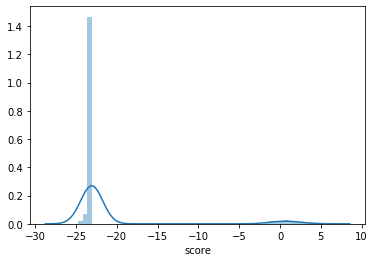

In [18]:
null_importance = null_Importance_maker.all_flow()
sns.distplot(null_importance['score'])
new_cols = null_importance[null_importance['score']>-15].col.tolist()
print(new_cols)

In [19]:
feature = ['client', 'code', 'machinelearn', 'softwar', 'model', 'data', 'engin', 'market', 'sale', 'busi', 'algorithm', 'consult',
           'manag', 'use', 'referr', 'email', 'provid', 'extern', 'dynam', 'relat', 'educ', 'scope', 'transform', 'member', 'tool',
           'servic', 'analysi', 'analyt', 'specif', 'propos', 'engag', 'log', 'system', 'test', 'complianc', 'appli', 'help', 'defin',
           'price', 'new', 'term', 'map', 'product', 'implement', 'advis', 'sell', 'problem', 'exist', 'board', 'architectur', 'detail',
           'develop', 'throughout', 'assist', 'prospect', 'build', 'qualifi', 'assess', 'perform', 'custom', 'direct', 'logic', 'result',
           'facilit', 'project', 'non', 'interfac', 'requir', 'integr', 'hardwar', 'concept', 'go', 'payrol', 'valid', 'abil', 'will',
           'meet', 'skill', 'plan', 'technic', 'profession', 'process', 'machin', 'troubleshoot', 'qualiti', 'account', 'techniqu',
           'write', 'train', 'pre', 'lead', 'agil', 'polici', 'report', 'advisor', 'applic', 'leadership', 'issu', 'wide', 'deliveri', 
           'creat', 'discoveri', 'secur', 'upgrad', 'optim', 'devop', 'rule', 'work', 'risk', 'contract', 'collabor', 'identifi',
           'autom', 'must', 'stakehold', 'leverag', 'multipl', 'compani', 'review', 'infrastructur', 'mentor', 'follow', 'coordin',
           'platform', 'cloud', 'stream', 'show', 'featur', 'learn', 'environ', 'research', 'agre', 'relationship', 'region', 'util',
           'visual', 'instal', 'present', 'achiev', 'practic', 'independ', 'demonstr', 'determin', 'sourc', 'resolut', 'need', 'predict',
           'deploy', 'maintain', 'modul', 'global', 'statist', 'organ', 'event', 'oper', 'understand', 'erp', 'solv', 'program', 'scienc',
           'abl', 'improv', 'team', 'necessari', 'effect', 'deliv', 'guidanc', 'technolog', 'particip', 'knowledg', 'complet', 'sql',
           'within', 'function', 'initi', 'set', 'benefit', 'unit', 'control', 'vendor', 'make', 'across', 'accord', 'activ', 'conduct',
           'complex', 'may', 'retail', 'industri', 'innov', 'potenti', 'assign', 'design', 'feder', 'partner', 'studi', 'solut', 'network',
           'cross', 'workflow', 'prototyp', 'contribut', 'close', 'posit', 'support', 'analyz', 'cost', 'person', 'level', 'materi',
           'matter', 'continu', 'act', 'procedur', 'user', 'databas', 'request', 'best', 'flow', 'action', 'standard', 'front', 'translat',
           'execut', 'addit', 'insight', 'small', 'updat', 'schedul', 'high', 'task', 'inform', 'post', 'equip', 'key', 'time', 'via',
           'gain', 'gener', 'field', 'current', 'confer', 'order', 'escal', 'case', 'monitor', 'larg', 'scalabl', 'state', 'share', 
           'deliver', 'collect', 'drive', 'establish', 'python', 'effici', 'manufactur', 'repres', 'effort', 'scale', 'target',
           'expertis', 'method', 'impact', 'strategi', 'idea', 'resolv', 'interpret', 'statu', 'interact', 'enhanc', 'prepar', 
           'limit', 'base', 'opportun', 'evalu', 'configur', 'chang', 'goal', 'resourc', 'scientist', 'differ', 'avail', 'strateg',
           'well', 'architect', 'decis', 'recommend', 'relev', 'pipelin', 'variou', 'duti', 'advanc', 'appropri']
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2', 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's tweedie: 1.44368	valid_1's tweedie: 1.49093
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[282]	training's tweedie: 1.4322	valid_1's tweedie: 1.47939
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.41928	valid_1's tweedie: 1.45006
Early stopping, best iteration is:
[311]	training's tweedie: 1.43079	valid_1's tweedie: 1.44693
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.42362	valid_1's tweedie: 1.43415
Early stopping, best iteration is:
[484]	training's tweedie: 1.42438	valid_1's tweedie: 1.43342
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[259]	training's tweedie: 1.42999	valid_1's tweedie: 1.47634


[I 2020-08-19 21:10:32,057] Finished trial#0 with value: 0.8232884887207605 with parameters: {'tweedie_variance_power': 1.256027660198305, 'max_bin': 112, 'subsample': 0.6175400261426301, 'subsample_freq': 0.7810601355891733, 'learning_rate': 0.07144485100686865, 'num_leaves': 6, 'feature_fraction': 0.6408059578030236, 'bagging_freq': 1, 'min_child_samples': 72, 'lambda_l1': 0.028825750273991754, 'lambda_l2': 0.13885299990771713}. Best is trial#0 with value: 0.8232884887207605.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.8024	valid_1's tweedie: 1.90743
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	training's tweedie: 1.77339	valid_1's tweedie: 1.85456
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[196]	training's tweedie: 1.7445	valid_1's tweedie: 1.79847
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	training's tweedie: 1.74891	valid_1's tweedie: 1.79797
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[262]	training's tweedie: 1.72611	valid_1's tweedie: 1.82979


[I 2020-08-19 21:10:33,174] Finished trial#1 with value: 1.0095775267272895 with parameters: {'tweedie_variance_power': 1.5746643312503554, 'max_bin': 179, 'subsample': 0.6401000333909808, 'subsample_freq': 0.48883809048128984, 'learning_rate': 0.03853179783482521, 'num_leaves': 10, 'feature_fraction': 0.5452073907521056, 'bagging_freq': 2, 'min_child_samples': 47, 'lambda_l1': 0.2933861222646808, 'lambda_l2': 0.2694661955764153}. Best is trial#0 with value: 0.8232884887207605.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 2.10924	valid_1's tweedie: 2.19993
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 2.07263	valid_1's tweedie: 2.16121
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.98934	valid_1's tweedie: 2.05473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 2.02567	valid_1's tweedie: 2.05764
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.98329	valid_1's tweedie: 2.07156


[I 2020-08-19 21:10:34,188] Finished trial#2 with value: 1.1444131589312267 with parameters: {'tweedie_variance_power': 1.6309256915311132, 'max_bin': 234, 'subsample': 0.648816364043981, 'subsample_freq': 0.8004601582462527, 'learning_rate': 0.10390189150694429, 'num_leaves': 10, 'feature_fraction': 0.731726817393166, 'bagging_freq': 1, 'min_child_samples': 35, 'lambda_l1': 0.0007963556763733384, 'lambda_l2': 0.34231953842295626}. Best is trial#0 with value: 0.8232884887207605.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.39505	valid_1's tweedie: 1.45229
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.3739	valid_1's tweedie: 1.40591
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.36209	valid_1's tweedie: 1.38609
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.37927	valid_1's tweedie: 1.38322
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[254]	training's tweedie: 1.32625	valid_1's tweedie: 1.40202


[I 2020-08-19 21:10:35,197] Finished trial#3 with value: 0.7943960776410351 with parameters: {'tweedie_variance_power': 1.3708659929487703, 'max_bin': 227, 'subsample': 0.548477972148685, 'subsample_freq': 0.6037089477885342, 'learning_rate': 0.4556858366641649, 'num_leaves': 4, 'feature_fraction': 0.723525695814945, 'bagging_freq': 1, 'min_child_samples': 52, 'lambda_l1': 0.009422756498561285, 'lambda_l2': 0.005159207402415246}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.60076	valid_1's tweedie: 1.63815
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[218]	training's tweedie: 1.60554	valid_1's tweedie: 1.61815
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[211]	training's tweedie: 1.60499	valid_1's tweedie: 1.61704
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's tweedie: 1.60696	valid_1's tweedie: 1.60582
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	training's tweedie: 1.60395	valid_1's tweedie: 1.63908


[I 2020-08-19 21:10:36,141] Finished trial#4 with value: 0.8996830097489668 with parameters: {'tweedie_variance_power': 1.1979139842518665, 'max_bin': 205, 'subsample': 0.8619327877165166, 'subsample_freq': 0.7057024553931965, 'learning_rate': 0.1958207639086756, 'num_leaves': 10, 'feature_fraction': 0.4686176308625497, 'bagging_freq': 6, 'min_child_samples': 55, 'lambda_l1': 7.483633795209544, 'lambda_l2': 0.0005212978086282788}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.80913	valid_1's tweedie: 1.89702
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.80528	valid_1's tweedie: 1.83972
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.6885	valid_1's tweedie: 1.7434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.7668	valid_1's tweedie: 1.76878
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.6507	valid_1's tweedie: 1.74635


[I 2020-08-19 21:10:37,054] Finished trial#5 with value: 0.9909561903927115 with parameters: {'tweedie_variance_power': 1.567044829880943, 'max_bin': 87, 'subsample': 0.8023582120612859, 'subsample_freq': 0.4722935121551472, 'learning_rate': 0.24717229567321247, 'num_leaves': 5, 'feature_fraction': 0.8730448646405199, 'bagging_freq': 1, 'min_child_samples': 42, 'lambda_l1': 0.00594540452472322, 'lambda_l2': 0.004141362157771291}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.37721	valid_1's tweedie: 2.42123
Early stopping, best iteration is:
[310]	training's tweedie: 2.38305	valid_1's tweedie: 2.41809
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.38341	valid_1's tweedie: 2.41507
Early stopping, best iteration is:
[329]	training's tweedie: 2.38817	valid_1's tweedie: 2.41103
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.38486	valid_1's tweedie: 2.39551
Early stopping, best iteration is:
[770]	training's tweedie: 2.37916	valid_1's tweedie: 2.39176
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.3874	valid_1's tweedie: 2.37895
[1000]	training's tweedie: 2.3785	valid_1's tweedie: 2.37681
Early stopping, best iteration is:
[991]	training's tweedie: 2.37881	valid_1's tweedie: 2.37639
Training until validation scores don't improve for 200 rounds
[5

[I 2020-08-19 21:10:38,296] Finished trial#6 with value: 1.2904901424400486 with parameters: {'tweedie_variance_power': 1.1061576702068163, 'max_bin': 272, 'subsample': 0.6767968119334572, 'subsample_freq': 0.5602049006473172, 'learning_rate': 0.033377721869426065, 'num_leaves': 5, 'feature_fraction': 0.7546234742214681, 'bagging_freq': 7, 'min_child_samples': 78, 'lambda_l1': 0.012068574763864389, 'lambda_l2': 0.0703264343271064}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's tweedie: 1.42019	valid_1's tweedie: 1.49823
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.43485	valid_1's tweedie: 1.47387
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.43515	valid_1's tweedie: 1.46661
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.46436	valid_1's tweedie: 1.45674
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.43907	valid_1's tweedie: 1.47301


[I 2020-08-19 21:10:39,219] Finished trial#7 with value: 0.8260655749297346 with parameters: {'tweedie_variance_power': 1.2466905113439315, 'max_bin': 243, 'subsample': 0.4877879507455938, 'subsample_freq': 0.84013567757382, 'learning_rate': 0.46154287794769383, 'num_leaves': 4, 'feature_fraction': 0.8559491491635864, 'bagging_freq': 3, 'min_child_samples': 28, 'lambda_l1': 0.045085205399246785, 'lambda_l2': 2.801188647727007}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.80885	valid_1's tweedie: 1.88195
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.80997	valid_1's tweedie: 1.84695
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.72412	valid_1's tweedie: 1.78683
Early stopping, best iteration is:
[406]	training's tweedie: 1.73641	valid_1's tweedie: 1.78233
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[227]	training's tweedie: 1.76663	valid_1's tweedie: 1.77283
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's tweedie: 1.76286	valid_1's tweedie: 1.80959


[I 2020-08-19 21:10:40,261] Finished trial#8 with value: 1.0030194270164534 with parameters: {'tweedie_variance_power': 1.5713237929296398, 'max_bin': 263, 'subsample': 0.737048630997474, 'subsample_freq': 0.451939880133776, 'learning_rate': 0.0563983223871511, 'num_leaves': 7, 'feature_fraction': 0.40792241916250527, 'bagging_freq': 7, 'min_child_samples': 78, 'lambda_l1': 0.00028804258212140096, 'lambda_l2': 1.353588822213598}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 2.58045	valid_1's tweedie: 2.69706
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 2.51929	valid_1's tweedie: 2.59808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's tweedie: 2.4343	valid_1's tweedie: 2.49803
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	training's tweedie: 2.45153	valid_1's tweedie: 2.50859
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 2.46851	valid_1's tweedie: 2.55704


[I 2020-08-19 21:10:41,393] Finished trial#9 with value: 1.3773196227448654 with parameters: {'tweedie_variance_power': 1.6937486067739331, 'max_bin': 256, 'subsample': 0.7176445625739487, 'subsample_freq': 0.4355440808622621, 'learning_rate': 0.04210327026741607, 'num_leaves': 10, 'feature_fraction': 0.8840491167800018, 'bagging_freq': 1, 'min_child_samples': 52, 'lambda_l1': 0.0023975581118168107, 'lambda_l2': 2.0833383692742644}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's tweedie: 1.42031	valid_1's tweedie: 1.47603
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.39979	valid_1's tweedie: 1.40922
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.38106	valid_1's tweedie: 1.41568
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.38636	valid_1's tweedie: 1.40672
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.40378	valid_1's tweedie: 1.43004


[I 2020-08-19 21:10:42,367] Finished trial#10 with value: 0.802475637820959 with parameters: {'tweedie_variance_power': 1.400854711794554, 'max_bin': 149, 'subsample': 0.4109247107178615, 'subsample_freq': 0.6261013018432108, 'learning_rate': 0.4321045198818185, 'num_leaves': 8, 'feature_fraction': 0.9668552773604988, 'bagging_freq': 4, 'min_child_samples': 7, 'lambda_l1': 0.5797770871139937, 'lambda_l2': 0.007073500440669556}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.38351	valid_1's tweedie: 1.45711
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.39902	valid_1's tweedie: 1.42311
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.39273	valid_1's tweedie: 1.41626
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.3871	valid_1's tweedie: 1.39921
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 1.39962	valid_1's tweedie: 1.43859


[I 2020-08-19 21:10:43,354] Finished trial#11 with value: 0.8009393451075646 with parameters: {'tweedie_variance_power': 1.3869916961727446, 'max_bin': 138, 'subsample': 0.42670331990881827, 'subsample_freq': 0.6202398375620438, 'learning_rate': 0.4993685560589623, 'num_leaves': 8, 'feature_fraction': 0.9893029221441769, 'bagging_freq': 5, 'min_child_samples': 8, 'lambda_l1': 1.2430655259750993, 'lambda_l2': 0.005776124455701925}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.50606	valid_1's tweedie: 1.55634
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.51745	valid_1's tweedie: 1.50574
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's tweedie: 1.48346	valid_1's tweedie: 1.4971
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.46983	valid_1's tweedie: 1.4743
Early stopping, best iteration is:
[541]	training's tweedie: 1.46651	valid_1's tweedie: 1.46882
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's tweedie: 1.504	valid_1's tweedie: 1.515


[I 2020-08-19 21:10:44,333] Finished trial#12 with value: 0.851707969342217 with parameters: {'tweedie_variance_power': 1.4130224755020577, 'max_bin': 151, 'subsample': 0.5302610030868283, 'subsample_freq': 0.6154201145473256, 'learning_rate': 0.2838253277872146, 'num_leaves': 7, 'feature_fraction': 0.6199815620894361, 'bagging_freq': 5, 'min_child_samples': 97, 'lambda_l1': 0.9572422447924552, 'lambda_l2': 0.00015423546991438105}. Best is trial#3 with value: 0.7943960776410351.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.3573	valid_1's tweedie: 1.41401
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's tweedie: 1.32633	valid_1's tweedie: 1.37889
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's tweedie: 1.32219	valid_1's tweedie: 1.38567
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's tweedie: 1.33184	valid_1's tweedie: 1.37193
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.32492	valid_1's tweedie: 1.41277


[I 2020-08-19 21:10:45,265] Finished trial#13 with value: 0.7845225443325309 with parameters: {'tweedie_variance_power': 1.3395483271917263, 'max_bin': 299, 'subsample': 0.40882263977898065, 'subsample_freq': 0.7167151734326462, 'learning_rate': 0.46481120961656736, 'num_leaves': 8, 'feature_fraction': 0.9839722077018085, 'bagging_freq': 5, 'min_child_samples': 10, 'lambda_l1': 7.742873538735159, 'lambda_l2': 0.008672875239670249}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.38494	valid_1's tweedie: 1.42889
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.39123	valid_1's tweedie: 1.40242
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's tweedie: 1.37805	valid_1's tweedie: 1.39848
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's tweedie: 1.37733	valid_1's tweedie: 1.38885
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.38167	valid_1's tweedie: 1.42204


[I 2020-08-19 21:10:46,158] Finished trial#14 with value: 0.7903874187617144 with parameters: {'tweedie_variance_power': 1.3150891643447837, 'max_bin': 300, 'subsample': 0.5039424675555277, 'subsample_freq': 0.7159501163405138, 'learning_rate': 0.3206033151591578, 'num_leaves': 8, 'feature_fraction': 0.7854071465277712, 'bagging_freq': 4, 'min_child_samples': 24, 'lambda_l1': 8.82482598788541, 'lambda_l2': 0.0009770123866867072}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.38817	valid_1's tweedie: 1.43093
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	training's tweedie: 1.39244	valid_1's tweedie: 1.40644
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	training's tweedie: 1.38172	valid_1's tweedie: 1.40096
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 1.38887	valid_1's tweedie: 1.39951
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[121]	training's tweedie: 1.37776	valid_1's tweedie: 1.42464


[I 2020-08-19 21:10:47,093] Finished trial#15 with value: 0.7946101417493003 with parameters: {'tweedie_variance_power': 1.3139921331266078, 'max_bin': 298, 'subsample': 0.4579676040720202, 'subsample_freq': 0.7082187884987117, 'learning_rate': 0.1597988860577105, 'num_leaves': 8, 'feature_fraction': 0.7871027861619452, 'bagging_freq': 4, 'min_child_samples': 19, 'lambda_l1': 9.63668464015608, 'lambda_l2': 0.0008764610656040438}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 2.46036	valid_1's tweedie: 2.50304
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 2.47371	valid_1's tweedie: 2.49449
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 2.46991	valid_1's tweedie: 2.49144
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 2.46824	valid_1's tweedie: 2.47783
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 2.46596	valid_1's tweedie: 2.50492


[I 2020-08-19 21:10:48,004] Finished trial#16 with value: 1.3346874889847626 with parameters: {'tweedie_variance_power': 1.1007957896096359, 'max_bin': 297, 'subsample': 0.5448149605836126, 'subsample_freq': 0.8912022048686659, 'learning_rate': 0.30029195470898057, 'num_leaves': 9, 'feature_fraction': 0.9620115139409066, 'bagging_freq': 5, 'min_child_samples': 19, 'lambda_l1': 6.150851487323466, 'lambda_l2': 0.016941329886502}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.41754	valid_1's tweedie: 1.55619
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.49358	valid_1's tweedie: 1.53155
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.48028	valid_1's tweedie: 1.50129
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.44669	valid_1's tweedie: 1.48077
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.42838	valid_1's tweedie: 1.4989


[I 2020-08-19 21:10:48,981] Finished trial#17 with value: 0.8486495669598711 with parameters: {'tweedie_variance_power': 1.4621270344498152, 'max_bin': 53, 'subsample': 0.4023362303083132, 'subsample_freq': 0.708249197406447, 'learning_rate': 0.3535454126345024, 'num_leaves': 9, 'feature_fraction': 0.8462663382721555, 'bagging_freq': 3, 'min_child_samples': 18, 'lambda_l1': 2.675394828544666, 'lambda_l2': 0.000878172814829948}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.5104	valid_1's tweedie: 1.59564
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.52058	valid_1's tweedie: 1.54808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.48815	valid_1's tweedie: 1.52559
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.45196	valid_1's tweedie: 1.518
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.44905	valid_1's tweedie: 1.51262


[I 2020-08-19 21:10:50,015] Finished trial#18 with value: 0.859892537577328 with parameters: {'tweedie_variance_power': 1.4746537448427919, 'max_bin': 300, 'subsample': 0.5078700397339565, 'subsample_freq': 0.7548134282289718, 'learning_rate': 0.12660434715259467, 'num_leaves': 9, 'feature_fraction': 0.9233917694438661, 'bagging_freq': 6, 'min_child_samples': 10, 'lambda_l1': 0.10470877100048244, 'lambda_l2': 0.00011450620595913168}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's tweedie: 1.7764	valid_1's tweedie: 1.83493
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.75834	valid_1's tweedie: 1.8114
Early stopping, best iteration is:
[390]	training's tweedie: 1.76375	valid_1's tweedie: 1.80721
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's tweedie: 1.77854	valid_1's tweedie: 1.81938
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's tweedie: 1.77926	valid_1's tweedie: 1.80295
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[255]	training's tweedie: 1.76742	valid_1's tweedie: 1.82342


[I 2020-08-19 21:10:51,145] Finished trial#19 with value: 0.9969868497986404 with parameters: {'tweedie_variance_power': 1.1592971341290066, 'max_bin': 280, 'subsample': 0.587580959008634, 'subsample_freq': 0.8738752676778048, 'learning_rate': 0.21156245870174634, 'num_leaves': 7, 'feature_fraction': 0.8025668641990075, 'bagging_freq': 3, 'min_child_samples': 29, 'lambda_l1': 3.4386396487909954, 'lambda_l2': 0.019998377608412988}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.38559	valid_1's tweedie: 1.44526
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 1.36642	valid_1's tweedie: 1.39393
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.3929	valid_1's tweedie: 1.40384
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.37403	valid_1's tweedie: 1.39756
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.37407	valid_1's tweedie: 1.40231


[I 2020-08-19 21:10:52,071] Finished trial#20 with value: 0.7952162163622506 with parameters: {'tweedie_variance_power': 1.3018869705283536, 'max_bin': 206, 'subsample': 0.43766442911218273, 'subsample_freq': 0.541622802644271, 'learning_rate': 0.35461660725675287, 'num_leaves': 6, 'feature_fraction': 0.6429053741036949, 'bagging_freq': 6, 'min_child_samples': 28, 'lambda_l1': 0.2348817199756975, 'lambda_l2': 0.0020182929445486547}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.36599	valid_1's tweedie: 1.43711
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.3401	valid_1's tweedie: 1.42371
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.3784	valid_1's tweedie: 1.36938
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's tweedie: 1.33767	valid_1's tweedie: 1.35071
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.38206	valid_1's tweedie: 1.42472


[I 2020-08-19 21:10:53,020] Finished trial#21 with value: 0.7918278437278573 with parameters: {'tweedie_variance_power': 1.3540806438184616, 'max_bin': 223, 'subsample': 0.5683824697410554, 'subsample_freq': 0.6777354857090787, 'learning_rate': 0.4947700951887722, 'num_leaves': 8, 'feature_fraction': 0.6962457501933101, 'bagging_freq': 4, 'min_child_samples': 60, 'lambda_l1': 0.002826037175451754, 'lambda_l2': 0.00030228175442123637}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.4085	valid_1's tweedie: 1.45546
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.45146	valid_1's tweedie: 1.46511
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.39023	valid_1's tweedie: 1.4241
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[222]	training's tweedie: 1.36627	valid_1's tweedie: 1.40741
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's tweedie: 1.35977	valid_1's tweedie: 1.44042


[I 2020-08-19 21:10:54,017] Finished trial#22 with value: 0.814438916789474 with parameters: {'tweedie_variance_power': 1.3017866347873865, 'max_bin': 284, 'subsample': 0.4778837928795265, 'subsample_freq': 0.6835927274901918, 'learning_rate': 0.3943241461967382, 'num_leaves': 8, 'feature_fraction': 0.5433584940430142, 'bagging_freq': 4, 'min_child_samples': 65, 'lambda_l1': 0.00010744271198433929, 'lambda_l2': 0.00032846761389677764}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.38672	valid_1's tweedie: 1.43253
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.36919	valid_1's tweedie: 1.41888
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.3596	valid_1's tweedie: 1.3825
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's tweedie: 1.32785	valid_1's tweedie: 1.36701
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.35748	valid_1's tweedie: 1.41422


[I 2020-08-19 21:10:54,974] Finished trial#23 with value: 0.7924466019147893 with parameters: {'tweedie_variance_power': 1.3479478188365084, 'max_bin': 210, 'subsample': 0.5766238272205357, 'subsample_freq': 0.7532964612833476, 'learning_rate': 0.4944942797318656, 'num_leaves': 9, 'feature_fraction': 0.6870993044213564, 'bagging_freq': 5, 'min_child_samples': 63, 'lambda_l1': 0.0005326690700569191, 'lambda_l2': 0.0016728544112792271}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's tweedie: 1.60573	valid_1's tweedie: 1.70351
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.65265	valid_1's tweedie: 1.65864
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	training's tweedie: 1.58523	valid_1's tweedie: 1.62955
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 1.61949	valid_1's tweedie: 1.61462
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	training's tweedie: 1.59913	valid_1's tweedie: 1.64378


[I 2020-08-19 21:10:55,939] Finished trial#24 with value: 0.9232717653597129 with parameters: {'tweedie_variance_power': 1.4936686049061356, 'max_bin': 179, 'subsample': 0.5867476907026058, 'subsample_freq': 0.6661272191370564, 'learning_rate': 0.2824803726162569, 'num_leaves': 8, 'feature_fraction': 0.5771104069210972, 'bagging_freq': 3, 'min_child_samples': 96, 'lambda_l1': 0.0032373857488983797, 'lambda_l2': 0.00028392105724332013}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.48403	valid_1's tweedie: 1.53305
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.46762	valid_1's tweedie: 1.50227
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.49356	valid_1's tweedie: 1.49569
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.46664	valid_1's tweedie: 1.4872
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.48497	valid_1's tweedie: 1.51553


[I 2020-08-19 21:10:56,879] Finished trial#25 with value: 0.8446431996424476 with parameters: {'tweedie_variance_power': 1.2343378747338372, 'max_bin': 253, 'subsample': 0.513502614103602, 'subsample_freq': 0.7392682674674272, 'learning_rate': 0.35728742385907597, 'num_leaves': 6, 'feature_fraction': 0.6841689104393466, 'bagging_freq': 4, 'min_child_samples': 43, 'lambda_l1': 0.0009839121941224698, 'lambda_l2': 0.00010012888430518451}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.46066	valid_1's tweedie: 1.49416
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.44073	valid_1's tweedie: 1.46048
Early stopping, best iteration is:
[373]	training's tweedie: 1.44479	valid_1's tweedie: 1.45587
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's tweedie: 1.44691	valid_1's tweedie: 1.45058
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.43279	valid_1's tweedie: 1.43277
Early stopping, best iteration is:
[395]	training's tweedie: 1.43459	valid_1's tweedie: 1.42874
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[213]	training's tweedie: 1.44455	valid_1's tweedie: 1.46193


[I 2020-08-19 21:10:57,907] Finished trial#26 with value: 0.8263674594344195 with parameters: {'tweedie_variance_power': 1.313206570476968, 'max_bin': 225, 'subsample': 0.46589796780981235, 'subsample_freq': 0.7896338375910503, 'learning_rate': 0.19187524889849347, 'num_leaves': 7, 'feature_fraction': 0.801309697639339, 'bagging_freq': 5, 'min_child_samples': 85, 'lambda_l1': 2.5601727899368654, 'lambda_l2': 0.0020984950576372918}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.73998	valid_1's tweedie: 1.78442
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.73164	valid_1's tweedie: 1.77245
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.74807	valid_1's tweedie: 1.75844
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.73873	valid_1's tweedie: 1.73487
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.73874	valid_1's tweedie: 1.77586


[I 2020-08-19 21:10:58,906] Finished trial#27 with value: 0.9731911720705466 with parameters: {'tweedie_variance_power': 1.168602086247651, 'max_bin': 282, 'subsample': 0.5664412480063087, 'subsample_freq': 0.6555833352612094, 'learning_rate': 0.31139158830486824, 'num_leaves': 9, 'feature_fraction': 0.9226546925872987, 'bagging_freq': 2, 'min_child_samples': 62, 'lambda_l1': 0.00014342825586446053, 'lambda_l2': 0.03008444616235608}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.39818	valid_1's tweedie: 1.52801
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.4628	valid_1's tweedie: 1.47541
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.41604	valid_1's tweedie: 1.45612
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.43324	valid_1's tweedie: 1.47426
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.38923	valid_1's tweedie: 1.42748


[I 2020-08-19 21:10:59,899] Finished trial#28 with value: 0.8284190614727978 with parameters: {'tweedie_variance_power': 1.4277937866765298, 'max_bin': 269, 'subsample': 0.4038275476298032, 'subsample_freq': 0.5738965888787373, 'learning_rate': 0.23745876579989336, 'num_leaves': 8, 'feature_fraction': 0.7599930572348019, 'bagging_freq': 6, 'min_child_samples': 14, 'lambda_l1': 0.002080152603613277, 'lambda_l2': 0.011835181646491652}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.41759	valid_1's tweedie: 1.48241
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.43619	valid_1's tweedie: 1.45866
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 1.42296	valid_1's tweedie: 1.4432
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.42821	valid_1's tweedie: 1.4301
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's tweedie: 1.4097	valid_1's tweedie: 1.45455


[I 2020-08-19 21:11:00,920] Finished trial#29 with value: 0.8161099363707724 with parameters: {'tweedie_variance_power': 1.2570318327594405, 'max_bin': 100, 'subsample': 0.6095880934004742, 'subsample_freq': 0.8292741549880659, 'learning_rate': 0.0836827254515485, 'num_leaves': 7, 'feature_fraction': 0.6380252659407561, 'bagging_freq': 4, 'min_child_samples': 38, 'lambda_l1': 0.029725588253468035, 'lambda_l2': 0.08669857557771603}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.37292	valid_1's tweedie: 1.45987
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.44295	valid_1's tweedie: 1.47369
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.33645	valid_1's tweedie: 1.43674
Early stopping, best iteration is:
[350]	training's tweedie: 1.35154	valid_1's tweedie: 1.42484
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.34462	valid_1's tweedie: 1.40392
Early stopping, best iteration is:
[352]	training's tweedie: 1.35929	valid_1's tweedie: 1.38906
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[244]	training's tweedie: 1.35302	valid_1's tweedie: 1.41176


[I 2020-08-19 21:11:02,065] Finished trial#30 with value: 0.8124750401799992 with parameters: {'tweedie_variance_power': 1.35712981486181, 'max_bin': 300, 'subsample': 0.5040440948386059, 'subsample_freq': 0.7400808627423778, 'learning_rate': 0.1479461609076576, 'num_leaves': 8, 'feature_fraction': 0.8297250703538649, 'bagging_freq': 2, 'min_child_samples': 69, 'lambda_l1': 0.0956393410162624, 'lambda_l2': 0.0009389191024780862}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.38288	valid_1's tweedie: 1.44024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.35906	valid_1's tweedie: 1.40863
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.35609	valid_1's tweedie: 1.37978
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.37025	valid_1's tweedie: 1.36806
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.33553	valid_1's tweedie: 1.41889


[I 2020-08-19 21:11:03,059] Finished trial#31 with value: 0.7928353861885495 with parameters: {'tweedie_variance_power': 1.3447626629348486, 'max_bin': 207, 'subsample': 0.610072589441723, 'subsample_freq': 0.7685756560518902, 'learning_rate': 0.48844301037728993, 'num_leaves': 9, 'feature_fraction': 0.7048985767275513, 'bagging_freq': 5, 'min_child_samples': 59, 'lambda_l1': 0.00029758771883419506, 'lambda_l2': 0.0022338924353678792}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.41508	valid_1's tweedie: 1.46556
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.40183	valid_1's tweedie: 1.44497
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.39879	valid_1's tweedie: 1.42118
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[171]	training's tweedie: 1.35071	valid_1's tweedie: 1.40431
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.39816	valid_1's tweedie: 1.44816


[I 2020-08-19 21:11:04,124] Finished trial#32 with value: 0.8139552500229925 with parameters: {'tweedie_variance_power': 1.2756432815150895, 'max_bin': 186, 'subsample': 0.6728081720085798, 'subsample_freq': 0.6814293871996249, 'learning_rate': 0.48565958911899176, 'num_leaves': 9, 'feature_fraction': 0.6786809026995275, 'bagging_freq': 5, 'min_child_samples': 75, 'lambda_l1': 0.0007816583782627231, 'lambda_l2': 0.0015816230224378655}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.58083	valid_1's tweedie: 1.67401
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.56009	valid_1's tweedie: 1.65369
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	training's tweedie: 1.5143	valid_1's tweedie: 1.58834
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's tweedie: 1.54379	valid_1's tweedie: 1.53246
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.54017	valid_1's tweedie: 1.6094


[I 2020-08-19 21:11:05,206] Finished trial#33 with value: 0.8982489184335055 with parameters: {'tweedie_variance_power': 1.5108553425766555, 'max_bin': 195, 'subsample': 0.5678742769808234, 'subsample_freq': 0.8073732627903067, 'learning_rate': 0.38692597163343834, 'num_leaves': 9, 'feature_fraction': 0.5987165662288065, 'bagging_freq': 4, 'min_child_samples': 68, 'lambda_l1': 0.00036836138895219895, 'lambda_l2': 0.0002785662606302538}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's tweedie: 1.37461	valid_1's tweedie: 1.46287
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's tweedie: 1.45249	valid_1's tweedie: 1.46987
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.41166	valid_1's tweedie: 1.43852
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.42568	valid_1's tweedie: 1.417
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[212]	training's tweedie: 1.33674	valid_1's tweedie: 1.43174


[I 2020-08-19 21:11:06,260] Finished trial#34 with value: 0.8211225498223758 with parameters: {'tweedie_variance_power': 1.349379757690196, 'max_bin': 217, 'subsample': 0.6395479228557237, 'subsample_freq': 0.7308887908970545, 'learning_rate': 0.4904013986997427, 'num_leaves': 8, 'feature_fraction': 0.6650737107895258, 'bagging_freq': 5, 'min_child_samples': 87, 'lambda_l1': 0.0010960827591466908, 'lambda_l2': 0.0005263233488997772}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.40177	valid_1's tweedie: 1.46514
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's tweedie: 1.32659	valid_1's tweedie: 1.40875
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.37575	valid_1's tweedie: 1.3774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.32762	valid_1's tweedie: 1.38193
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.36407	valid_1's tweedie: 1.4067


[I 2020-08-19 21:11:07,345] Finished trial#35 with value: 0.7971395006178392 with parameters: {'tweedie_variance_power': 1.3783345681091344, 'max_bin': 161, 'subsample': 0.539838874341022, 'subsample_freq': 0.7737973836637619, 'learning_rate': 0.3963625461970045, 'num_leaves': 10, 'feature_fraction': 0.7266071759968291, 'bagging_freq': 6, 'min_child_samples': 47, 'lambda_l1': 0.014569484992757696, 'lambda_l2': 0.0032744230481833456}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	training's tweedie: 1.53441	valid_1's tweedie: 1.60607
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[256]	training's tweedie: 1.52896	valid_1's tweedie: 1.59044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	training's tweedie: 1.54422	valid_1's tweedie: 1.58616
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	training's tweedie: 1.55323	valid_1's tweedie: 1.55054
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.56625	valid_1's tweedie: 1.598


[I 2020-08-19 21:11:08,479] Finished trial#36 with value: 0.8857543190894386 with parameters: {'tweedie_variance_power': 1.2093225570995303, 'max_bin': 241, 'subsample': 0.44211882471184694, 'subsample_freq': 0.7126739650512165, 'learning_rate': 0.32501198334404985, 'num_leaves': 8, 'feature_fraction': 0.5735056751317125, 'bagging_freq': 3, 'min_child_samples': 56, 'lambda_l1': 0.0005576479580053853, 'lambda_l2': 0.001177215028433154}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.44355	valid_1's tweedie: 1.51279
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.45441	valid_1's tweedie: 1.46582
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.44127	valid_1's tweedie: 1.44529
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.46245	valid_1's tweedie: 1.44676
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.43966	valid_1's tweedie: 1.44785


[I 2020-08-19 21:11:09,526] Finished trial#37 with value: 0.8253395208371673 with parameters: {'tweedie_variance_power': 1.436196926172226, 'max_bin': 129, 'subsample': 0.628351737441725, 'subsample_freq': 0.6558694459079442, 'learning_rate': 0.4206815658690816, 'num_leaves': 10, 'feature_fraction': 0.47795909493748095, 'bagging_freq': 4, 'min_child_samples': 48, 'lambda_l1': 0.006943729997476054, 'lambda_l2': 0.009276245214002107}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.64602	valid_1's tweedie: 1.73043
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.62341	valid_1's tweedie: 1.66391
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.59924	valid_1's tweedie: 1.64232
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.5937	valid_1's tweedie: 1.62395
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[131]	training's tweedie: 1.51196	valid_1's tweedie: 1.65582


[I 2020-08-19 21:11:10,687] Finished trial#38 with value: 0.9212056641404004 with parameters: {'tweedie_variance_power': 1.5274143629641588, 'max_bin': 170, 'subsample': 0.5708570712217482, 'subsample_freq': 0.6850592742365993, 'learning_rate': 0.2391914377140181, 'num_leaves': 9, 'feature_fraction': 0.7548412109692401, 'bagging_freq': 5, 'min_child_samples': 34, 'lambda_l1': 0.004220204190664753, 'lambda_l2': 9.152844781624754}. Best is trial#13 with value: 0.7845225443325309.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's tweedie: 1.4067	valid_1's tweedie: 1.44646
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.35847	valid_1's tweedie: 1.40934
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.38036	valid_1's tweedie: 1.37855
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.32858	valid_1's tweedie: 1.36207
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.36522	valid_1's tweedie: 1.40798


[I 2020-08-19 21:11:11,715] Finished trial#39 with value: 0.7920539688454231 with parameters: {'tweedie_variance_power': 1.3355556216414564, 'max_bin': 228, 'subsample': 0.6706479452627795, 'subsample_freq': 0.840978531542208, 'learning_rate': 0.4962381227044486, 'num_leaves': 7, 'feature_fraction': 0.7037873534716095, 'bagging_freq': 6, 'min_child_samples': 62, 'lambda_l1': 0.0002111809324326842, 'lambda_l2': 0.0005278837015550272}. Best is trial#13 with value: 0.7845225443325309.


0.7845225443325309
{'tweedie_variance_power': 1.3395483271917263, 'max_bin': 299, 'subsample': 0.40882263977898065, 'subsample_freq': 0.7167151734326462, 'learning_rate': 0.46481120961656736, 'num_leaves': 8, 'feature_fraction': 0.9839722077018085, 'bagging_freq': 5, 'min_child_samples': 10, 'lambda_l1': 7.742873538735159, 'lambda_l2': 0.008672875239670249}


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.3573	valid_1's tweedie: 1.41401
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's tweedie: 1.32633	valid_1's tweedie: 1.37889
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's tweedie: 1.32219	valid_1's tweedie: 1.38567
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's tweedie: 1.33184	valid_1's tweedie: 1.37193
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.32492	valid_1's tweedie: 1.41277
0.6874786762197203


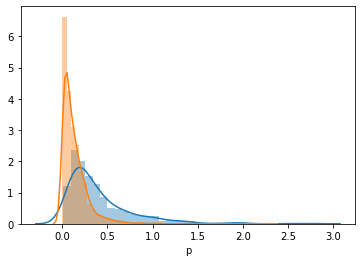

In [20]:
PARAMS={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    'tweedie_variance_power': 1.3395483271917263, 'max_bin': 299, 'subsample': 0.40882263977898065, 'subsample_freq': 0.7167151734326462, 
    'learning_rate': 0.46481120961656736, 'num_leaves': 8, 'feature_fraction': 0.9839722077018085, 'bagging_freq': 5,
    'min_child_samples': 10, 'lambda_l1': 7.742873538735159, 'lambda_l2': 0.008672875239670249
}

score = 0
k = StratifiedKFold(n_splits=5)
off_df=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_data = train_df.iloc[trn,:]
    val_data = train_df.iloc[val,:]
    
    train_set= lgb.Dataset(trn_data[new_cols],  trn_data['jobflag_2'])
    val_set = lgb.Dataset(val_data[new_cols],  val_data['jobflag_2'])   
    
    model = lgb.train(
        train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
        early_stopping_rounds=200, verbose_eval=500
    )
    
    val_data['p'] = model.predict(val_data[new_cols])
    off_df.append(val_data[['jobflag', 'jobflag_2', 'p']])
    
off_df = pd.concat(off_df, axis=0)
off_df['pred'] = off_df.p.apply(lambda x: 1 if x>0.15 else 0)

print(metrics.accuracy_score(off_df.jobflag_2, off_df.pred))

sns.distplot(off_df[off_df.jobflag_2==1].p)
sns.distplot(off_df[off_df.jobflag_2==0].p)

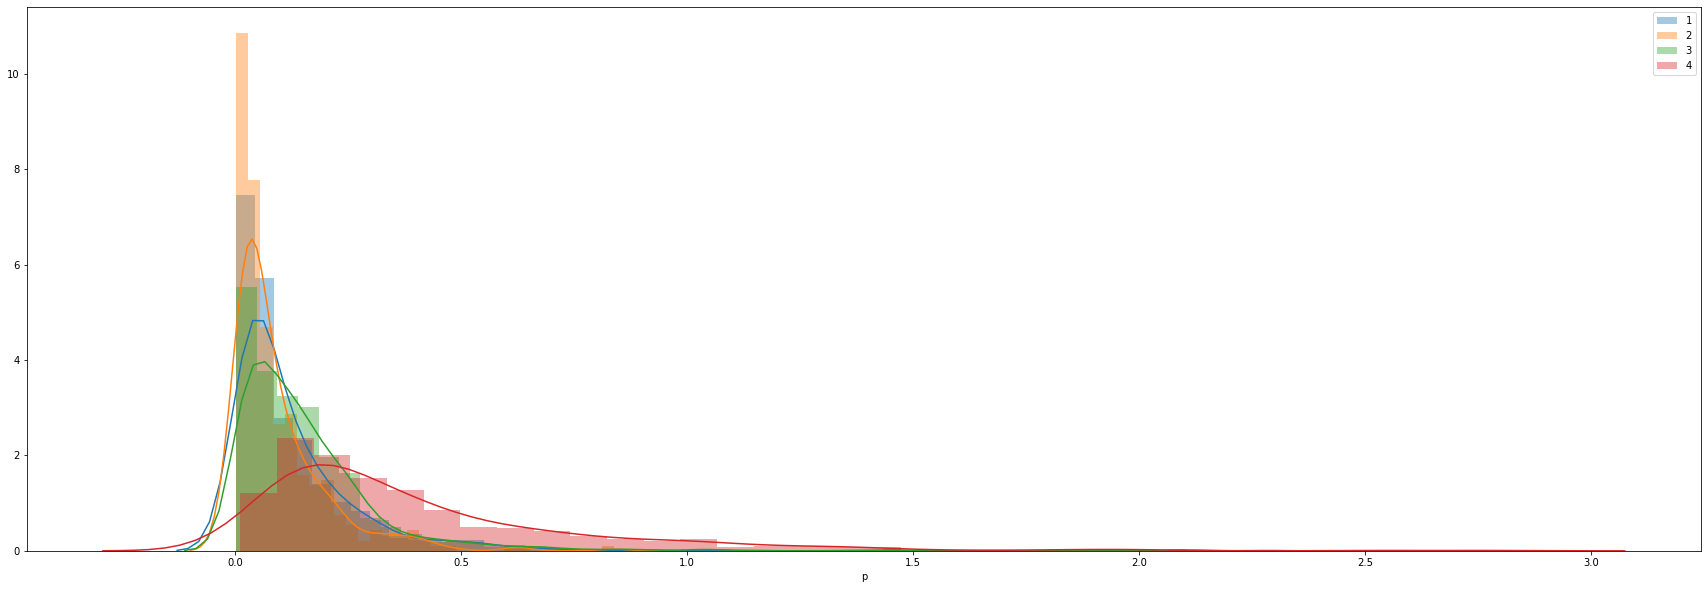

In [21]:
plt.figure(figsize=(30,10))
sns.distplot(off_df[off_df.jobflag==1].p, label='1')
sns.distplot(off_df[off_df.jobflag==2].p, label='2')
sns.distplot(off_df[off_df.jobflag==3].p, label='3')
sns.distplot(off_df[off_df.jobflag==4].p, label='4')
plt.legend()

#### label 1

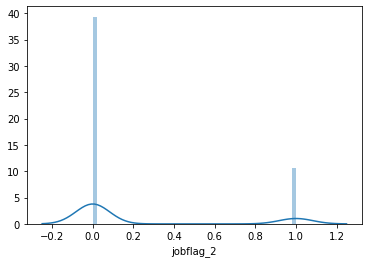

In [22]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==1 else 0)
sns.distplot(train_df.jobflag_2)

In [64]:
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
optimize_optuna = Optimize_by_Optuna(data=train_df, features=feature,target_colname= 'jobflag_2',target_name_2= 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_params)
print(study.best_value)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.42182	valid_1's tweedie: 1.47505
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.41658	valid_1's tweedie: 1.45536
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.38842	valid_1's tweedie: 1.45736
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.42679	valid_1's tweedie: 1.48558
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.41692	valid_1's tweedie: 1.45881


[I 2020-08-19 16:25:15,829] Finished trial#0 with value: 0.8210655258011456 with parameters: {'tweedie_variance_power': 1.3952535091429057, 'max_bin': 153, 'subsample': 0.7751764874504818, 'subsample_freq': 0.45380535117485143, 'learning_rate': 0.17351759879875367, 'num_leaves': 6, 'feature_fraction': 0.5636760754665906, 'bagging_freq': 2, 'min_child_samples': 48, 'lambda_l1': 0.01094927472698601, 'lambda_l2': 0.9396992256106341}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 2.22335	valid_1's tweedie: 2.28718
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 2.20416	valid_1's tweedie: 2.27341
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 2.1869	valid_1's tweedie: 2.27714
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 2.21409	valid_1's tweedie: 2.30162
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 2.12627	valid_1's tweedie: 2.22898


[I 2020-08-19 16:25:23,896] Finished trial#1 with value: 1.222297181838297 with parameters: {'tweedie_variance_power': 1.6442973673118173, 'max_bin': 177, 'subsample': 0.7389326787173576, 'subsample_freq': 0.5703655342159648, 'learning_rate': 0.10823630171080029, 'num_leaves': 5, 'feature_fraction': 0.7899611226119796, 'bagging_freq': 2, 'min_child_samples': 38, 'lambda_l1': 0.01216133263802021, 'lambda_l2': 0.00024263295372986858}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.52371	valid_1's tweedie: 1.55533
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.49133	valid_1's tweedie: 1.53832
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.5137	valid_1's tweedie: 1.52761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 1.48895	valid_1's tweedie: 1.54022
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 1.50241	valid_1's tweedie: 1.52909


[I 2020-08-19 16:25:31,935] Finished trial#2 with value: 0.8587872245142736 with parameters: {'tweedie_variance_power': 1.4252056019806192, 'max_bin': 131, 'subsample': 0.510501953736011, 'subsample_freq': 0.6964811959865771, 'learning_rate': 0.24349849087033817, 'num_leaves': 4, 'feature_fraction': 0.9736995044145774, 'bagging_freq': 5, 'min_child_samples': 76, 'lambda_l1': 3.178501859022925, 'lambda_l2': 0.12805985727634098}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 3.22633	valid_1's tweedie: 3.40433
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 3.26266	valid_1's tweedie: 3.35284
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[7]	training's tweedie: 3.30499	valid_1's tweedie: 3.43945
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	training's tweedie: 3.38816	valid_1's tweedie: 3.47251
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 3.15183	valid_1's tweedie: 3.33743


[I 2020-08-19 16:25:40,048] Finished trial#3 with value: 1.791058580224 with parameters: {'tweedie_variance_power': 1.753911544332436, 'max_bin': 158, 'subsample': 0.8453237785319226, 'subsample_freq': 0.4050067784406967, 'learning_rate': 0.281768572349683, 'num_leaves': 9, 'feature_fraction': 0.45809552134226694, 'bagging_freq': 6, 'min_child_samples': 40, 'lambda_l1': 0.029168112236248295, 'lambda_l2': 0.00161095799773255}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.59386	valid_1's tweedie: 4.61918
Early stopping, best iteration is:
[304]	training's tweedie: 4.60178	valid_1's tweedie: 4.61846
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.60438	valid_1's tweedie: 4.63456
Early stopping, best iteration is:
[482]	training's tweedie: 4.60493	valid_1's tweedie: 4.63419
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.60474	valid_1's tweedie: 4.62315
[1000]	training's tweedie: 4.59217	valid_1's tweedie: 4.62186
Early stopping, best iteration is:
[813]	training's tweedie: 4.59599	valid_1's tweedie: 4.62065
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 4.58766	valid_1's tweedie: 4.64009
Early stopping, best iteration is:
[396]	training's tweedie: 4.59143	valid_1's tweedie: 4.639
Training until validation scores don't improve for 200 rounds
[5

[I 2020-08-19 16:25:48,693] Finished trial#4 with value: 2.4009929692289242 with parameters: {'tweedie_variance_power': 1.0515592918991075, 'max_bin': 110, 'subsample': 0.6792708969135538, 'subsample_freq': 0.5744387638372283, 'learning_rate': 0.04446069626086224, 'num_leaves': 9, 'feature_fraction': 0.8460391982212108, 'bagging_freq': 2, 'min_child_samples': 74, 'lambda_l1': 3.638905783896287, 'lambda_l2': 7.366778897277973}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 3.03379	valid_1's tweedie: 3.13907
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 2.95423	valid_1's tweedie: 3.04019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 2.93719	valid_1's tweedie: 3.07837
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 3.03134	valid_1's tweedie: 3.14969
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 2.93187	valid_1's tweedie: 3.07768


[I 2020-08-19 16:25:56,856] Finished trial#5 with value: 1.6378893044118137 with parameters: {'tweedie_variance_power': 1.7353036360508534, 'max_bin': 281, 'subsample': 0.5747042321794547, 'subsample_freq': 0.5492652507252467, 'learning_rate': 0.05556942721193185, 'num_leaves': 9, 'feature_fraction': 0.7420438403549596, 'bagging_freq': 1, 'min_child_samples': 33, 'lambda_l1': 3.670905867236183, 'lambda_l2': 0.00011537448192935226}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	training's tweedie: 4.06722	valid_1's tweedie: 4.20177
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's tweedie: 4.25347	valid_1's tweedie: 4.29361
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's tweedie: 4.2178	valid_1's tweedie: 4.2497
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	training's tweedie: 4.11399	valid_1's tweedie: 4.23714
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	training's tweedie: 4.10321	valid_1's tweedie: 4.18452


[I 2020-08-19 16:26:04,944] Finished trial#6 with value: 2.2057194479862288 with parameters: {'tweedie_variance_power': 1.7923534637713314, 'max_bin': 255, 'subsample': 0.5491475683130751, 'subsample_freq': 0.645472176430653, 'learning_rate': 0.33687736395431095, 'num_leaves': 8, 'feature_fraction': 0.9990239306771329, 'bagging_freq': 6, 'min_child_samples': 53, 'lambda_l1': 0.00013550670924098192, 'lambda_l2': 0.11603447949885566}. Best is trial#0 with value: 0.8210655258011456.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.43214	valid_1's tweedie: 1.47329
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.42898	valid_1's tweedie: 1.46602
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.42248	valid_1's tweedie: 1.4572
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's tweedie: 1.4157	valid_1's tweedie: 1.47355
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36609	valid_1's tweedie: 1.46989
Early stopping, best iteration is:
[387]	training's tweedie: 1.37555	valid_1's tweedie: 1.46402


[I 2020-08-19 16:26:13,176] Finished trial#7 with value: 0.8197279465991238 with parameters: {'tweedie_variance_power': 1.2938255513284251, 'max_bin': 168, 'subsample': 0.6819198337866925, 'subsample_freq': 0.7020555975062388, 'learning_rate': 0.21699329645624615, 'num_leaves': 5, 'feature_fraction': 0.5201876051423964, 'bagging_freq': 1, 'min_child_samples': 32, 'lambda_l1': 5.767712469297831, 'lambda_l2': 0.0002941205620686089}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.44966	valid_1's tweedie: 1.49674
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.4388	valid_1's tweedie: 1.47443
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.43544	valid_1's tweedie: 1.47847
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.45181	valid_1's tweedie: 1.50669
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.44787	valid_1's tweedie: 1.47086


[I 2020-08-19 16:26:21,264] Finished trial#8 with value: 0.8327897646273044 with parameters: {'tweedie_variance_power': 1.4073747144483808, 'max_bin': 238, 'subsample': 0.8205992185547868, 'subsample_freq': 0.7404791696872566, 'learning_rate': 0.43354602376602014, 'num_leaves': 6, 'feature_fraction': 0.979111999599086, 'bagging_freq': 7, 'min_child_samples': 65, 'lambda_l1': 0.0007482266373738681, 'lambda_l2': 0.00026114763854321563}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.49969	valid_1's tweedie: 1.56359
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's tweedie: 1.49637	valid_1's tweedie: 1.52463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's tweedie: 1.45657	valid_1's tweedie: 1.52474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.53144	valid_1's tweedie: 1.57488
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's tweedie: 1.46777	valid_1's tweedie: 1.53093


[I 2020-08-19 16:26:29,463] Finished trial#9 with value: 0.860069826594356 with parameters: {'tweedie_variance_power': 1.454519967285343, 'max_bin': 228, 'subsample': 0.4203927989766305, 'subsample_freq': 0.8247680047624095, 'learning_rate': 0.10927453698019662, 'num_leaves': 4, 'feature_fraction': 0.4765968047191459, 'bagging_freq': 3, 'min_child_samples': 15, 'lambda_l1': 0.09684260527508541, 'lambda_l2': 1.923893934322153}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 2.3516	valid_1's tweedie: 2.40596
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's tweedie: 2.32258	valid_1's tweedie: 2.39642
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's tweedie: 2.35121	valid_1's tweedie: 2.39328
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[121]	training's tweedie: 2.33265	valid_1's tweedie: 2.41069
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[176]	training's tweedie: 2.31338	valid_1's tweedie: 2.39461


[I 2020-08-19 16:26:37,922] Finished trial#10 with value: 1.285728706030775 with parameters: {'tweedie_variance_power': 1.113512328176224, 'max_bin': 62, 'subsample': 0.6501086747773523, 'subsample_freq': 0.8735121536582288, 'learning_rate': 0.07140488295071724, 'num_leaves': 7, 'feature_fraction': 0.6103005257580115, 'bagging_freq': 1, 'min_child_samples': 6, 'lambda_l1': 0.2594635099642346, 'lambda_l2': 0.0028278555807748117}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.59437	valid_1's tweedie: 1.61819
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.57472	valid_1's tweedie: 1.62101
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.56982	valid_1's tweedie: 1.60447
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's tweedie: 1.55662	valid_1's tweedie: 1.61313
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.58502	valid_1's tweedie: 1.60392


[I 2020-08-19 16:26:46,050] Finished trial#11 with value: 0.8981858186267949 with parameters: {'tweedie_variance_power': 1.229554723354928, 'max_bin': 189, 'subsample': 0.7662259640757402, 'subsample_freq': 0.4007736976028998, 'learning_rate': 0.18867352837236967, 'num_leaves': 6, 'feature_fraction': 0.6054831524972688, 'bagging_freq': 3, 'min_child_samples': 94, 'lambda_l1': 0.0025645460373560107, 'lambda_l2': 1.3755260548093569}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.42842	valid_1's tweedie: 1.4929
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.42907	valid_1's tweedie: 1.46651
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.43095	valid_1's tweedie: 1.48008
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.44446	valid_1's tweedie: 1.49861
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.40389	valid_1's tweedie: 1.47602


[I 2020-08-19 16:26:54,134] Finished trial#12 with value: 0.8258501380067763 with parameters: {'tweedie_variance_power': 1.2735558382740604, 'max_bin': 88, 'subsample': 0.8928491556947096, 'subsample_freq': 0.46890002076955534, 'learning_rate': 0.16781998357463734, 'num_leaves': 5, 'feature_fraction': 0.5689883870808297, 'bagging_freq': 1, 'min_child_samples': 21, 'lambda_l1': 0.43989060160219307, 'lambda_l2': 0.009104843304201152}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.77206	valid_1's tweedie: 1.84054
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.76144	valid_1's tweedie: 1.78893
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.71361	valid_1's tweedie: 1.79934
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.76577	valid_1's tweedie: 1.86606
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.73709	valid_1's tweedie: 1.8105


[I 2020-08-19 16:27:02,192] Finished trial#13 with value: 1.0035177547455836 with parameters: {'tweedie_variance_power': 1.5577256163132227, 'max_bin': 201, 'subsample': 0.7550723999373276, 'subsample_freq': 0.7740866158441148, 'learning_rate': 0.15712461177566234, 'num_leaves': 6, 'feature_fraction': 0.4053853455251717, 'bagging_freq': 3, 'min_child_samples': 52, 'lambda_l1': 0.010823977333724736, 'lambda_l2': 0.41051948417112455}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 1.47197	valid_1's tweedie: 1.50114
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.43679	valid_1's tweedie: 1.49699
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.45028	valid_1's tweedie: 1.50113
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.48567	valid_1's tweedie: 1.51453
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.43847	valid_1's tweedie: 1.4915


[I 2020-08-19 16:27:10,322] Finished trial#14 with value: 0.8392354666546088 with parameters: {'tweedie_variance_power': 1.2702386855978902, 'max_bin': 141, 'subsample': 0.7055978296269347, 'subsample_freq': 0.6533352227127313, 'learning_rate': 0.38724257599860024, 'num_leaves': 5, 'feature_fraction': 0.5186063890519897, 'bagging_freq': 2, 'min_child_samples': 24, 'lambda_l1': 0.0018147622709728858, 'lambda_l2': 0.03586223028859076}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.76013	valid_1's tweedie: 1.79889
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's tweedie: 1.77114	valid_1's tweedie: 1.79075
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.70588	valid_1's tweedie: 1.78694
Early stopping, best iteration is:
[376]	training's tweedie: 1.7188	valid_1's tweedie: 1.78097
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[92]	training's tweedie: 1.76169	valid_1's tweedie: 1.80109
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's tweedie: 1.74679	valid_1's tweedie: 1.79042


[I 2020-08-19 16:27:18,571] Finished trial#15 with value: 0.9835531774151525 with parameters: {'tweedie_variance_power': 1.1788187305870426, 'max_bin': 109, 'subsample': 0.6190843217207923, 'subsample_freq': 0.4776869255282927, 'learning_rate': 0.09005082081787755, 'num_leaves': 7, 'feature_fraction': 0.6992932754033754, 'bagging_freq': 4, 'min_child_samples': 53, 'lambda_l1': 0.0001531207601624464, 'lambda_l2': 6.975870951282017}. Best is trial#7 with value: 0.8197279465991238.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.42539	valid_1's tweedie: 1.46076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.40694	valid_1's tweedie: 1.44096
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.40729	valid_1's tweedie: 1.44626
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.41641	valid_1's tweedie: 1.46103
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.39184	valid_1's tweedie: 1.43939


[I 2020-08-19 16:27:26,550] Finished trial#16 with value: 0.8120114056401231 with parameters: {'tweedie_variance_power': 1.332818801336251, 'max_bin': 207, 'subsample': 0.7867419047081664, 'subsample_freq': 0.6445298163459509, 'learning_rate': 0.2482837086256115, 'num_leaves': 4, 'feature_fraction': 0.6565625180918407, 'bagging_freq': 1, 'min_child_samples': 44, 'lambda_l1': 0.5974445912521478, 'lambda_l2': 0.013033630426371528}. Best is trial#16 with value: 0.8120114056401231.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.41014	valid_1's tweedie: 1.45044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.37052	valid_1's tweedie: 1.42502
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.32923	valid_1's tweedie: 1.43028
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.40685	valid_1's tweedie: 1.45649
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's tweedie: 1.33873	valid_1's tweedie: 1.43537


[I 2020-08-19 16:27:34,651] Finished trial#17 with value: 0.8048864189955267 with parameters: {'tweedie_variance_power': 1.3335760244618435, 'max_bin': 211, 'subsample': 0.887739247855247, 'subsample_freq': 0.6535766024303923, 'learning_rate': 0.2450624110719973, 'num_leaves': 4, 'feature_fraction': 0.6764495540608862, 'bagging_freq': 1, 'min_child_samples': 7, 'lambda_l1': 0.7574046496247914, 'lambda_l2': 0.0010372288688032664}. Best is trial#17 with value: 0.8048864189955267.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.60511	valid_1's tweedie: 1.70614
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.61628	valid_1's tweedie: 1.67062
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.62528	valid_1's tweedie: 1.68117
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.6259	valid_1's tweedie: 1.72181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.5313	valid_1's tweedie: 1.64339


[I 2020-08-19 16:27:42,896] Finished trial#18 with value: 0.9287994624472052 with parameters: {'tweedie_variance_power': 1.5211429691940315, 'max_bin': 300, 'subsample': 0.8974629905396241, 'subsample_freq': 0.6205205692979223, 'learning_rate': 0.3029753784073315, 'num_leaves': 4, 'feature_fraction': 0.6774155089673609, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.7195215571196201, 'lambda_l2': 0.0014776311085411033}. Best is trial#17 with value: 0.8048864189955267.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.43075	valid_1's tweedie: 1.46202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.42248	valid_1's tweedie: 1.47033
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.39681	valid_1's tweedie: 1.45774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.40365	valid_1's tweedie: 1.46504
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.40433	valid_1's tweedie: 1.45368


[I 2020-08-19 16:27:51,029] Finished trial#19 with value: 0.820785453832696 with parameters: {'tweedie_variance_power': 1.3419344786530105, 'max_bin': 214, 'subsample': 0.8395335063740402, 'subsample_freq': 0.529652608359069, 'learning_rate': 0.46735603762306516, 'num_leaves': 4, 'feature_fraction': 0.8664523834862617, 'bagging_freq': 1, 'min_child_samples': 85, 'lambda_l1': 1.005466462927039, 'lambda_l2': 0.007631196605384999}. Best is trial#17 with value: 0.8048864189955267.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 2.17321	valid_1's tweedie: 2.22615
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 2.16417	valid_1's tweedie: 2.21243
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 2.17333	valid_1's tweedie: 2.22187
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 2.15916	valid_1's tweedie: 2.23123
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	training's tweedie: 2.11787	valid_1's tweedie: 2.21692


[I 2020-08-19 16:27:59,341] Finished trial#20 with value: 1.1935949737639868 with parameters: {'tweedie_variance_power': 1.1262418616689642, 'max_bin': 266, 'subsample': 0.8815870179172398, 'subsample_freq': 0.6141595552854534, 'learning_rate': 0.13297260460802326, 'num_leaves': 10, 'feature_fraction': 0.6688016340102757, 'bagging_freq': 3, 'min_child_samples': 13, 'lambda_l1': 0.10861253259455188, 'lambda_l2': 0.01440681634572804}. Best is trial#17 with value: 0.8048864189955267.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.40186	valid_1's tweedie: 1.44435
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.3864	valid_1's tweedie: 1.42197
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.39219	valid_1's tweedie: 1.43065
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.38792	valid_1's tweedie: 1.46747
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.3728	valid_1's tweedie: 1.42835


[I 2020-08-19 16:28:07,386] Finished trial#21 with value: 0.8011656903672565 with parameters: {'tweedie_variance_power': 1.3379481205986101, 'max_bin': 206, 'subsample': 0.8259512115357657, 'subsample_freq': 0.6921089780053603, 'learning_rate': 0.2094906631294952, 'num_leaves': 5, 'feature_fraction': 0.6342173242191259, 'bagging_freq': 1, 'min_child_samples': 29, 'lambda_l1': 1.4497122207887903, 'lambda_l2': 0.000508712707489059}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.40258	valid_1's tweedie: 1.45747
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.38282	valid_1's tweedie: 1.42107
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.38048	valid_1's tweedie: 1.43413
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.38506	valid_1's tweedie: 1.45456
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.37944	valid_1's tweedie: 1.42671


[I 2020-08-19 16:28:15,564] Finished trial#22 with value: 0.8048550438222803 with parameters: {'tweedie_variance_power': 1.336458767119076, 'max_bin': 210, 'subsample': 0.8106817365025444, 'subsample_freq': 0.6937585956377875, 'learning_rate': 0.23221227338302033, 'num_leaves': 4, 'feature_fraction': 0.6349109356884972, 'bagging_freq': 2, 'min_child_samples': 24, 'lambda_l1': 1.4048916909829758, 'lambda_l2': 0.0005932329588083746}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.55783	valid_1's tweedie: 1.61319
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.49595	valid_1's tweedie: 1.57681
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.5209	valid_1's tweedie: 1.58215
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.54203	valid_1's tweedie: 1.62516
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.52094	valid_1's tweedie: 1.58517


[I 2020-08-19 16:28:23,700] Finished trial#23 with value: 0.8821803660476901 with parameters: {'tweedie_variance_power': 1.4847852493809561, 'max_bin': 237, 'subsample': 0.8551106921560121, 'subsample_freq': 0.7735208037184939, 'learning_rate': 0.21407459553612493, 'num_leaves': 5, 'feature_fraction': 0.7426068136823645, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 1.5202834938882381, 'lambda_l2': 0.00076529180594159}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.39762	valid_1's tweedie: 1.45078
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	training's tweedie: 1.40089	valid_1's tweedie: 1.43173
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[260]	training's tweedie: 1.36344	valid_1's tweedie: 1.43168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.38087	valid_1's tweedie: 1.44787
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[194]	training's tweedie: 1.36484	valid_1's tweedie: 1.43679


[I 2020-08-19 16:28:31,863] Finished trial#24 with value: 0.8063706702153556 with parameters: {'tweedie_variance_power': 1.3534160037687217, 'max_bin': 189, 'subsample': 0.8084223978271373, 'subsample_freq': 0.6985891780014256, 'learning_rate': 0.34744487620356007, 'num_leaves': 4, 'feature_fraction': 0.6223242381853328, 'bagging_freq': 2, 'min_child_samples': 13, 'lambda_l1': 8.80606136490611, 'lambda_l2': 0.00010460427904074571}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.77202	valid_1's tweedie: 1.83503
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.75994	valid_1's tweedie: 1.81749
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.78937	valid_1's tweedie: 1.81711
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.77761	valid_1's tweedie: 1.82893
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's tweedie: 1.73604	valid_1's tweedie: 1.82093


[I 2020-08-19 16:28:40,139] Finished trial#25 with value: 0.9967319149927019 with parameters: {'tweedie_variance_power': 1.1712605856050826, 'max_bin': 218, 'subsample': 0.8733118392239054, 'subsample_freq': 0.7402523489101129, 'learning_rate': 0.1465114877993687, 'num_leaves': 5, 'feature_fraction': 0.74591492940474, 'bagging_freq': 1, 'min_child_samples': 7, 'lambda_l1': 0.16610368927177876, 'lambda_l2': 0.0007915818550551914}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's tweedie: 1.85013	valid_1's tweedie: 1.92237
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[281]	training's tweedie: 1.80097	valid_1's tweedie: 1.87885
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[235]	training's tweedie: 1.80588	valid_1's tweedie: 1.88684
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's tweedie: 1.86319	valid_1's tweedie: 1.9428
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.74268	valid_1's tweedie: 1.88755
Early stopping, best iteration is:
[404]	training's tweedie: 1.76332	valid_1's tweedie: 1.8735


[I 2020-08-19 16:28:48,419] Finished trial#26 with value: 1.0362383038771175 with parameters: {'tweedie_variance_power': 1.57944663410417, 'max_bin': 252, 'subsample': 0.7334985069161268, 'subsample_freq': 0.6853548001994881, 'learning_rate': 0.030245396550008075, 'num_leaves': 4, 'feature_fraction': 0.8214925976253398, 'bagging_freq': 2, 'min_child_samples': 29, 'lambda_l1': 1.700063134982103, 'lambda_l2': 0.00422312496198974}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.57444	valid_1's tweedie: 1.60568
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.54407	valid_1's tweedie: 1.58303
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.52829	valid_1's tweedie: 1.59442
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.58307	valid_1's tweedie: 1.61259
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.52826	valid_1's tweedie: 1.59244


[I 2020-08-19 16:28:56,489] Finished trial#27 with value: 0.882063027306585 with parameters: {'tweedie_variance_power': 1.2236766187419033, 'max_bin': 191, 'subsample': 0.8100820699953251, 'subsample_freq': 0.8130258974206074, 'learning_rate': 0.27120455023640816, 'num_leaves': 5, 'feature_fraction': 0.6411689124966113, 'bagging_freq': 3, 'min_child_samples': 18, 'lambda_l1': 0.04897194708600456, 'lambda_l2': 0.0005966413347288268}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.40965	valid_1's tweedie: 1.45837
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's tweedie: 1.36385	valid_1's tweedie: 1.43512
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's tweedie: 1.35947	valid_1's tweedie: 1.43042
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.36986	valid_1's tweedie: 1.45148
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	training's tweedie: 1.34877	valid_1's tweedie: 1.4484


[I 2020-08-19 16:29:04,720] Finished trial#28 with value: 0.8063155978344825 with parameters: {'tweedie_variance_power': 1.3772696048096338, 'max_bin': 276, 'subsample': 0.8647217280061441, 'subsample_freq': 0.7386694789177232, 'learning_rate': 0.20690132556727736, 'num_leaves': 6, 'feature_fraction': 0.7175970863132254, 'bagging_freq': 1, 'min_child_samples': 11, 'lambda_l1': 8.141010395299894, 'lambda_l2': 0.00011716730225371591}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.40934	valid_1's tweedie: 1.46322
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 1.3969	valid_1's tweedie: 1.43773
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's tweedie: 1.40046	valid_1's tweedie: 1.44796
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.42927	valid_1's tweedie: 1.46982
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.40225	valid_1's tweedie: 1.44701


[I 2020-08-19 16:29:12,799] Finished trial#29 with value: 0.8130638117906035 with parameters: {'tweedie_variance_power': 1.3035839131539275, 'max_bin': 173, 'subsample': 0.7895865956939191, 'subsample_freq': 0.601751541540612, 'learning_rate': 0.18762918944434245, 'num_leaves': 4, 'feature_fraction': 0.5577442868648909, 'bagging_freq': 2, 'min_child_samples': 28, 'lambda_l1': 0.3339556608069808, 'lambda_l2': 0.0004438651290151852}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.52759	valid_1's tweedie: 1.58111
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.51032	valid_1's tweedie: 1.55116
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's tweedie: 1.49448	valid_1's tweedie: 1.55639
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.49556	valid_1's tweedie: 1.59168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.48221	valid_1's tweedie: 1.55675


[I 2020-08-19 16:29:20,949] Finished trial#30 with value: 0.8715614099529159 with parameters: {'tweedie_variance_power': 1.4719416194404962, 'max_bin': 226, 'subsample': 0.8288168790519516, 'subsample_freq': 0.6700420976580972, 'learning_rate': 0.11852603143902984, 'num_leaves': 7, 'feature_fraction': 0.5730773052680835, 'bagging_freq': 1, 'min_child_samples': 38, 'lambda_l1': 1.589975257815532, 'lambda_l2': 0.0019449334708901767}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.39848	valid_1's tweedie: 1.45473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.35701	valid_1's tweedie: 1.42639
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.38356	valid_1's tweedie: 1.4264
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.37203	valid_1's tweedie: 1.44345
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[134]	training's tweedie: 1.32936	valid_1's tweedie: 1.43497


[I 2020-08-19 16:29:29,126] Finished trial#31 with value: 0.8037126203661381 with parameters: {'tweedie_variance_power': 1.3620086810473786, 'max_bin': 296, 'subsample': 0.8993928197043167, 'subsample_freq': 0.7326983727174163, 'learning_rate': 0.21663533482750158, 'num_leaves': 6, 'feature_fraction': 0.7090158987192687, 'bagging_freq': 1, 'min_child_samples': 9, 'lambda_l1': 6.444466981626878, 'lambda_l2': 0.00012303576023202945}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.3738	valid_1's tweedie: 1.47057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.3742	valid_1's tweedie: 1.43678
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.42143	valid_1's tweedie: 1.44905
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.3964	valid_1's tweedie: 1.47771
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.35465	valid_1's tweedie: 1.46015


[I 2020-08-19 16:29:37,253] Finished trial#32 with value: 0.81164900115297 with parameters: {'tweedie_variance_power': 1.3965429616251996, 'max_bin': 293, 'subsample': 0.8956763598103592, 'subsample_freq': 0.7276208029045259, 'learning_rate': 0.23364937116383644, 'num_leaves': 6, 'feature_fraction': 0.7842990142034341, 'bagging_freq': 2, 'min_child_samples': 20, 'lambda_l1': 2.4274219784908526, 'lambda_l2': 0.00017512002956793585}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's tweedie: 1.47255	valid_1's tweedie: 1.54625
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.49951	valid_1's tweedie: 1.52776
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's tweedie: 1.4961	valid_1's tweedie: 1.52896
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.49807	valid_1's tweedie: 1.54498
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's tweedie: 1.45706	valid_1's tweedie: 1.53662


[I 2020-08-19 16:29:45,429] Finished trial#33 with value: 0.8525596264058996 with parameters: {'tweedie_variance_power': 1.243530832776407, 'max_bin': 205, 'subsample': 0.8976497909037717, 'subsample_freq': 0.7709540302659937, 'learning_rate': 0.3149811782312566, 'num_leaves': 5, 'feature_fraction': 0.7012800765408933, 'bagging_freq': 1, 'min_child_samples': 6, 'lambda_l1': 5.536790186929965, 'lambda_l2': 0.0004282567851213622}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.41029	valid_1's tweedie: 1.5218
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.40295	valid_1's tweedie: 1.47213
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.38479	valid_1's tweedie: 1.49693
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.47768	valid_1's tweedie: 1.53148
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.39582	valid_1's tweedie: 1.48252


[I 2020-08-19 16:29:53,633] Finished trial#34 with value: 0.8345868403208241 with parameters: {'tweedie_variance_power': 1.4378611734495708, 'max_bin': 247, 'subsample': 0.7265055891678349, 'subsample_freq': 0.719701278530409, 'learning_rate': 0.16360955952251546, 'num_leaves': 6, 'feature_fraction': 0.7831465197598255, 'bagging_freq': 2, 'min_child_samples': 18, 'lambda_l1': 0.9209782990005378, 'lambda_l2': 0.0009336041334505759}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.41408	valid_1's tweedie: 1.46022
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 1.40071	valid_1's tweedie: 1.43438
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.39384	valid_1's tweedie: 1.43164
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.40971	valid_1's tweedie: 1.44871
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 1.39643	valid_1's tweedie: 1.45341


[I 2020-08-19 16:30:01,661] Finished trial#35 with value: 0.8084660504831853 with parameters: {'tweedie_variance_power': 1.3194502484630517, 'max_bin': 158, 'subsample': 0.8540009309488594, 'subsample_freq': 0.8149906525568238, 'learning_rate': 0.3772161410815202, 'num_leaves': 5, 'feature_fraction': 0.6369161917529241, 'bagging_freq': 1, 'min_child_samples': 36, 'lambda_l1': 9.437722367315276, 'lambda_l2': 0.00018875363947613204}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.42367	valid_1's tweedie: 1.46317
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.39763	valid_1's tweedie: 1.44439
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.40785	valid_1's tweedie: 1.44501
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.40708	valid_1's tweedie: 1.46756
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	training's tweedie: 1.39606	valid_1's tweedie: 1.44731


[I 2020-08-19 16:30:09,678] Finished trial#36 with value: 0.8118615808290145 with parameters: {'tweedie_variance_power': 1.3740340139493095, 'max_bin': 139, 'subsample': 0.7935578089367864, 'subsample_freq': 0.588433764328122, 'learning_rate': 0.2670803948100204, 'num_leaves': 4, 'feature_fraction': 0.6962171138422488, 'bagging_freq': 2, 'min_child_samples': 46, 'lambda_l1': 2.3014941493775094, 'lambda_l2': 0.004008829820264461}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.42625	valid_1's tweedie: 1.50448
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 1.40516	valid_1's tweedie: 1.47226
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.41478	valid_1's tweedie: 1.47331
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.39474	valid_1's tweedie: 1.49648
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 1.41815	valid_1's tweedie: 1.49475


[I 2020-08-19 16:30:17,898] Finished trial#37 with value: 0.8285680469282048 with parameters: {'tweedie_variance_power': 1.4223346873932028, 'max_bin': 181, 'subsample': 0.4539378101667627, 'subsample_freq': 0.6692822895283543, 'learning_rate': 0.1394686259718435, 'num_leaves': 8, 'feature_fraction': 0.5778174756542834, 'bagging_freq': 5, 'min_child_samples': 8, 'lambda_l1': 3.7084568430688902, 'lambda_l2': 0.001145392545196617}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 2.18941	valid_1's tweedie: 2.32135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 2.21426	valid_1's tweedie: 2.27829
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 2.14618	valid_1's tweedie: 2.29741
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.27988	valid_1's tweedie: 2.34805
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 2.22622	valid_1's tweedie: 2.27202


[I 2020-08-19 16:30:26,021] Finished trial#38 with value: 1.2409241661216917 with parameters: {'tweedie_variance_power': 1.6513145329936372, 'max_bin': 267, 'subsample': 0.8384718100623879, 'subsample_freq': 0.6383797320369671, 'learning_rate': 0.19030963881086826, 'num_leaves': 5, 'feature_fraction': 0.9015616917720043, 'bagging_freq': 1, 'min_child_samples': 61, 'lambda_l1': 0.2613640812266505, 'lambda_l2': 0.0003730001593418539}. Best is trial#21 with value: 0.8011656903672565.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 1.74398	valid_1's tweedie: 1.79304
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.74525	valid_1's tweedie: 1.77632
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 1.74035	valid_1's tweedie: 1.7871
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.75907	valid_1's tweedie: 1.80156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.73358	valid_1's tweedie: 1.78137


[I 2020-08-19 16:30:34,049] Finished trial#39 with value: 0.9782127973121334 with parameters: {'tweedie_variance_power': 1.1786718983449076, 'max_bin': 166, 'subsample': 0.7609694469897228, 'subsample_freq': 0.7064793256645884, 'learning_rate': 0.243675461585467, 'num_leaves': 5, 'feature_fraction': 0.5338187422738825, 'bagging_freq': 2, 'min_child_samples': 30, 'lambda_l1': 0.02837733442552761, 'lambda_l2': 0.00022577087816537497}. Best is trial#21 with value: 0.8011656903672565.


{'tweedie_variance_power': 1.3379481205986101, 'max_bin': 206, 'subsample': 0.8259512115357657, 'subsample_freq': 0.6921089780053603, 'learning_rate': 0.2094906631294952, 'num_leaves': 5, 'feature_fraction': 0.6342173242191259, 'bagging_freq': 1, 'min_child_samples': 29, 'lambda_l1': 1.4497122207887903, 'lambda_l2': 0.000508712707489059}
0.8011656903672565


In [23]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3379481205986101, 'max_bin': 206, 'subsample': 0.8259512115357657, 'subsample_freq': 0.6921089780053603,
    'learning_rate': 0.2094906631294952, 'num_leaves': 5, 'feature_fraction': 0.6342173242191259, 'bagging_freq': 1,
    'min_child_samples': 29, 'lambda_l1': 1.4497122207887903, 'lambda_l2': 0.000508712707489059
}
null_Importance_maker = Null_Importance(
    train_df.drop(columns=['jobflag', 'jobflag_2']),
    train_df['jobflag_2'],
    PARAMS,
    train_df['jobflag']
)


        
        Train True Importance
        
        
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.41259	valid_1's tweedie: 1.45142
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.38969	valid_1's tweedie: 1.42661
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.39598	valid_1's tweedie: 1.42279
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's tweedie: 1.39203	valid_1's tweedie: 1.43935
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	training's tweedie: 1.37938	valid_1's tweedie: 1.4295

        
        Train Null Importance
        
        

                
                Train Null Importance   1
                
                
Traini

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 2.85844	valid_1's tweedie: 2.66795
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.81199	valid_1's tweedie: 2.84891
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 2.79804	valid_1's tweedie: 2.93709
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 2.79348	valid_1's tweedie: 2.92409

                
                Train Null Importance   10
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 2.91128	valid_1's tweedie: 2.72357
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie:

[12]	training's tweedie: 2.79925	valid_1's tweedie: 2.79443
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 2.81111	valid_1's tweedie: 2.73865
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.77742	valid_1's tweedie: 2.886

                
                Train Null Importance   19
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.7938	valid_1's tweedie: 2.85247
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 2.80109	valid_1's tweedie: 2.8155
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 2.82982	valid_1's tweedie: 2.68879
Training until validation scores don't improve for 200 rounds
Ea

[13]	training's tweedie: 2.789	valid_1's tweedie: 2.83446

                
                Train Null Importance   28
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 2.76915	valid_1's tweedie: 2.73091
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 2.74133	valid_1's tweedie: 2.86822
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 2.75357	valid_1's tweedie: 2.82412
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 2.78585	valid_1's tweedie: 2.67431
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 2.76174	valid_1's tweedie: 2.76846

                
                Train Null Importance   29
 

[10]	training's tweedie: 2.7569	valid_1's tweedie: 2.90059
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 2.81602	valid_1's tweedie: 2.64772
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 2.76817	valid_1's tweedie: 2.86853
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 2.77768	valid_1's tweedie: 2.82364
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 2.79534	valid_1's tweedie: 2.72315

                
                Train Null Importance   38
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 2.81113	valid_1's tweedie: 2.87354
Training until validation scores don't improve for 200 rounds


[11]	training's tweedie: 2.82029	valid_1's tweedie: 2.87536
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 2.80721	valid_1's tweedie: 2.90355
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 2.83788	valid_1's tweedie: 2.78305

                
                Train Null Importance   47
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 2.8833	valid_1's tweedie: 2.88397
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's tweedie: 2.8988	valid_1's tweedie: 2.8131
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 2.85948	valid_1's tweedie: 3.02514
Training until validation scores don't improve for 200 rounds
Ea

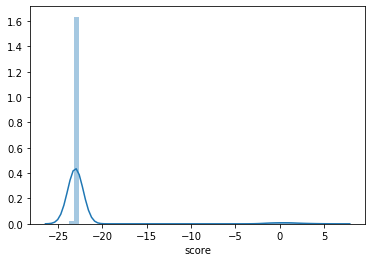

In [24]:
null_importance = null_Importance_maker.all_flow()
sns.distplot(null_importance['score'])
new_cols = null_importance[null_importance['score']>-15].col.tolist()
print(new_cols)

In [25]:
feature = ['data', 'analyt', 'model', 'softwar', 'particip', 'analysi', 'algorithm', 'requir', 'predict', 'busi', 'stakehold', 'custom', 
           'techniqu', 'machinelearn', 'system', 'technic', 'network', 'result', 'sale', 'meet', 'design', 'insight', 'train', 'secur',
           'build', 'test', 'engin', 'implement', 'configur', 'continu', 'work', 'understand', 'architectur', 'statist', 'across', 
           'infrastructur', 'opportun', 'activ', 'contribut', 'review', 'manag', 'product', 'present', 'research', 'plan', 'method',
           'make', 'agil', 'optim', 'establish', 'skill', 'collabor', 'report', 'effici', 'maintain', 'perform', 'use', 'develop', 'support',
           'member', 'client', 'specif', 'innov', 'compon', 'set', 'commun', 'servic', 'respons', 'platform', 'includ', 'document', 'defin',
           'exist', 'project', 'conduct', 'inform', 'environ', 'program', 'applic', 'chang', 'help', 'interfac', 'relat', 'abil', 'deliveri',
           'oper', 'monitor', 'creat', 'qualiti', 'team', 'assign', 'time', 'analyz', 'execut', 'issu', 'extern', 'end', 'comput', 'drive',
           'consult', 'learn', 'technolog', 'user', 'complex', 'expert', 'cloud', 'provid', 'solut', 'compani', 'leverag', 'integr', 'base',
           'process', 'function', 'enhanc', 'lead', 'complet', 'partner', 'high', 'new', 'assist', 'deliv', 'experi', 'level']
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2', 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 2.29775	valid_1's tweedie: 2.30247
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 2.29265	valid_1's tweedie: 2.30989
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.27585	valid_1's tweedie: 2.28457
Early stopping, best iteration is:
[351]	training's tweedie: 2.28079	valid_1's tweedie: 2.28219
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[103]	training's tweedie: 2.282	valid_1's tweedie: 2.29493
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's tweedie: 2.29196	valid_1's tweedie: 2.29822


[I 2020-08-19 21:21:23,925] Finished trial#0 with value: 1.2371363401384774 with parameters: {'tweedie_variance_power': 1.123553836799147, 'max_bin': 184, 'subsample': 0.5527472551490751, 'subsample_freq': 0.5495458013584585, 'learning_rate': 0.11389149497453345, 'num_leaves': 7, 'feature_fraction': 0.8365930721190087, 'bagging_freq': 5, 'min_child_samples': 98, 'lambda_l1': 0.0009835207946758396, 'lambda_l2': 0.03519060435305795}. Best is trial#0 with value: 1.2371363401384774.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's tweedie: 3.03714	valid_1's tweedie: 3.13838
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.95471	valid_1's tweedie: 3.14461
Early stopping, best iteration is:
[360]	training's tweedie: 2.98083	valid_1's tweedie: 3.10901
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.92244	valid_1's tweedie: 3.09022
Early stopping, best iteration is:
[396]	training's tweedie: 2.94684	valid_1's tweedie: 3.08766
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 3.10779	valid_1's tweedie: 3.19945
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[156]	training's tweedie: 3.02189	valid_1's tweedie: 3.13206


[I 2020-08-19 21:21:24,766] Finished trial#1 with value: 1.6551907328843625 with parameters: {'tweedie_variance_power': 1.7375600945520824, 'max_bin': 113, 'subsample': 0.8799949874383415, 'subsample_freq': 0.8870465340099376, 'learning_rate': 0.03414976754010373, 'num_leaves': 7, 'feature_fraction': 0.9911506409849252, 'bagging_freq': 6, 'min_child_samples': 72, 'lambda_l1': 0.2074263927418464, 'lambda_l2': 2.4868584101604925}. Best is trial#0 with value: 1.2371363401384774.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's tweedie: 1.5189	valid_1's tweedie: 1.56697
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[266]	training's tweedie: 1.48859	valid_1's tweedie: 1.53137
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	training's tweedie: 1.48057	valid_1's tweedie: 1.53336
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[210]	training's tweedie: 1.49465	valid_1's tweedie: 1.56171
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.4478	valid_1's tweedie: 1.53883
Early stopping, best iteration is:
[337]	training's tweedie: 1.46736	valid_1's tweedie: 1.52568


[I 2020-08-19 21:21:25,545] Finished trial#2 with value: 0.8565144249239948 with parameters: {'tweedie_variance_power': 1.4651012282062061, 'max_bin': 225, 'subsample': 0.7082580793833707, 'subsample_freq': 0.4496516010987557, 'learning_rate': 0.04314540760786151, 'num_leaves': 4, 'feature_fraction': 0.6044445253398765, 'bagging_freq': 5, 'min_child_samples': 17, 'lambda_l1': 0.7094526998783021, 'lambda_l2': 0.0002870773104787835}. Best is trial#2 with value: 0.8565144249239948.


Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.56775	valid_1's tweedie: 1.59781
Early stopping, best iteration is:
[383]	training's tweedie: 1.57036	valid_1's tweedie: 1.59604
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.57161	valid_1's tweedie: 1.60419
Early stopping, best iteration is:
[483]	training's tweedie: 1.57186	valid_1's tweedie: 1.6033
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.57093	valid_1's tweedie: 1.57332
[1000]	training's tweedie: 1.56488	valid_1's tweedie: 1.57275
Early stopping, best iteration is:
[803]	training's tweedie: 1.5672	valid_1's tweedie: 1.57116
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[186]	training's tweedie: 1.57642	valid_1's tweedie: 1.58465
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.57249	valid_1's tweedie: 1.58653
Ea

[I 2020-08-19 21:21:26,607] Finished trial#3 with value: 0.8844821440223565 with parameters: {'tweedie_variance_power': 1.2415479600249897, 'max_bin': 195, 'subsample': 0.44118177072886894, 'subsample_freq': 0.6633574083414429, 'learning_rate': 0.046850344419778166, 'num_leaves': 7, 'feature_fraction': 0.6686804641304541, 'bagging_freq': 1, 'min_child_samples': 78, 'lambda_l1': 0.18969476174932975, 'lambda_l2': 0.4174175158733196}. Best is trial#2 with value: 0.8565144249239948.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.78139	valid_1's tweedie: 1.80368
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	training's tweedie: 1.7642	valid_1's tweedie: 1.77757
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	training's tweedie: 1.75727	valid_1's tweedie: 1.78226
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	training's tweedie: 1.75864	valid_1's tweedie: 1.80099
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's tweedie: 1.75864	valid_1's tweedie: 1.78629


[I 2020-08-19 21:21:27,298] Finished trial#4 with value: 0.9781564319530638 with parameters: {'tweedie_variance_power': 1.1766810965360293, 'max_bin': 136, 'subsample': 0.6760383955783349, 'subsample_freq': 0.4671074252756638, 'learning_rate': 0.10042563102675196, 'num_leaves': 4, 'feature_fraction': 0.9649062624266439, 'bagging_freq': 6, 'min_child_samples': 17, 'lambda_l1': 0.0004541964176462635, 'lambda_l2': 0.4742121739181612}. Best is trial#2 with value: 0.8565144249239948.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 2.28812	valid_1's tweedie: 2.32184
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 2.26758	valid_1's tweedie: 2.32225
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's tweedie: 2.23936	valid_1's tweedie: 2.29335
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[204]	training's tweedie: 2.20949	valid_1's tweedie: 2.27673
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 2.28477	valid_1's tweedie: 2.30143


[I 2020-08-19 21:21:27,941] Finished trial#5 with value: 1.2441882735241294 with parameters: {'tweedie_variance_power': 1.643045812250917, 'max_bin': 108, 'subsample': 0.6758061575075152, 'subsample_freq': 0.8954545315584372, 'learning_rate': 0.11651126541571485, 'num_leaves': 4, 'feature_fraction': 0.5854757800000694, 'bagging_freq': 3, 'min_child_samples': 82, 'lambda_l1': 0.005472539296355176, 'lambda_l2': 0.015395703449385059}. Best is trial#2 with value: 0.8565144249239948.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.43238	valid_1's tweedie: 1.47904
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.42352	valid_1's tweedie: 1.45389
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.39322	valid_1's tweedie: 1.43704
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.43155	valid_1's tweedie: 1.4771
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.44239	valid_1's tweedie: 1.46571


[I 2020-08-19 21:21:28,632] Finished trial#6 with value: 0.8175945166357951 with parameters: {'tweedie_variance_power': 1.3830177426977417, 'max_bin': 239, 'subsample': 0.6639240548322112, 'subsample_freq': 0.7309013331484755, 'learning_rate': 0.23719913042690083, 'num_leaves': 9, 'feature_fraction': 0.6833927187448134, 'bagging_freq': 7, 'min_child_samples': 61, 'lambda_l1': 0.04048189752519715, 'lambda_l2': 5.114715350434504}. Best is trial#6 with value: 0.8175945166357951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.52431	valid_1's tweedie: 1.53809
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.51694	valid_1's tweedie: 1.53748
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	training's tweedie: 1.50944	valid_1's tweedie: 1.51727
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's tweedie: 1.50666	valid_1's tweedie: 1.53218
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's tweedie: 1.50484	valid_1's tweedie: 1.52469


[I 2020-08-19 21:21:29,245] Finished trial#7 with value: 0.8550408474890366 with parameters: {'tweedie_variance_power': 1.2690397241824702, 'max_bin': 298, 'subsample': 0.6123029956553068, 'subsample_freq': 0.40129711491114584, 'learning_rate': 0.42390705486505736, 'num_leaves': 4, 'feature_fraction': 0.6337276604530471, 'bagging_freq': 6, 'min_child_samples': 87, 'lambda_l1': 0.058214341124501634, 'lambda_l2': 6.1817466021873955}. Best is trial#6 with value: 0.8175945166357951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's tweedie: 1.92408	valid_1's tweedie: 1.96529
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 1.95816	valid_1's tweedie: 2.0037
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.88404	valid_1's tweedie: 1.94481
[1000]	training's tweedie: 1.8668	valid_1's tweedie: 1.94331
Early stopping, best iteration is:
[868]	training's tweedie: 1.87067	valid_1's tweedie: 1.94034
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's tweedie: 1.90067	valid_1's tweedie: 1.98022
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.9074	valid_1's tweedie: 1.95534


[I 2020-08-19 21:21:30,091] Finished trial#8 with value: 1.0730230532082587 with parameters: {'tweedie_variance_power': 1.5881204368624755, 'max_bin': 265, 'subsample': 0.875081867483781, 'subsample_freq': 0.4407244214538976, 'learning_rate': 0.03486802507752124, 'num_leaves': 8, 'feature_fraction': 0.9597445797667509, 'bagging_freq': 7, 'min_child_samples': 83, 'lambda_l1': 4.694847517247992, 'lambda_l2': 0.00014192222123624918}. Best is trial#6 with value: 0.8175945166357951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 2.61548	valid_1's tweedie: 2.66436
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 2.62286	valid_1's tweedie: 2.67596
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 2.46699	valid_1's tweedie: 2.64277
Early stopping, best iteration is:
[393]	training's tweedie: 2.48666	valid_1's tweedie: 2.63146
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's tweedie: 2.53147	valid_1's tweedie: 2.62831
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's tweedie: 2.60713	valid_1's tweedie: 2.65072


[I 2020-08-19 21:21:30,830] Finished trial#9 with value: 1.4149754999954374 with parameters: {'tweedie_variance_power': 1.6880641442515885, 'max_bin': 128, 'subsample': 0.8746376268865677, 'subsample_freq': 0.7343842168855212, 'learning_rate': 0.12347803304333306, 'num_leaves': 10, 'feature_fraction': 0.6299944139735125, 'bagging_freq': 3, 'min_child_samples': 100, 'lambda_l1': 1.1025435287768837, 'lambda_l2': 0.7630284229806351}. Best is trial#6 with value: 0.8175945166357951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's tweedie: 1.43888	valid_1's tweedie: 1.48264
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.39832	valid_1's tweedie: 1.47129
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 1.4062	valid_1's tweedie: 1.44458
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[10]	training's tweedie: 1.42572	valid_1's tweedie: 1.45798
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 1.41961	valid_1's tweedie: 1.46478


[I 2020-08-19 21:21:31,577] Finished trial#10 with value: 0.8213390956459489 with parameters: {'tweedie_variance_power': 1.38943645852493, 'max_bin': 263, 'subsample': 0.7793143822698871, 'subsample_freq': 0.7751519091564656, 'learning_rate': 0.47660228820206113, 'num_leaves': 10, 'feature_fraction': 0.44970217434021187, 'bagging_freq': 1, 'min_child_samples': 48, 'lambda_l1': 0.008286165449822226, 'lambda_l2': 0.005015481300070227}. Best is trial#6 with value: 0.8175945166357951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.42826	valid_1's tweedie: 1.49002
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.44415	valid_1's tweedie: 1.47894
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's tweedie: 1.40369	valid_1's tweedie: 1.4698
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 1.46385	valid_1's tweedie: 1.49047
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 1.4294	valid_1's tweedie: 1.49198


[I 2020-08-19 21:21:32,283] Finished trial#11 with value: 0.8292951077205637 with parameters: {'tweedie_variance_power': 1.4172639285851067, 'max_bin': 254, 'subsample': 0.778854925754032, 'subsample_freq': 0.7900721968005204, 'learning_rate': 0.42818314517979056, 'num_leaves': 10, 'feature_fraction': 0.4278283552654408, 'bagging_freq': 2, 'min_child_samples': 45, 'lambda_l1': 0.006905819892018539, 'lambda_l2': 0.00251044047421676}. Best is trial#6 with value: 0.8175945166357951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.42812	valid_1's tweedie: 1.47615
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.42476	valid_1's tweedie: 1.45681
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.41755	valid_1's tweedie: 1.44163
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.42896	valid_1's tweedie: 1.47158
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.42433	valid_1's tweedie: 1.46818


[I 2020-08-19 21:21:33,015] Finished trial#12 with value: 0.8194578093220162 with parameters: {'tweedie_variance_power': 1.3883578318551344, 'max_bin': 285, 'subsample': 0.7778684020285999, 'subsample_freq': 0.7942375857580906, 'learning_rate': 0.2646810150317191, 'num_leaves': 9, 'feature_fraction': 0.4052443391900022, 'bagging_freq': 1, 'min_child_samples': 49, 'lambda_l1': 0.015272498558283502, 'lambda_l2': 0.002662068741135096}. Best is trial#6 with value: 0.8175945166357951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 1.75237	valid_1's tweedie: 1.78476
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.74833	valid_1's tweedie: 1.8076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.74649	valid_1's tweedie: 1.7734
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.70968	valid_1's tweedie: 1.78717
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's tweedie: 1.74157	valid_1's tweedie: 1.7829


[I 2020-08-19 21:21:33,677] Finished trial#13 with value: 0.982630385882652 with parameters: {'tweedie_variance_power': 1.539555803415332, 'max_bin': 297, 'subsample': 0.5690237137193969, 'subsample_freq': 0.6867446273324964, 'learning_rate': 0.24421351327222413, 'num_leaves': 9, 'feature_fraction': 0.7921631412936476, 'bagging_freq': 4, 'min_child_samples': 60, 'lambda_l1': 0.029108251608660967, 'lambda_l2': 0.0005778260308705167}. Best is trial#6 with value: 0.8175945166357951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's tweedie: 1.39553	valid_1's tweedie: 1.45723
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 1.36862	valid_1's tweedie: 1.43031
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.38664	valid_1's tweedie: 1.42409
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.38566	valid_1's tweedie: 1.4509
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.37248	valid_1's tweedie: 1.43602


[I 2020-08-19 21:21:34,363] Finished trial#14 with value: 0.8053208215318826 with parameters: {'tweedie_variance_power': 1.328733707387827, 'max_bin': 226, 'subsample': 0.771018371164376, 'subsample_freq': 0.8229003183217549, 'learning_rate': 0.24305009772642197, 'num_leaves': 9, 'feature_fraction': 0.514272974834159, 'bagging_freq': 7, 'min_child_samples': 30, 'lambda_l1': 0.002041101504927493, 'lambda_l2': 0.04787150618295766}. Best is trial#14 with value: 0.8053208215318826.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.4298	valid_1's tweedie: 1.469
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.42441	valid_1's tweedie: 1.45891
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.42289	valid_1's tweedie: 1.43731
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's tweedie: 1.43176	valid_1's tweedie: 1.47233
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.43123	valid_1's tweedie: 1.46169


[I 2020-08-19 21:21:35,043] Finished trial#15 with value: 0.8172628811280278 with parameters: {'tweedie_variance_power': 1.3045670941815077, 'max_bin': 51, 'subsample': 0.4862276413989253, 'subsample_freq': 0.850049662713877, 'learning_rate': 0.22144078327467404, 'num_leaves': 9, 'feature_fraction': 0.5406670644286578, 'bagging_freq': 7, 'min_child_samples': 33, 'lambda_l1': 0.0009081229751488085, 'lambda_l2': 0.07672901744872926}. Best is trial#14 with value: 0.8053208215318826.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.45711	valid_1's tweedie: 1.4827
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's tweedie: 1.42559	valid_1's tweedie: 1.46044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[149]	training's tweedie: 1.41618	valid_1's tweedie: 1.44907
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's tweedie: 1.41591	valid_1's tweedie: 1.48499
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's tweedie: 1.42759	valid_1's tweedie: 1.46885


[I 2020-08-19 21:21:35,781] Finished trial#16 with value: 0.823146830862054 with parameters: {'tweedie_variance_power': 1.2904522875119482, 'max_bin': 55, 'subsample': 0.41875953279806727, 'subsample_freq': 0.853184354042389, 'learning_rate': 0.16619978840623623, 'num_leaves': 8, 'feature_fraction': 0.5064126418150342, 'bagging_freq': 7, 'min_child_samples': 30, 'lambda_l1': 0.0001258462995694131, 'lambda_l2': 0.07696009728163433}. Best is trial#14 with value: 0.8053208215318826.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's tweedie: 1.43528	valid_1's tweedie: 1.45632
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's tweedie: 1.40589	valid_1's tweedie: 1.44446
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 1.43104	valid_1's tweedie: 1.43974
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.41658	valid_1's tweedie: 1.45396
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.42584	valid_1's tweedie: 1.45163


[I 2020-08-19 21:21:36,427] Finished trial#17 with value: 0.812969817811668 with parameters: {'tweedie_variance_power': 1.3189645541536037, 'max_bin': 63, 'subsample': 0.5161939389354155, 'subsample_freq': 0.607558585784179, 'learning_rate': 0.29845992772587976, 'num_leaves': 6, 'feature_fraction': 0.5239765997983977, 'bagging_freq': 5, 'min_child_samples': 35, 'lambda_l1': 0.0013217707812374611, 'lambda_l2': 0.13003446860558543}. Best is trial#14 with value: 0.8053208215318826.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 2.42946	valid_1's tweedie: 2.44388
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's tweedie: 2.40587	valid_1's tweedie: 2.42795
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 2.39834	valid_1's tweedie: 2.4342
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 2.40463	valid_1's tweedie: 2.45528
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's tweedie: 2.42156	valid_1's tweedie: 2.4395


[I 2020-08-19 21:21:37,054] Finished trial#18 with value: 1.3062281130066353 with parameters: {'tweedie_variance_power': 1.1113574896193343, 'max_bin': 209, 'subsample': 0.532085941807241, 'subsample_freq': 0.5655947678893064, 'learning_rate': 0.34143790371033683, 'num_leaves': 5, 'feature_fraction': 0.4808010708291926, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 0.00020151784310917933, 'lambda_l2': 0.12967376444724157}. Best is trial#14 with value: 0.8053208215318826.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's tweedie: 1.58665	valid_1's tweedie: 1.63041
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.55029	valid_1's tweedie: 1.59083
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.54127	valid_1's tweedie: 1.58955
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.53831	valid_1's tweedie: 1.61214
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.51888	valid_1's tweedie: 1.58665


[I 2020-08-19 21:21:37,707] Finished trial#19 with value: 0.886082748298447 with parameters: {'tweedie_variance_power': 1.4869386256070243, 'max_bin': 155, 'subsample': 0.7405479564789733, 'subsample_freq': 0.5831801185145804, 'learning_rate': 0.17259956887837108, 'num_leaves': 6, 'feature_fraction': 0.7757611905726531, 'bagging_freq': 4, 'min_child_samples': 34, 'lambda_l1': 0.002404205168128759, 'lambda_l2': 0.011620277449511657}. Best is trial#14 with value: 0.8053208215318826.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's tweedie: 1.6073	valid_1's tweedie: 1.63898
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.59045	valid_1's tweedie: 1.61134
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.57524	valid_1's tweedie: 1.60989
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.5738	valid_1's tweedie: 1.62796
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.58498	valid_1's tweedie: 1.61759


[I 2020-08-19 21:21:38,346] Finished trial#20 with value: 0.896210708301801 with parameters: {'tweedie_variance_power': 1.214021231510317, 'max_bin': 82, 'subsample': 0.8269535237646644, 'subsample_freq': 0.6094254098842438, 'learning_rate': 0.33250868299994846, 'num_leaves': 6, 'feature_fraction': 0.5145033727405269, 'bagging_freq': 6, 'min_child_samples': 20, 'lambda_l1': 0.0021299577043237764, 'lambda_l2': 0.2210894828077801}. Best is trial#14 with value: 0.8053208215318826.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.42293	valid_1's tweedie: 1.45568
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.4202	valid_1's tweedie: 1.43694
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's tweedie: 1.40346	valid_1's tweedie: 1.42618
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's tweedie: 1.42202	valid_1's tweedie: 1.46585
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's tweedie: 1.38991	valid_1's tweedie: 1.43885


[I 2020-08-19 21:21:39,034] Finished trial#21 with value: 0.8061085115193045 with parameters: {'tweedie_variance_power': 1.3266138817558644, 'max_bin': 50, 'subsample': 0.47582872275840143, 'subsample_freq': 0.8409937306335026, 'learning_rate': 0.18999200318899512, 'num_leaves': 8, 'feature_fraction': 0.5638108700955177, 'bagging_freq': 7, 'min_child_samples': 35, 'lambda_l1': 0.0005565865078472803, 'lambda_l2': 0.06196195329008091}. Best is trial#14 with value: 0.8053208215318826.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.40873	valid_1's tweedie: 1.4482
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's tweedie: 1.39383	valid_1's tweedie: 1.42357
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.40883	valid_1's tweedie: 1.42478
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's tweedie: 1.40801	valid_1's tweedie: 1.44185
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.38876	valid_1's tweedie: 1.43979


[I 2020-08-19 21:21:39,716] Finished trial#22 with value: 0.8029428849891536 with parameters: {'tweedie_variance_power': 1.3284923451491049, 'max_bin': 76, 'subsample': 0.4754856886572201, 'subsample_freq': 0.5130930221328525, 'learning_rate': 0.17293712232704625, 'num_leaves': 8, 'feature_fraction': 0.5620551510809254, 'bagging_freq': 6, 'min_child_samples': 25, 'lambda_l1': 0.0003061199830664195, 'lambda_l2': 0.028712956648360075}. Best is trial#22 with value: 0.8029428849891536.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.38658	valid_1's tweedie: 1.44248
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.37916	valid_1's tweedie: 1.40963
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's tweedie: 1.37529	valid_1's tweedie: 1.41338
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.39026	valid_1's tweedie: 1.45068
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's tweedie: 1.37684	valid_1's tweedie: 1.43022


[I 2020-08-19 21:21:40,433] Finished trial#23 with value: 0.7985696323173095 with parameters: {'tweedie_variance_power': 1.3457027017906198, 'max_bin': 84, 'subsample': 0.46543529061566563, 'subsample_freq': 0.5034369009927118, 'learning_rate': 0.07567024781596604, 'num_leaves': 8, 'feature_fraction': 0.557126797924319, 'bagging_freq': 7, 'min_child_samples': 7, 'lambda_l1': 0.0003094283066984612, 'lambda_l2': 0.03007006236358947}. Best is trial#23 with value: 0.7985696323173095.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.38228	valid_1's tweedie: 1.44773
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.39106	valid_1's tweedie: 1.40926
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's tweedie: 1.39024	valid_1's tweedie: 1.4214
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 1.37305	valid_1's tweedie: 1.44315
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.33919	valid_1's tweedie: 1.43357


[I 2020-08-19 21:21:41,154] Finished trial#24 with value: 0.7979041202630435 with parameters: {'tweedie_variance_power': 1.3395659086519256, 'max_bin': 83, 'subsample': 0.5992076918712337, 'subsample_freq': 0.5063247800541542, 'learning_rate': 0.08639278408451069, 'num_leaves': 8, 'feature_fraction': 0.7277965069493326, 'bagging_freq': 6, 'min_child_samples': 8, 'lambda_l1': 0.00011263640805127995, 'lambda_l2': 0.01660238018826992}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.57682	valid_1's tweedie: 1.67606
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.59128	valid_1's tweedie: 1.62664
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's tweedie: 1.59524	valid_1's tweedie: 1.63472
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 1.56859	valid_1's tweedie: 1.66889
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.50937	valid_1's tweedie: 1.65464


[I 2020-08-19 21:21:41,874] Finished trial#25 with value: 0.9084938831182521 with parameters: {'tweedie_variance_power': 1.5119995810287015, 'max_bin': 85, 'subsample': 0.5983275935038626, 'subsample_freq': 0.5187663251740195, 'learning_rate': 0.06761432076879281, 'num_leaves': 8, 'feature_fraction': 0.7355194945091689, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.0002396563873780955, 'lambda_l2': 0.014892496603073912}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's tweedie: 1.66346	valid_1's tweedie: 1.7019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's tweedie: 1.66399	valid_1's tweedie: 1.666
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	training's tweedie: 1.63839	valid_1's tweedie: 1.68823
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's tweedie: 1.65397	valid_1's tweedie: 1.71621
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	training's tweedie: 1.66631	valid_1's tweedie: 1.69244


[I 2020-08-19 21:21:42,606] Finished trial#26 with value: 0.9293801893833382 with parameters: {'tweedie_variance_power': 1.1956466180367422, 'max_bin': 79, 'subsample': 0.44845304783210466, 'subsample_freq': 0.5245671012127581, 'learning_rate': 0.0777824264322079, 'num_leaves': 8, 'feature_fraction': 0.8768512705079903, 'bagging_freq': 6, 'min_child_samples': 11, 'lambda_l1': 0.00010800842680218971, 'lambda_l2': 0.005847194766216841}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.48501	valid_1's tweedie: 1.5247
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's tweedie: 1.46057	valid_1's tweedie: 1.49471
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.46145	valid_1's tweedie: 1.49213
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's tweedie: 1.43422	valid_1's tweedie: 1.53055
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's tweedie: 1.44386	valid_1's tweedie: 1.48774


[I 2020-08-19 21:21:43,314] Finished trial#27 with value: 0.835883250796412 with parameters: {'tweedie_variance_power': 1.4371808590615347, 'max_bin': 101, 'subsample': 0.4136893085455516, 'subsample_freq': 0.49515736190797993, 'learning_rate': 0.06651421114894802, 'num_leaves': 7, 'feature_fraction': 0.7173182459366334, 'bagging_freq': 5, 'min_child_samples': 22, 'lambda_l1': 0.0002738749819098232, 'lambda_l2': 0.0010650699568700017}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's tweedie: 1.38117	valid_1's tweedie: 1.44528
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's tweedie: 1.38801	valid_1's tweedie: 1.40752
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's tweedie: 1.36853	valid_1's tweedie: 1.4177
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's tweedie: 1.39505	valid_1's tweedie: 1.4405
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.33484	valid_1's tweedie: 1.43254


[I 2020-08-19 21:21:44,038] Finished trial#28 with value: 0.7982826708806666 with parameters: {'tweedie_variance_power': 1.3506456162438651, 'max_bin': 155, 'subsample': 0.6159131814226528, 'subsample_freq': 0.4860777945671162, 'learning_rate': 0.08687973172290628, 'num_leaves': 8, 'feature_fraction': 0.6561737011979685, 'bagging_freq': 6, 'min_child_samples': 9, 'lambda_l1': 0.00010769802032891593, 'lambda_l2': 0.024003388054105575}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.95962	valid_1's tweedie: 1.99999
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's tweedie: 1.95361	valid_1's tweedie: 1.97231
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's tweedie: 1.9598	valid_1's tweedie: 1.98216
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's tweedie: 1.95479	valid_1's tweedie: 1.99707
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's tweedie: 1.95068	valid_1's tweedie: 1.99217


[I 2020-08-19 21:21:44,756] Finished trial#29 with value: 1.0759106885162109 with parameters: {'tweedie_variance_power': 1.1482370109351359, 'max_bin': 165, 'subsample': 0.6308388249018922, 'subsample_freq': 0.40516178128809094, 'learning_rate': 0.08617264443792914, 'num_leaves': 7, 'feature_fraction': 0.8250690241978235, 'bagging_freq': 5, 'min_child_samples': 12, 'lambda_l1': 0.00010062313178838472, 'lambda_l2': 0.025600400165662694}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's tweedie: 1.37917	valid_1's tweedie: 1.45085
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.39373	valid_1's tweedie: 1.4111
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[163]	training's tweedie: 1.35375	valid_1's tweedie: 1.41901
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.38692	valid_1's tweedie: 1.44777
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.36495	valid_1's tweedie: 1.44004


[I 2020-08-19 21:21:45,511] Finished trial#30 with value: 0.800126748627656 with parameters: {'tweedie_variance_power': 1.3713337930121972, 'max_bin': 143, 'subsample': 0.561823823788587, 'subsample_freq': 0.4792254551407975, 'learning_rate': 0.05216819682827973, 'num_leaves': 8, 'feature_fraction': 0.7429603655115878, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 0.00011255635129081547, 'lambda_l2': 0.006813624134869828}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's tweedie: 1.37562	valid_1's tweedie: 1.45108
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's tweedie: 1.37201	valid_1's tweedie: 1.40882
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	training's tweedie: 1.36544	valid_1's tweedie: 1.4169
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's tweedie: 1.37968	valid_1's tweedie: 1.44887
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's tweedie: 1.3626	valid_1's tweedie: 1.43938


[I 2020-08-19 21:21:46,267] Finished trial#31 with value: 0.7980474317213272 with parameters: {'tweedie_variance_power': 1.367783424897648, 'max_bin': 138, 'subsample': 0.574203270862333, 'subsample_freq': 0.4747556559568139, 'learning_rate': 0.05454161815772264, 'num_leaves': 8, 'feature_fraction': 0.7652278612355011, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 0.00010360629620091649, 'lambda_l2': 0.007923863082768403}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's tweedie: 1.39732	valid_1's tweedie: 1.45407
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's tweedie: 1.37822	valid_1's tweedie: 1.40839
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	training's tweedie: 1.37775	valid_1's tweedie: 1.41942
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	training's tweedie: 1.38416	valid_1's tweedie: 1.44566
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[156]	training's tweedie: 1.35941	valid_1's tweedie: 1.42908


[I 2020-08-19 21:21:47,000] Finished trial#32 with value: 0.7982295203374151 with parameters: {'tweedie_variance_power': 1.3602834775259485, 'max_bin': 119, 'subsample': 0.5964713804901856, 'subsample_freq': 0.4256777355687324, 'learning_rate': 0.060614250114949204, 'num_leaves': 7, 'feature_fraction': 0.8546682031488346, 'bagging_freq': 7, 'min_child_samples': 11, 'lambda_l1': 0.0005115957266949364, 'lambda_l2': 0.0020448091426592697}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.50568	valid_1's tweedie: 1.53998
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.51283	valid_1's tweedie: 1.52087
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's tweedie: 1.49483	valid_1's tweedie: 1.52322
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's tweedie: 1.48526	valid_1's tweedie: 1.54177
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.48528	valid_1's tweedie: 1.5302


[I 2020-08-19 21:21:47,745] Finished trial#33 with value: 0.845942896856754 with parameters: {'tweedie_variance_power': 1.2441632433159011, 'max_bin': 175, 'subsample': 0.596891608776687, 'subsample_freq': 0.4333003299419511, 'learning_rate': 0.053777603752486004, 'num_leaves': 7, 'feature_fraction': 0.8825376989609434, 'bagging_freq': 6, 'min_child_samples': 12, 'lambda_l1': 0.0006672581049801526, 'lambda_l2': 0.0018773107138697447}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	training's tweedie: 1.47031	valid_1's tweedie: 1.52402
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's tweedie: 1.45561	valid_1's tweedie: 1.48437
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's tweedie: 1.44335	valid_1's tweedie: 1.48959
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's tweedie: 1.45614	valid_1's tweedie: 1.52003
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	training's tweedie: 1.40987	valid_1's tweedie: 1.50017


[I 2020-08-19 21:21:48,468] Finished trial#34 with value: 0.8338706947199898 with parameters: {'tweedie_variance_power': 1.4422744051876026, 'max_bin': 120, 'subsample': 0.638547300786564, 'subsample_freq': 0.41429889039778967, 'learning_rate': 0.059159785704848394, 'num_leaves': 7, 'feature_fraction': 0.8816414355894944, 'bagging_freq': 6, 'min_child_samples': 13, 'lambda_l1': 0.00010294547292253051, 'lambda_l2': 0.008395853075556991}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[158]	training's tweedie: 1.46798	valid_1's tweedie: 1.51014
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	training's tweedie: 1.47628	valid_1's tweedie: 1.49397
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[168]	training's tweedie: 1.47009	valid_1's tweedie: 1.48775
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[191]	training's tweedie: 1.46214	valid_1's tweedie: 1.50746
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	training's tweedie: 1.46679	valid_1's tweedie: 1.50124


[I 2020-08-19 21:21:49,237] Finished trial#35 with value: 0.8314268432308121 with parameters: {'tweedie_variance_power': 1.261138757564162, 'max_bin': 144, 'subsample': 0.5784475373545881, 'subsample_freq': 0.4699725297594708, 'learning_rate': 0.038801315736071804, 'num_leaves': 6, 'feature_fraction': 0.8365377092993176, 'bagging_freq': 7, 'min_child_samples': 24, 'lambda_l1': 0.00017254335994416312, 'lambda_l2': 0.0008865896827569098}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	training's tweedie: 1.5218	valid_1's tweedie: 1.58434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's tweedie: 1.49006	valid_1's tweedie: 1.55123
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's tweedie: 1.51747	valid_1's tweedie: 1.55731
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's tweedie: 1.50603	valid_1's tweedie: 1.56311
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's tweedie: 1.49472	valid_1's tweedie: 1.5432


[I 2020-08-19 21:21:49,909] Finished trial#36 with value: 0.8641819323869917 with parameters: {'tweedie_variance_power': 1.473294457667383, 'max_bin': 99, 'subsample': 0.5359905595261492, 'subsample_freq': 0.5315327871220896, 'learning_rate': 0.1374648035975182, 'num_leaves': 7, 'feature_fraction': 0.6567404760236558, 'bagging_freq': 6, 'min_child_samples': 15, 'lambda_l1': 0.0004870017624963044, 'lambda_l2': 0.003933831594426718}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 3.99219	valid_1's tweedie: 4.09226
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[12]	training's tweedie: 3.99986	valid_1's tweedie: 4.05451
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 3.94331	valid_1's tweedie: 4.05343
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's tweedie: 3.87196	valid_1's tweedie: 4.05291
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 3.85676	valid_1's tweedie: 3.91549


[I 2020-08-19 21:21:50,587] Finished trial#37 with value: 2.103354627610258 with parameters: {'tweedie_variance_power': 1.7918456880480393, 'max_bin': 186, 'subsample': 0.683965880533331, 'subsample_freq': 0.5559734582611222, 'learning_rate': 0.10232152003499949, 'num_leaves': 9, 'feature_fraction': 0.7912545684880651, 'bagging_freq': 5, 'min_child_samples': 9, 'lambda_l1': 0.0011271966018295589, 'lambda_l2': 0.0001873113515209884}. Best is trial#24 with value: 0.7979041202630435.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.39611	valid_1's tweedie: 1.44593
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 1.37197	valid_1's tweedie: 1.41392
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.39177	valid_1's tweedie: 1.42429
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.36427	valid_1's tweedie: 1.44285
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.37616	valid_1's tweedie: 1.42158


[I 2020-08-19 21:21:51,291] Finished trial#38 with value: 0.7963925228653033 with parameters: {'tweedie_variance_power': 1.3601139018579118, 'max_bin': 117, 'subsample': 0.7105020921378892, 'subsample_freq': 0.45522440172285866, 'learning_rate': 0.08901678659349402, 'num_leaves': 7, 'feature_fraction': 0.7003329254388102, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.00010358396445014811, 'lambda_l2': 0.0004086739749505933}. Best is trial#38 with value: 0.7963925228653033.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's tweedie: 1.41544	valid_1's tweedie: 1.48392
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	training's tweedie: 1.40346	valid_1's tweedie: 1.45441
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's tweedie: 1.41	valid_1's tweedie: 1.44954
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	training's tweedie: 1.41356	valid_1's tweedie: 1.47031
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[171]	training's tweedie: 1.40117	valid_1's tweedie: 1.44855


[I 2020-08-19 21:21:52,057] Finished trial#39 with value: 0.8123822229151357 with parameters: {'tweedie_variance_power': 1.410343026980563, 'max_bin': 119, 'subsample': 0.7084003829328143, 'subsample_freq': 0.4494361703494466, 'learning_rate': 0.043623126090815804, 'num_leaves': 6, 'feature_fraction': 0.697032103836428, 'bagging_freq': 3, 'min_child_samples': 17, 'lambda_l1': 0.11356555132015904, 'lambda_l2': 0.00046861536357193647}. Best is trial#38 with value: 0.7963925228653033.


0.7963925228653033
{'tweedie_variance_power': 1.3601139018579118, 'max_bin': 117, 'subsample': 0.7105020921378892, 'subsample_freq': 0.45522440172285866, 'learning_rate': 0.08901678659349402, 'num_leaves': 7, 'feature_fraction': 0.7003329254388102, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.00010358396445014811, 'lambda_l2': 0.0004086739749505933}


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's tweedie: 1.39611	valid_1's tweedie: 1.44593
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's tweedie: 1.37197	valid_1's tweedie: 1.41392
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's tweedie: 1.39177	valid_1's tweedie: 1.42429
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's tweedie: 1.36427	valid_1's tweedie: 1.44285
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's tweedie: 1.37616	valid_1's tweedie: 1.42158
0.8300921187308086


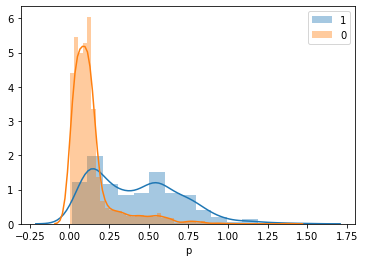

In [26]:
PARAMS={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    'tweedie_variance_power': 1.3601139018579118, 'max_bin': 117, 'subsample': 0.7105020921378892, 'subsample_freq': 0.45522440172285866,
    'learning_rate': 0.08901678659349402, 'num_leaves': 7, 'feature_fraction': 0.7003329254388102, 'bagging_freq': 4,
    'min_child_samples': 16, 'lambda_l1': 0.00010358396445014811, 'lambda_l2': 0.0004086739749505933
}

score = 0
k = StratifiedKFold(n_splits=5)
off_df=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_data = train_df.iloc[trn,:]
    val_data = train_df.iloc[val,:]
    
    train_set= lgb.Dataset(trn_data[new_cols],  trn_data['jobflag_2'])
    val_set = lgb.Dataset(val_data[new_cols],  val_data['jobflag_2'])   
    
    model = lgb.train(
        train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
        early_stopping_rounds=200, verbose_eval=500
    )
    
    val_data['p'] = model.predict(val_data[new_cols])
    off_df.append(val_data[['jobflag', 'jobflag_2', 'p']])
    
off_df = pd.concat(off_df, axis=0)
off_df['pred'] = off_df.p.apply(lambda x: 1 if x>0.25 else 0)

print(metrics.accuracy_score(off_df.jobflag_2, off_df.pred))

sns.distplot(off_df[off_df.jobflag_2==1].p, label='1')
sns.distplot(off_df[off_df.jobflag_2==0].p, label='0')
plt.legend()

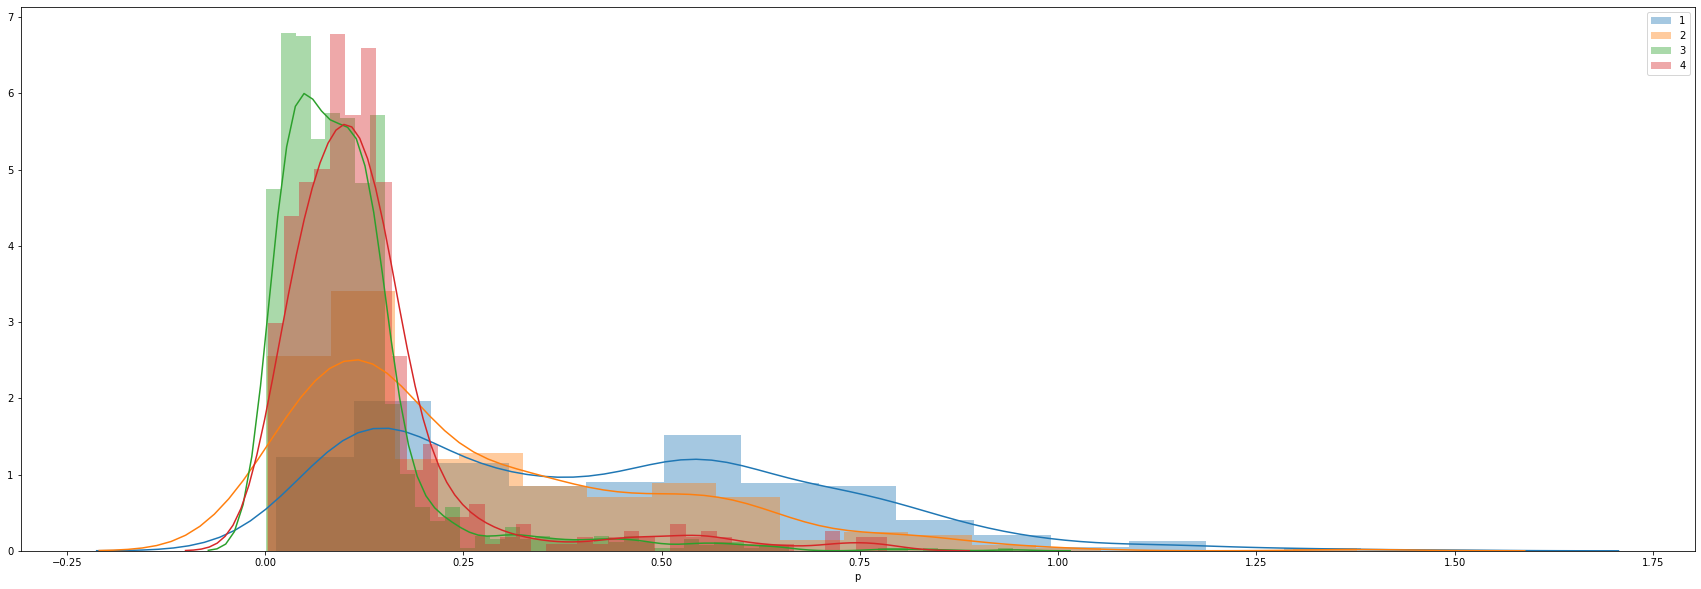

In [27]:
plt.figure(figsize=(30,10))
sns.distplot(off_df[off_df.jobflag==1].p, label='1')
sns.distplot(off_df[off_df.jobflag==2].p, label='2')
sns.distplot(off_df[off_df.jobflag==3].p, label='3')
sns.distplot(off_df[off_df.jobflag==4].p, label='4')
plt.legend()

#### label 3

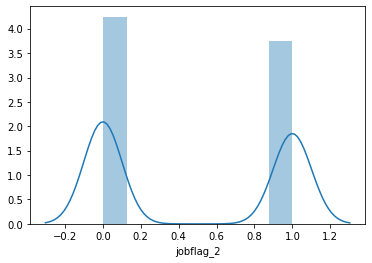

In [28]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==3 else 0)
sns.distplot(train_df.jobflag_2)

In [29]:
class Optimize_by_Optuna:
    def __init__(self, data, features, target_colname, target_name_2=None, _objective=None):
        self.data = data
        self.features = features
        self.target = target_colname
        if not target_colname:
            self.target_2 = target_colname
        else:
            self.target_2 = target_name_2
        self._objective = _objective
        
    
    def make_score(self, y, preds):
        s_1=1 - metrics.accuracy_score(y, preds)
        s_2=list(self.model.best_score['valid_1'].values())[0]

        return (s_1+s_2)/2

    def objective(self, trial):
                        
        PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'xentropy','metric': 'xentropy',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
        

            #'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.01, 1.8),


            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'subsample': trial.suggest_uniform('subsample', 0.4, 0.9),
            'subsample_freq': trial.suggest_uniform('subsample_freq', 0.4, 0.9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 4, 2*5),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.0001, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.0001, 10.0),
        }
        
        score = 0
        k = StratifiedKFold(n_splits=5)
        for trn, val in k.split(self.data, self.data[self.target_2]):
            train_df = self.data.iloc[trn,:]
            val_df = self.data.iloc[val,:]
            train_set= lgb.Dataset(train_df[self.features],  train_df[self.target])
            val_set = lgb.Dataset(val_df[self.features],  val_df[self.target])   
            
            self.model = lgb.train(
                train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
                early_stopping_rounds=200, verbose_eval=500
                )
                
            preds = self.model.predict(val_df[self.features])
            preds = np.round(preds)
            y = val_df[self.target]
            s = self.make_score(y, preds)
            score+=s/5
            
        return score

In [77]:
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
optimize_optuna = Optimize_by_Optuna(data=train_df, features=feature,target_colname= 'jobflag_2',target_name_2= 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_params)
print(study.best_value)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	training's cross_entropy: 0.495216	valid_1's cross_entropy: 0.559063
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.491103	valid_1's cross_entropy: 0.506429
Early stopping, best iteration is:
[746]	training's cross_entropy: 0.477811	valid_1's cross_entropy: 0.503008
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[259]	training's cross_entropy: 0.509568	valid_1's cross_entropy: 0.518695
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.483741	valid_1's cross_entropy: 0.538038
Early stopping, best iteration is:
[611]	training's cross_entropy: 0.476777	valid_1's cross_entropy: 0.536023
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.479905	valid_1's cross_entropy: 0.558278
Early stopping, best iter

[I 2020-08-19 16:44:09,288] Finished trial#0 with value: 0.40578736997750114 with parameters: {'max_bin': 69, 'subsample': 0.45793462449008193, 'subsample_freq': 0.606724098486855, 'learning_rate': 0.03557145755283925, 'num_leaves': 4, 'feature_fraction': 0.9767715103318944, 'bagging_freq': 2, 'min_child_samples': 37, 'lambda_l1': 0.01600464891062445, 'lambda_l2': 0.9643399616869357}. Best is trial#0 with value: 0.40578736997750114.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	training's cross_entropy: 0.47867	valid_1's cross_entropy: 0.550514
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[162]	training's cross_entropy: 0.461213	valid_1's cross_entropy: 0.494873
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's cross_entropy: 0.483786	valid_1's cross_entropy: 0.516585
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[249]	training's cross_entropy: 0.429047	valid_1's cross_entropy: 0.526635
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's cross_entropy: 0.477127	valid_1's cross_entropy: 0.543775


[I 2020-08-19 16:44:17,581] Finished trial#1 with value: 0.39800036961125573 with parameters: {'max_bin': 89, 'subsample': 0.833594387968871, 'subsample_freq': 0.449581812593359, 'learning_rate': 0.060070804400389005, 'num_leaves': 9, 'feature_fraction': 0.6560969900015654, 'bagging_freq': 1, 'min_child_samples': 51, 'lambda_l1': 0.013234448625674477, 'lambda_l2': 0.004477251137735531}. Best is trial#1 with value: 0.39800036961125573.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's cross_entropy: 0.460351	valid_1's cross_entropy: 0.543053
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.418634	valid_1's cross_entropy: 0.491159
Early stopping, best iteration is:
[318]	training's cross_entropy: 0.445394	valid_1's cross_entropy: 0.489086
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[169]	training's cross_entropy: 0.470223	valid_1's cross_entropy: 0.513369
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.407815	valid_1's cross_entropy: 0.526321
Early stopping, best iteration is:
[372]	training's cross_entropy: 0.426286	valid_1's cross_entropy: 0.521761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	training's cross_entropy: 0.455443	valid_1's cross_entropy:

[I 2020-08-19 16:44:25,915] Finished trial#2 with value: 0.3946168984587869 with parameters: {'max_bin': 146, 'subsample': 0.8539811323392381, 'subsample_freq': 0.6337802529895691, 'learning_rate': 0.0558141959278937, 'num_leaves': 6, 'feature_fraction': 0.9049751888082742, 'bagging_freq': 3, 'min_child_samples': 40, 'lambda_l1': 0.021298295635160912, 'lambda_l2': 0.6441245421678783}. Best is trial#2 with value: 0.3946168984587869.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's cross_entropy: 0.450072	valid_1's cross_entropy: 0.544758
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[272]	training's cross_entropy: 0.431781	valid_1's cross_entropy: 0.483421
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[102]	training's cross_entropy: 0.477626	valid_1's cross_entropy: 0.506158
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's cross_entropy: 0.443091	valid_1's cross_entropy: 0.527686
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	training's cross_entropy: 0.461363	valid_1's cross_entropy: 0.528103


[I 2020-08-19 16:44:34,254] Finished trial#3 with value: 0.390702169885951 with parameters: {'max_bin': 274, 'subsample': 0.8422173930308399, 'subsample_freq': 0.5876959234466697, 'learning_rate': 0.06702463920038904, 'num_leaves': 7, 'feature_fraction': 0.9617607769952703, 'bagging_freq': 4, 'min_child_samples': 38, 'lambda_l1': 0.0007188784142195249, 'lambda_l2': 0.9112475396534339}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's cross_entropy: 0.538385	valid_1's cross_entropy: 0.596179
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's cross_entropy: 0.555467	valid_1's cross_entropy: 0.550513
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's cross_entropy: 0.537131	valid_1's cross_entropy: 0.550291
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's cross_entropy: 0.528168	valid_1's cross_entropy: 0.589683
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's cross_entropy: 0.559765	valid_1's cross_entropy: 0.580035


[I 2020-08-19 16:44:42,325] Finished trial#4 with value: 0.4473642251876604 with parameters: {'max_bin': 157, 'subsample': 0.5805954041464205, 'subsample_freq': 0.8065512908963257, 'learning_rate': 0.4368947986494444, 'num_leaves': 5, 'feature_fraction': 0.5837899821260211, 'bagging_freq': 5, 'min_child_samples': 82, 'lambda_l1': 0.00019080420370097933, 'lambda_l2': 0.01193699043026093}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's cross_entropy: 0.486696	valid_1's cross_entropy: 0.549694
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's cross_entropy: 0.435938	valid_1's cross_entropy: 0.494007
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	training's cross_entropy: 0.471741	valid_1's cross_entropy: 0.515977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[168]	training's cross_entropy: 0.43309	valid_1's cross_entropy: 0.525531
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's cross_entropy: 0.456066	valid_1's cross_entropy: 0.53096


[I 2020-08-19 16:44:50,552] Finished trial#5 with value: 0.3948383699867711 with parameters: {'max_bin': 80, 'subsample': 0.8794852711011293, 'subsample_freq': 0.8094972754129907, 'learning_rate': 0.0996693068544663, 'num_leaves': 7, 'feature_fraction': 0.7440000282509497, 'bagging_freq': 5, 'min_child_samples': 46, 'lambda_l1': 0.00031801475657422334, 'lambda_l2': 0.0012504862252547548}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's cross_entropy: 0.485811	valid_1's cross_entropy: 0.547884
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's cross_entropy: 0.454566	valid_1's cross_entropy: 0.489313
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's cross_entropy: 0.480352	valid_1's cross_entropy: 0.514903
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	training's cross_entropy: 0.431095	valid_1's cross_entropy: 0.52809
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's cross_entropy: 0.446523	valid_1's cross_entropy: 0.540214


[I 2020-08-19 16:44:58,729] Finished trial#6 with value: 0.3966357924027197 with parameters: {'max_bin': 65, 'subsample': 0.6027218155395333, 'subsample_freq': 0.5552436540564494, 'learning_rate': 0.1962843152699858, 'num_leaves': 7, 'feature_fraction': 0.8147015887927993, 'bagging_freq': 4, 'min_child_samples': 33, 'lambda_l1': 0.03756757134365662, 'lambda_l2': 0.5428432651630467}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's cross_entropy: 0.500238	valid_1's cross_entropy: 0.56312
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's cross_entropy: 0.510939	valid_1's cross_entropy: 0.51714
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's cross_entropy: 0.525552	valid_1's cross_entropy: 0.526348
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's cross_entropy: 0.478346	valid_1's cross_entropy: 0.541488
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's cross_entropy: 0.510392	valid_1's cross_entropy: 0.559012


[I 2020-08-19 16:45:06,752] Finished trial#7 with value: 0.4167255297474987 with parameters: {'max_bin': 279, 'subsample': 0.8840943152449421, 'subsample_freq': 0.7530735562497559, 'learning_rate': 0.45892731173969653, 'num_leaves': 4, 'feature_fraction': 0.7511972559303879, 'bagging_freq': 6, 'min_child_samples': 86, 'lambda_l1': 0.00017587964187336044, 'lambda_l2': 0.0014105075009747114}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[63]	training's cross_entropy: 0.482965	valid_1's cross_entropy: 0.567911
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's cross_entropy: 0.493217	valid_1's cross_entropy: 0.521379
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's cross_entropy: 0.510401	valid_1's cross_entropy: 0.534733
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's cross_entropy: 0.496067	valid_1's cross_entropy: 0.544689
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[22]	training's cross_entropy: 0.511114	valid_1's cross_entropy: 0.562638


[I 2020-08-19 16:45:14,827] Finished trial#8 with value: 0.42051417100178234 with parameters: {'max_bin': 227, 'subsample': 0.644573496752963, 'subsample_freq': 0.5398351644556005, 'learning_rate': 0.23178807259002607, 'num_leaves': 7, 'feature_fraction': 0.4935233027676739, 'bagging_freq': 5, 'min_child_samples': 69, 'lambda_l1': 0.007194854093680446, 'lambda_l2': 0.0011606205205263666}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[189]	training's cross_entropy: 0.540357	valid_1's cross_entropy: 0.589694
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.529924	valid_1's cross_entropy: 0.570138
Early stopping, best iteration is:
[506]	training's cross_entropy: 0.529806	valid_1's cross_entropy: 0.569352
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[156]	training's cross_entropy: 0.554277	valid_1's cross_entropy: 0.551325
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's cross_entropy: 0.554045	valid_1's cross_entropy: 0.587125
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.524815	valid_1's cross_entropy: 0.593905
Early stopping, best iteration is:
[351]	training's cross_entropy: 0.533578	valid_1's cross_entropy: 

[I 2020-08-19 16:45:23,113] Finished trial#9 with value: 0.4524378782074027 with parameters: {'max_bin': 108, 'subsample': 0.4962018395491093, 'subsample_freq': 0.6773100767224794, 'learning_rate': 0.08100890562794201, 'num_leaves': 8, 'feature_fraction': 0.7312832191155205, 'bagging_freq': 1, 'min_child_samples': 85, 'lambda_l1': 0.21598097338968833, 'lambda_l2': 0.0018109266106974078}. Best is trial#3 with value: 0.390702169885951.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.443476	valid_1's cross_entropy: 0.545391
Early stopping, best iteration is:
[497]	training's cross_entropy: 0.443847	valid_1's cross_entropy: 0.545295
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.458649	valid_1's cross_entropy: 0.493644
[1000]	training's cross_entropy: 0.418237	valid_1's cross_entropy: 0.482898
Did not meet early stopping. Best iteration is:
[1400]	training's cross_entropy: 0.394948	valid_1's cross_entropy: 0.480171
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.450584	valid_1's cross_entropy: 0.506802
Early stopping, best iteration is:
[392]	training's cross_entropy: 0.464655	valid_1's cross_entropy: 0.504874
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.448423	valid_1's cross_entropy: 0.527449
[1000]	training's cross_entropy:

[I 2020-08-19 16:45:33,179] Finished trial#10 with value: 0.386887575618747 with parameters: {'max_bin': 291, 'subsample': 0.7411226310712622, 'subsample_freq': 0.4179435776857794, 'learning_rate': 0.03291545577258209, 'num_leaves': 10, 'feature_fraction': 0.9995107864313896, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 3.614933933414213, 'lambda_l2': 9.428483837901446}. Best is trial#10 with value: 0.386887575618747.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.453904	valid_1's cross_entropy: 0.546008
Early stopping, best iteration is:
[464]	training's cross_entropy: 0.457797	valid_1's cross_entropy: 0.545679
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.468022	valid_1's cross_entropy: 0.49812
[1000]	training's cross_entropy: 0.432176	valid_1's cross_entropy: 0.48764
Did not meet early stopping. Best iteration is:
[1400]	training's cross_entropy: 0.411523	valid_1's cross_entropy: 0.483599
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.460996	valid_1's cross_entropy: 0.508161
Early stopping, best iteration is:
[396]	training's cross_entropy: 0.472606	valid_1's cross_entropy: 0.506437
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.457377	valid_1's cross_entropy: 0.531593
[1000]	training's cross_entropy: 0

[I 2020-08-19 16:45:43,395] Finished trial#11 with value: 0.388499108359186 with parameters: {'max_bin': 299, 'subsample': 0.7404790828341139, 'subsample_freq': 0.42262730966262796, 'learning_rate': 0.033196309905365776, 'num_leaves': 10, 'feature_fraction': 0.9846765222195354, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 4.872737110769526, 'lambda_l2': 8.484635916417012}. Best is trial#10 with value: 0.386887575618747.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.482991	valid_1's cross_entropy: 0.549396
Early stopping, best iteration is:
[496]	training's cross_entropy: 0.48299	valid_1's cross_entropy: 0.549396
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.499513	valid_1's cross_entropy: 0.514298
Early stopping, best iteration is:
[439]	training's cross_entropy: 0.500387	valid_1's cross_entropy: 0.514131
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.49756	valid_1's cross_entropy: 0.512862
Early stopping, best iteration is:
[379]	training's cross_entropy: 0.497995	valid_1's cross_entropy: 0.51278
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.498741	valid_1's cross_entropy: 0.545454
Early stopping, best iteration is:
[339]	training's cross_entropy: 0.498741	valid_1's cross_entropy: 0.545454
Training until 

[I 2020-08-19 16:45:52,138] Finished trial#12 with value: 0.4020949496508593 with parameters: {'max_bin': 228, 'subsample': 0.7429480182450166, 'subsample_freq': 0.4048417254979444, 'learning_rate': 0.0358989847206869, 'num_leaves': 10, 'feature_fraction': 0.8761160835741307, 'bagging_freq': 7, 'min_child_samples': 5, 'lambda_l1': 9.505274593336374, 'lambda_l2': 9.239625074529007}. Best is trial#10 with value: 0.386887575618747.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.454386	valid_1's cross_entropy: 0.545626
[1000]	training's cross_entropy: 0.419328	valid_1's cross_entropy: 0.544343
Early stopping, best iteration is:
[840]	training's cross_entropy: 0.428257	valid_1's cross_entropy: 0.543151
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.470323	valid_1's cross_entropy: 0.497866
[1000]	training's cross_entropy: 0.435406	valid_1's cross_entropy: 0.487493
Did not meet early stopping. Best iteration is:
[1400]	training's cross_entropy: 0.414912	valid_1's cross_entropy: 0.483227
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.462978	valid_1's cross_entropy: 0.50755
Early stopping, best iteration is:
[490]	training's cross_entropy: 0.463894	valid_1's cross_entropy: 0.50676
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0

[I 2020-08-19 16:46:02,192] Finished trial#13 with value: 0.387841469204931 with parameters: {'max_bin': 239, 'subsample': 0.7455723220524842, 'subsample_freq': 0.45128538746806635, 'learning_rate': 0.030455883603270183, 'num_leaves': 10, 'feature_fraction': 0.9980891229008615, 'bagging_freq': 7, 'min_child_samples': 6, 'lambda_l1': 4.514490239947275, 'lambda_l2': 8.748338624265907}. Best is trial#10 with value: 0.386887575618747.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[224]	training's cross_entropy: 0.448844	valid_1's cross_entropy: 0.538395
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.411845	valid_1's cross_entropy: 0.476596
Early stopping, best iteration is:
[510]	training's cross_entropy: 0.410582	valid_1's cross_entropy: 0.47555
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[226]	training's cross_entropy: 0.456384	valid_1's cross_entropy: 0.502868
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.39974	valid_1's cross_entropy: 0.518898
Early stopping, best iteration is:
[368]	training's cross_entropy: 0.422057	valid_1's cross_entropy: 0.515619
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[272]	training's cross_entropy: 0.439008	valid_1's cross_entropy: 0

[I 2020-08-19 16:46:10,929] Finished trial#14 with value: 0.38284931886425 with parameters: {'max_bin': 230, 'subsample': 0.7434355819880598, 'subsample_freq': 0.4707541458410742, 'learning_rate': 0.030081004475256364, 'num_leaves': 9, 'feature_fraction': 0.8854610011629185, 'bagging_freq': 7, 'min_child_samples': 20, 'lambda_l1': 1.606856881091685, 'lambda_l2': 0.09690874856796858}. Best is trial#14 with value: 0.38284931886425.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	training's cross_entropy: 0.419964	valid_1's cross_entropy: 0.541405
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[264]	training's cross_entropy: 0.39874	valid_1's cross_entropy: 0.465416
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.445716	valid_1's cross_entropy: 0.505019
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's cross_entropy: 0.388411	valid_1's cross_entropy: 0.507595
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[256]	training's cross_entropy: 0.390897	valid_1's cross_entropy: 0.517152


[I 2020-08-19 16:46:19,545] Finished trial#15 with value: 0.3804064954698263 with parameters: {'max_bin': 195, 'subsample': 0.6972953896520425, 'subsample_freq': 0.49678988054828166, 'learning_rate': 0.049265950429105, 'num_leaves': 9, 'feature_fraction': 0.8556194181412038, 'bagging_freq': 6, 'min_child_samples': 16, 'lambda_l1': 0.6866657672316028, 'lambda_l2': 0.0001609541716739769}. Best is trial#15 with value: 0.3804064954698263.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	training's cross_entropy: 0.427381	valid_1's cross_entropy: 0.536166
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[263]	training's cross_entropy: 0.408926	valid_1's cross_entropy: 0.468679
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.45168	valid_1's cross_entropy: 0.505912
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's cross_entropy: 0.437267	valid_1's cross_entropy: 0.510024
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's cross_entropy: 0.442165	valid_1's cross_entropy: 0.520417


[I 2020-08-19 16:46:28,121] Finished trial#16 with value: 0.3801850682920285 with parameters: {'max_bin': 192, 'subsample': 0.6777572274671563, 'subsample_freq': 0.5053743881802929, 'learning_rate': 0.04784042647126706, 'num_leaves': 9, 'feature_fraction': 0.8703507739859023, 'bagging_freq': 6, 'min_child_samples': 20, 'lambda_l1': 0.6188353259085337, 'lambda_l2': 0.0001493411043195126}. Best is trial#16 with value: 0.3801850682920285.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	training's cross_entropy: 0.437271	valid_1's cross_entropy: 0.538202
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[264]	training's cross_entropy: 0.413192	valid_1's cross_entropy: 0.466735
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.454682	valid_1's cross_entropy: 0.508415
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[157]	training's cross_entropy: 0.439134	valid_1's cross_entropy: 0.51394
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's cross_entropy: 0.444362	valid_1's cross_entropy: 0.520057


[I 2020-08-19 16:46:36,642] Finished trial#17 with value: 0.38148618578270266 with parameters: {'max_bin': 192, 'subsample': 0.6789424415363842, 'subsample_freq': 0.5127907162424672, 'learning_rate': 0.04602902701632808, 'num_leaves': 9, 'feature_fraction': 0.809685563085773, 'bagging_freq': 6, 'min_child_samples': 21, 'lambda_l1': 0.5288510607398745, 'lambda_l2': 0.00010066164177144338}. Best is trial#16 with value: 0.3801850682920285.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's cross_entropy: 0.478697	valid_1's cross_entropy: 0.546536
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	training's cross_entropy: 0.436704	valid_1's cross_entropy: 0.480392
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's cross_entropy: 0.478804	valid_1's cross_entropy: 0.521888
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	training's cross_entropy: 0.37778	valid_1's cross_entropy: 0.525853
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's cross_entropy: 0.46317	valid_1's cross_entropy: 0.531079


[I 2020-08-19 16:46:44,853] Finished trial#18 with value: 0.3934529920626735 with parameters: {'max_bin': 192, 'subsample': 0.5238877136721924, 'subsample_freq': 0.6853882262306812, 'learning_rate': 0.15682351603221328, 'num_leaves': 8, 'feature_fraction': 0.8207107631602235, 'bagging_freq': 6, 'min_child_samples': 21, 'lambda_l1': 0.10881275837036385, 'lambda_l2': 0.00011419379734749353}. Best is trial#16 with value: 0.3801850682920285.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.491917	valid_1's cross_entropy: 0.564605
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[122]	training's cross_entropy: 0.48639	valid_1's cross_entropy: 0.50401
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's cross_entropy: 0.508513	valid_1's cross_entropy: 0.522445
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.495897	valid_1's cross_entropy: 0.54872
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's cross_entropy: 0.502141	valid_1's cross_entropy: 0.560463


[I 2020-08-19 16:46:52,962] Finished trial#19 with value: 0.4148393216977305 with parameters: {'max_bin': 137, 'subsample': 0.6844550072255083, 'subsample_freq': 0.500554150800155, 'learning_rate': 0.11553609300381686, 'num_leaves': 8, 'feature_fraction': 0.6377942201885717, 'bagging_freq': 6, 'min_child_samples': 64, 'lambda_l1': 0.8691547086641713, 'lambda_l2': 0.00031085437950500186}. Best is trial#16 with value: 0.3801850682920285.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[158]	training's cross_entropy: 0.412835	valid_1's cross_entropy: 0.534564
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.317793	valid_1's cross_entropy: 0.481951
Early stopping, best iteration is:
[394]	training's cross_entropy: 0.344769	valid_1's cross_entropy: 0.476977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	training's cross_entropy: 0.408461	valid_1's cross_entropy: 0.492498
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[274]	training's cross_entropy: 0.372576	valid_1's cross_entropy: 0.507464
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	training's cross_entropy: 0.41445	valid_1's cross_entropy: 0.508973


[I 2020-08-19 16:47:01,626] Finished trial#20 with value: 0.3775967713339632 with parameters: {'max_bin': 186, 'subsample': 0.7887698242159101, 'subsample_freq': 0.5646723932920396, 'learning_rate': 0.04637136295856085, 'num_leaves': 9, 'feature_fraction': 0.9133548543251212, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 0.14609765523566165, 'lambda_l2': 0.00030682025722287876}. Best is trial#20 with value: 0.3775967713339632.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.446047	valid_1's cross_entropy: 0.536256
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.32167	valid_1's cross_entropy: 0.478851
Early stopping, best iteration is:
[350]	training's cross_entropy: 0.35843	valid_1's cross_entropy: 0.47217
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's cross_entropy: 0.436881	valid_1's cross_entropy: 0.49621
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's cross_entropy: 0.375605	valid_1's cross_entropy: 0.512593
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[172]	training's cross_entropy: 0.412502	valid_1's cross_entropy: 0.513957


[I 2020-08-19 16:47:10,189] Finished trial#21 with value: 0.3747412585075232 with parameters: {'max_bin': 185, 'subsample': 0.7992767466278955, 'subsample_freq': 0.5565079937523403, 'learning_rate': 0.04859189697358115, 'num_leaves': 9, 'feature_fraction': 0.9128260918056069, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.21168252667523507, 'lambda_l2': 0.00032064440714442215}. Best is trial#21 with value: 0.3747412585075232.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.416597	valid_1's cross_entropy: 0.539421
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's cross_entropy: 0.414125	valid_1's cross_entropy: 0.478604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.429284	valid_1's cross_entropy: 0.494326
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	training's cross_entropy: 0.405703	valid_1's cross_entropy: 0.510339
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's cross_entropy: 0.407998	valid_1's cross_entropy: 0.510948


[I 2020-08-19 16:47:18,595] Finished trial#22 with value: 0.3766901482411636 with parameters: {'max_bin': 176, 'subsample': 0.7980289024956703, 'subsample_freq': 0.5768805101981231, 'learning_rate': 0.07703411464126991, 'num_leaves': 8, 'feature_fraction': 0.9282509590541356, 'bagging_freq': 5, 'min_child_samples': 15, 'lambda_l1': 0.09680317095486797, 'lambda_l2': 0.0005288595915991783}. Best is trial#21 with value: 0.3747412585075232.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's cross_entropy: 0.442116	valid_1's cross_entropy: 0.534053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	training's cross_entropy: 0.383424	valid_1's cross_entropy: 0.46708
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's cross_entropy: 0.408609	valid_1's cross_entropy: 0.492473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[222]	training's cross_entropy: 0.351785	valid_1's cross_entropy: 0.498527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's cross_entropy: 0.391892	valid_1's cross_entropy: 0.507669


[I 2020-08-19 16:47:27,021] Finished trial#23 with value: 0.3716071869699359 with parameters: {'max_bin': 167, 'subsample': 0.7993531884430555, 'subsample_freq': 0.580941261152367, 'learning_rate': 0.07763917034617014, 'num_leaves': 8, 'feature_fraction': 0.9274211572664092, 'bagging_freq': 3, 'min_child_samples': 12, 'lambda_l1': 0.08505696157696122, 'lambda_l2': 0.00042538040698567796}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	training's cross_entropy: 0.470276	valid_1's cross_entropy: 0.541664
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.325853	valid_1's cross_entropy: 0.489814
Early stopping, best iteration is:
[357]	training's cross_entropy: 0.358695	valid_1's cross_entropy: 0.476977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's cross_entropy: 0.435506	valid_1's cross_entropy: 0.506636
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's cross_entropy: 0.432712	valid_1's cross_entropy: 0.516047
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's cross_entropy: 0.433738	valid_1's cross_entropy: 0.523454


[I 2020-08-19 16:47:35,405] Finished trial#24 with value: 0.38783085173294013 with parameters: {'max_bin': 164, 'subsample': 0.7909812956436963, 'subsample_freq': 0.6436076240487602, 'learning_rate': 0.0823995684060765, 'num_leaves': 8, 'feature_fraction': 0.9342646826142589, 'bagging_freq': 3, 'min_child_samples': 29, 'lambda_l1': 0.05890475831963915, 'lambda_l2': 0.0005053046355955434}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's cross_entropy: 0.456401	valid_1's cross_entropy: 0.544559
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.372732	valid_1's cross_entropy: 0.48158
Early stopping, best iteration is:
[359]	training's cross_entropy: 0.39715	valid_1's cross_entropy: 0.474057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	training's cross_entropy: 0.452383	valid_1's cross_entropy: 0.504474
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's cross_entropy: 0.445262	valid_1's cross_entropy: 0.516635
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	training's cross_entropy: 0.43154	valid_1's cross_entropy: 0.524342


[I 2020-08-19 16:47:43,682] Finished trial#25 with value: 0.38554042062140237 with parameters: {'max_bin': 128, 'subsample': 0.8114310114745714, 'subsample_freq': 0.7015945910026815, 'learning_rate': 0.07551649221957535, 'num_leaves': 6, 'feature_fraction': 0.9358899661107448, 'bagging_freq': 3, 'min_child_samples': 29, 'lambda_l1': 0.002149898735538845, 'lambda_l2': 0.009987052692785242}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's cross_entropy: 0.410101	valid_1's cross_entropy: 0.536112
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	training's cross_entropy: 0.361286	valid_1's cross_entropy: 0.463385
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's cross_entropy: 0.417338	valid_1's cross_entropy: 0.491278
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's cross_entropy: 0.374754	valid_1's cross_entropy: 0.504093
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's cross_entropy: 0.391736	valid_1's cross_entropy: 0.505173


[I 2020-08-19 16:47:52,064] Finished trial#26 with value: 0.37162916545835484 with parameters: {'max_bin': 211, 'subsample': 0.8013596446261199, 'subsample_freq': 0.6232736476838467, 'learning_rate': 0.10102219759130328, 'num_leaves': 8, 'feature_fraction': 0.7827862121977133, 'bagging_freq': 4, 'min_child_samples': 12, 'lambda_l1': 0.18871992173322963, 'lambda_l2': 0.0005165814318275235}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's cross_entropy: 0.439255	valid_1's cross_entropy: 0.537647
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	training's cross_entropy: 0.410381	valid_1's cross_entropy: 0.471277
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's cross_entropy: 0.452466	valid_1's cross_entropy: 0.504014
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's cross_entropy: 0.412475	valid_1's cross_entropy: 0.516881
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's cross_entropy: 0.419342	valid_1's cross_entropy: 0.518198


[I 2020-08-19 16:48:00,283] Finished trial#27 with value: 0.37984613567829884 with parameters: {'max_bin': 256, 'subsample': 0.8934969779072999, 'subsample_freq': 0.7235152053545577, 'learning_rate': 0.12610020005657488, 'num_leaves': 6, 'feature_fraction': 0.8052003889583179, 'bagging_freq': 2, 'min_child_samples': 28, 'lambda_l1': 0.23216660176073312, 'lambda_l2': 0.003953253722722586}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's cross_entropy: 0.39142	valid_1's cross_entropy: 0.539043
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[176]	training's cross_entropy: 0.367296	valid_1's cross_entropy: 0.468274
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	training's cross_entropy: 0.405021	valid_1's cross_entropy: 0.495484
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's cross_entropy: 0.417975	valid_1's cross_entropy: 0.503319
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	training's cross_entropy: 0.388118	valid_1's cross_entropy: 0.502705


[I 2020-08-19 16:48:08,720] Finished trial#28 with value: 0.37523243241955073 with parameters: {'max_bin': 117, 'subsample': 0.7724876509272963, 'subsample_freq': 0.8999332470830883, 'learning_rate': 0.10020389340647005, 'num_leaves': 8, 'feature_fraction': 0.776588475722103, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.30579775067652387, 'lambda_l2': 0.058561126034442725}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's cross_entropy: 0.496478	valid_1's cross_entropy: 0.556206
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's cross_entropy: 0.47039	valid_1's cross_entropy: 0.497893
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's cross_entropy: 0.504569	valid_1's cross_entropy: 0.520967
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.466661	valid_1's cross_entropy: 0.536337
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's cross_entropy: 0.489087	valid_1's cross_entropy: 0.554836


[I 2020-08-19 16:48:16,840] Finished trial#29 with value: 0.4083821510803246 with parameters: {'max_bin': 209, 'subsample': 0.8212789233102445, 'subsample_freq': 0.5968109373647247, 'learning_rate': 0.15740988842325934, 'num_leaves': 8, 'feature_fraction': 0.6703572477304814, 'bagging_freq': 2, 'min_child_samples': 60, 'lambda_l1': 0.007583330981515316, 'lambda_l2': 0.00047774904016584626}. Best is trial#23 with value: 0.3716071869699359.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	training's cross_entropy: 0.402507	valid_1's cross_entropy: 0.528776
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.319101	valid_1's cross_entropy: 0.466425
Early stopping, best iteration is:
[393]	training's cross_entropy: 0.348152	valid_1's cross_entropy: 0.463257
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.312297	valid_1's cross_entropy: 0.499347
Early stopping, best iteration is:
[304]	training's cross_entropy: 0.370346	valid_1's cross_entropy: 0.48854
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.311023	valid_1's cross_entropy: 0.504016
Early stopping, best iteration is:
[342]	training's cross_entropy: 0.355677	valid_1's cross_entropy: 0.498112
Training until validation scores don't improve for 200 rounds
Early stopping, best itera

[I 2020-08-19 16:48:25,617] Finished trial#30 with value: 0.36840550364829505 with parameters: {'max_bin': 214, 'subsample': 0.8554191543036495, 'subsample_freq': 0.6223487645637746, 'learning_rate': 0.038865714262698574, 'num_leaves': 9, 'feature_fraction': 0.7031776848669038, 'bagging_freq': 3, 'min_child_samples': 9, 'lambda_l1': 0.05862936632035996, 'lambda_l2': 0.003173181679783918}. Best is trial#30 with value: 0.36840550364829505.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[293]	training's cross_entropy: 0.36544	valid_1's cross_entropy: 0.531955
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.323244	valid_1's cross_entropy: 0.45943
Early stopping, best iteration is:
[454]	training's cross_entropy: 0.334369	valid_1's cross_entropy: 0.458555
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.314907	valid_1's cross_entropy: 0.507933
Early stopping, best iteration is:
[315]	training's cross_entropy: 0.368099	valid_1's cross_entropy: 0.493826
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's cross_entropy: 0.380327	valid_1's cross_entropy: 0.498763
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[297]	training's cross_entropy: 0.371802	valid_1's cross_entropy: 0

[I 2020-08-19 16:48:34,489] Finished trial#31 with value: 0.3698893732186056 with parameters: {'max_bin': 210, 'subsample': 0.8458939760559397, 'subsample_freq': 0.6185514752411294, 'learning_rate': 0.03913594716462846, 'num_leaves': 9, 'feature_fraction': 0.7009592167408929, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.03880284596615796, 'lambda_l2': 0.004304429542236647}. Best is trial#30 with value: 0.36840550364829505.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[202]	training's cross_entropy: 0.405631	valid_1's cross_entropy: 0.531924
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.326332	valid_1's cross_entropy: 0.464135
Early stopping, best iteration is:
[474]	training's cross_entropy: 0.33286	valid_1's cross_entropy: 0.464047
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.318709	valid_1's cross_entropy: 0.504208
Early stopping, best iteration is:
[305]	training's cross_entropy: 0.374835	valid_1's cross_entropy: 0.49527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[268]	training's cross_entropy: 0.384484	valid_1's cross_entropy: 0.498138
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[295]	training's cross_entropy: 0.375752	valid_1's cross_entropy: 0

[I 2020-08-19 16:48:43,236] Finished trial#32 with value: 0.3694287491372147 with parameters: {'max_bin': 211, 'subsample': 0.8574418299135007, 'subsample_freq': 0.6361163536016576, 'learning_rate': 0.03849868561962392, 'num_leaves': 9, 'feature_fraction': 0.598668945510947, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.04783187312347933, 'lambda_l2': 0.003611739535719462}. Best is trial#30 with value: 0.36840550364829505.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.307589	valid_1's cross_entropy: 0.544383
Early stopping, best iteration is:
[308]	training's cross_entropy: 0.361949	valid_1's cross_entropy: 0.531577
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.323169	valid_1's cross_entropy: 0.462726
Early stopping, best iteration is:
[533]	training's cross_entropy: 0.315337	valid_1's cross_entropy: 0.461345
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.316117	valid_1's cross_entropy: 0.493118
Early stopping, best iteration is:
[349]	training's cross_entropy: 0.358545	valid_1's cross_entropy: 0.483333
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.31602	valid_1's cross_entropy: 0.503633
Early stopping, best iteration is:
[348]	training's cross_entropy: 0.356422	valid_1's cross_entropy: 0.498243
Training unti

[I 2020-08-19 16:48:52,231] Finished trial#33 with value: 0.3689601278616238 with parameters: {'max_bin': 213, 'subsample': 0.8648436469082202, 'subsample_freq': 0.6621270336530108, 'learning_rate': 0.03789924915237349, 'num_leaves': 9, 'feature_fraction': 0.5830721511477469, 'bagging_freq': 3, 'min_child_samples': 9, 'lambda_l1': 0.013457176514273313, 'lambda_l2': 0.004110816929682072}. Best is trial#30 with value: 0.36840550364829505.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[223]	training's cross_entropy: 0.384523	valid_1's cross_entropy: 0.528925
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.306384	valid_1's cross_entropy: 0.451507
Early stopping, best iteration is:
[591]	training's cross_entropy: 0.284841	valid_1's cross_entropy: 0.45018
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.29913	valid_1's cross_entropy: 0.492515
Early stopping, best iteration is:
[330]	training's cross_entropy: 0.350539	valid_1's cross_entropy: 0.484816
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.297538	valid_1's cross_entropy: 0.499572
Early stopping, best iteration is:
[376]	training's cross_entropy: 0.333178	valid_1's cross_entropy: 0.496361
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entr

[I 2020-08-19 16:49:01,322] Finished trial#34 with value: 0.36488458096691967 with parameters: {'max_bin': 251, 'subsample': 0.8568075466885418, 'subsample_freq': 0.6610232339549584, 'learning_rate': 0.03670301000161497, 'num_leaves': 10, 'feature_fraction': 0.564534629962923, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.017308511388897257, 'lambda_l2': 0.01551615159581271}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's cross_entropy: 0.425118	valid_1's cross_entropy: 0.534346
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.357758	valid_1's cross_entropy: 0.469694
Early stopping, best iteration is:
[406]	training's cross_entropy: 0.375941	valid_1's cross_entropy: 0.468223
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's cross_entropy: 0.452046	valid_1's cross_entropy: 0.507774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[218]	training's cross_entropy: 0.417057	valid_1's cross_entropy: 0.515903
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[214]	training's cross_entropy: 0.416315	valid_1's cross_entropy: 0.51412


[I 2020-08-19 16:49:09,866] Finished trial#35 with value: 0.3795918273747834 with parameters: {'max_bin': 253, 'subsample': 0.866714355070462, 'subsample_freq': 0.6640921162444591, 'learning_rate': 0.03866391113908777, 'num_leaves': 10, 'feature_fraction': 0.5370485345498898, 'bagging_freq': 1, 'min_child_samples': 24, 'lambda_l1': 0.013478449400510198, 'lambda_l2': 0.019776787485369977}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's cross_entropy: 0.481129	valid_1's cross_entropy: 0.549585
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[238]	training's cross_entropy: 0.42639	valid_1's cross_entropy: 0.494936
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's cross_entropy: 0.477659	valid_1's cross_entropy: 0.517127
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's cross_entropy: 0.422143	valid_1's cross_entropy: 0.522217
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's cross_entropy: 0.454573	valid_1's cross_entropy: 0.53299


[I 2020-08-19 16:49:18,228] Finished trial#36 with value: 0.3962701092863106 with parameters: {'max_bin': 248, 'subsample': 0.8963345112588847, 'subsample_freq': 0.7484188624915529, 'learning_rate': 0.057748017766923114, 'num_leaves': 10, 'feature_fraction': 0.6006225419409983, 'bagging_freq': 2, 'min_child_samples': 46, 'lambda_l1': 0.0025608501677136407, 'lambda_l2': 0.00837315371960075}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.578756	valid_1's cross_entropy: 0.60792
Early stopping, best iteration is:
[335]	training's cross_entropy: 0.580901	valid_1's cross_entropy: 0.607325
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.583434	valid_1's cross_entropy: 0.601094
Early stopping, best iteration is:
[365]	training's cross_entropy: 0.586067	valid_1's cross_entropy: 0.599615
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.590057	valid_1's cross_entropy: 0.566623
[1000]	training's cross_entropy: 0.581394	valid_1's cross_entropy: 0.562578
Early stopping, best iteration is:
[1002]	training's cross_entropy: 0.581438	valid_1's cross_entropy: 0.562474
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.584673	valid_1's cross_entropy: 0.599287
[1000]	training's cross_entropy: 0.577421	vali

[I 2020-08-19 16:49:26,653] Finished trial#37 with value: 0.4708666122153212 with parameters: {'max_bin': 265, 'subsample': 0.4015957624636153, 'subsample_freq': 0.6483145693696912, 'learning_rate': 0.03843173193222836, 'num_leaves': 10, 'feature_fraction': 0.5572926162775009, 'bagging_freq': 3, 'min_child_samples': 99, 'lambda_l1': 0.02504264345751091, 'lambda_l2': 0.03429607003734566}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's cross_entropy: 0.466088	valid_1's cross_entropy: 0.548369
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's cross_entropy: 0.455674	valid_1's cross_entropy: 0.496696
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's cross_entropy: 0.467719	valid_1's cross_entropy: 0.521434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's cross_entropy: 0.433924	valid_1's cross_entropy: 0.516924
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's cross_entropy: 0.482913	valid_1's cross_entropy: 0.539152


[I 2020-08-19 16:49:34,784] Finished trial#38 with value: 0.3975250025683422 with parameters: {'max_bin': 207, 'subsample': 0.8532551104583521, 'subsample_freq': 0.711473626973623, 'learning_rate': 0.32437095727156134, 'num_leaves': 9, 'feature_fraction': 0.42792354860372506, 'bagging_freq': 2, 'min_child_samples': 40, 'lambda_l1': 0.005612437518393461, 'lambda_l2': 0.0025729421718912533}. Best is trial#34 with value: 0.36488458096691967.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's cross_entropy: 0.376675	valid_1's cross_entropy: 0.527869
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.2722	valid_1's cross_entropy: 0.458098
Early stopping, best iteration is:
[331]	training's cross_entropy: 0.324105	valid_1's cross_entropy: 0.453899
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	training's cross_entropy: 0.348543	valid_1's cross_entropy: 0.484979
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.262389	valid_1's cross_entropy: 0.507038
Early stopping, best iteration is:
[331]	training's cross_entropy: 0.314235	valid_1's cross_entropy: 0.499458
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[299]	training's cross_entropy: 0.325775	valid_1's cross_entropy: 0

[I 2020-08-19 16:49:43,699] Finished trial#39 with value: 0.36748863329316805 with parameters: {'max_bin': 241, 'subsample': 0.8997161940135402, 'subsample_freq': 0.7732027480995026, 'learning_rate': 0.05847523074940601, 'num_leaves': 9, 'feature_fraction': 0.4949078470338101, 'bagging_freq': 1, 'min_child_samples': 7, 'lambda_l1': 0.01769374991744592, 'lambda_l2': 0.15640587310843118}. Best is trial#34 with value: 0.36488458096691967.


{'max_bin': 251, 'subsample': 0.8568075466885418, 'subsample_freq': 0.6610232339549584, 'learning_rate': 0.03670301000161497, 'num_leaves': 10, 'feature_fraction': 0.564534629962923, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.017308511388897257, 'lambda_l2': 0.01551615159581271}
0.36488458096691967



        
        Train True Importance
        
        
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's cross_entropy: 0.412931	valid_1's cross_entropy: 0.524683
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.350982	valid_1's cross_entropy: 0.454298
Early stopping, best iteration is:
[522]	training's cross_entropy: 0.346859	valid_1's cross_entropy: 0.4531
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.343824	valid_1's cross_entropy: 0.49722
Early stopping, best iteration is:
[306]	training's cross_entropy: 0.391436	valid_1's cross_entropy: 0.486122
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.344307	valid_1's cross_entropy: 0.491694
Early stopping, best iteration is:
[536]	training's cross_entropy: 0.337485	valid_1's cross_entropy: 0.489536
Training until validation scores

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's cross_entropy: 0.686623	valid_1's cross_entropy: 0.692034
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	training's cross_entropy: 0.689859	valid_1's cross_entropy: 0.69331
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692205	valid_1's cross_entropy: 0.693496
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's cross_entropy: 0.691113	valid_1's cross_entropy: 0.693687

                
                Train Null Importance   9
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's cross_entropy: 0.691139	valid_1's cross_entropy: 0.692607
Training until validation scores don't improve for 200 ro

[1]	training's cross_entropy: 0.692392	valid_1's cross_entropy: 0.693613

                
                Train Null Importance   17
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692322	valid_1's cross_entropy: 0.693164
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's cross_entropy: 0.691531	valid_1's cross_entropy: 0.692981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692322	valid_1's cross_entropy: 0.69301
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's cross_entropy: 0.691579	valid_1's cross_entropy: 0.693267
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692257	valid_1's cross_e

[27]	training's cross_entropy: 0.673898	valid_1's cross_entropy: 0.692591
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's cross_entropy: 0.678974	valid_1's cross_entropy: 0.691925
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	training's cross_entropy: 0.689887	valid_1's cross_entropy: 0.692824

                
                Train Null Importance   26
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692434	valid_1's cross_entropy: 0.69297
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692238	valid_1's cross_entropy: 0.693176
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	training's cross_entropy: 0.691813	valid_1's cross

[2]	training's cross_entropy: 0.691506	valid_1's cross_entropy: 0.693023
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's cross_entropy: 0.681739	valid_1's cross_entropy: 0.693176
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's cross_entropy: 0.686255	valid_1's cross_entropy: 0.692822
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's cross_entropy: 0.68452	valid_1's cross_entropy: 0.692056
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692358	valid_1's cross_entropy: 0.693268

                
                Train Null Importance   35
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692259	valid_1's cross

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[6]	training's cross_entropy: 0.68786	valid_1's cross_entropy: 0.692816

                
                Train Null Importance   43
                
                
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.692263	valid_1's cross_entropy: 0.693207
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's cross_entropy: 0.676223	valid_1's cross_entropy: 0.692236
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's cross_entropy: 0.667537	valid_1's cross_entropy: 0.69057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's cross_entropy: 0.686509	valid_1's cross_entropy: 0.693028
Training until validation scores don't improve for 200 

['machinelearn', 'data', 'softwar', 'busi', 'troubleshoot', 'model', 'client', 'analyt', 'algorithm', 'clinic', 'leverag', 'server', 'engag', 'go', 'front', 'predict', 'research', 'opportun', 'mechan', 'backend', 'system', 'test', 'interfac', 'market', 'dashboard', 'profession', 'continu', 'set', 'electron', 'consult', 'deep', 'expert', 'relev', 'embed', 'initi', 'simul', 'person', 'scrum', 'cultur', 'specif', 'role', 'member', 'fix', 'tool', 'dataset', 'stakehold', 'find', 'transform', 'applic', 'insight', 'gap', 'will', 'learn', 'scale', 'configur', 'supplier', 'equip', 'throughout', 'engin', 'safeti', 'present', 'sale', 'sourc', 'can', 'field', 'servic', 'desir', 'non', 'technic', 'control', 'commiss', 'explor', 'debug', 'task', 'scientist', 'call', 'window', 'lead', 'email', 'manufactur', 'healthcar', 'mobil', 'interpret', 'access', 'open', 'via', 'necessari', 'multipl', 'regular', 'collect', 'maintain', 'larg', 'modifi', 'pipelin', 'referr', 'approach', 'product', 'confer', 'ident

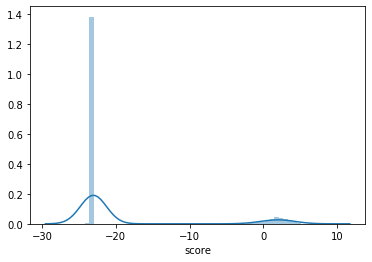

In [30]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
    
        'objective': 'xentropy','metric': 'xentropy',

#            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
    'max_bin': 251, 'subsample': 0.8568075466885418, 'subsample_freq': 0.6610232339549584, 'learning_rate': 0.03670301000161497,
    'num_leaves': 10, 'feature_fraction': 0.564534629962923, 'bagging_freq': 2, 'min_child_samples': 7, 'lambda_l1': 0.017308511388897257,
    'lambda_l2': 0.01551615159581271
}
null_Importance_maker = Null_Importance(
    train_df.drop(columns=['jobflag', 'jobflag_2']),
    train_df['jobflag_2'],
    PARAMS,
    train_df['jobflag']
)

null_importance = null_Importance_maker.all_flow()
sns.distplot(null_importance['score'])
new_cols = null_importance[null_importance['score']>-15].col.tolist()
print(new_cols)

In [31]:
feature =['machinelearn', 'data', 'softwar', 'busi', 'troubleshoot', 'model', 'client', 'analyt', 'algorithm', 'clinic', 'leverag',
          'server', 'engag', 'go', 'front', 'predict', 'research', 'opportun', 'mechan', 'backend', 'system', 'test', 'interfac',
          'market', 'dashboard', 'profession', 'continu', 'set', 'electron', 'consult', 'deep', 'expert', 'relev', 'embed', 'initi',
          'simul', 'person', 'scrum', 'cultur', 'specif', 'role', 'member', 'fix', 'tool', 'dataset', 'stakehold', 'find', 'transform',
          'applic', 'insight', 'gap', 'will', 'learn', 'scale', 'configur', 'supplier', 'equip', 'throughout', 'engin', 'safeti', 'present',
          'sale', 'sourc', 'can', 'field', 'servic', 'desir', 'non', 'technic', 'control', 'commiss', 'explor', 'debug', 'task', 'scientist',
          'call', 'window', 'lead', 'email', 'manufactur', 'healthcar', 'mobil', 'interpret', 'access', 'open', 'via', 'necessari', 'multipl', 
          'regular', 'collect', 'maintain', 'larg', 'modifi', 'pipelin', 'referr', 'approach', 'product', 'confer', 'identifi', 'complianc',
          'contribut', 'potenti', 'requir', 'assembl', 'depend', 'code', 'relat', 'latest', 'organ', 'self', 'secur', 'qa', 'oper', 'overal',
          'script', 'defin', 'review', 'audienc', 'ongo', 'unit', 'term', 'increas', 'dynam', 'prototyp', 'develop', 'ai', 'leadership',
          'respons', 'pre', 'perform', 'caus', 'program', 'price', 'exploratori', 'scienc', 'educ', 'includ', 'flow', 'log', 'polici',
          'object', 'implement', 'particip', 'resid', 'propos', 'team', 'architectur', 'sell', 'stori', 'inform', 'excel', 'integr',
          'statu', 'exist', 'rigor', 'custom', 'construct', 'inspect', 'analys', 'standard', 'estim', 'address', 'goal', 'support',
          'network', 'defect', 'roadmap', 'point', 'use', 'problem', 'coordin', 'progress', 'disciplin', 'innov', 'state', 'date',
          'post', 'promot', 'optim', 'may', 'enhanc', 'deploy', 'verifi', 'agil', 'document', 'python', 'methodolog', 'manner', 'issu',
          'repres', 'map', 'upgrad', 'comput', 'group', 'hoc', 'capac', 'well', 'proactiv', 'metric', 'facilit', 'strateg', 'assist',
          'enabl', 'net', 'across', 'queri', 'agre', 'independ', 'creation', 'multi', 'report', 'establish', 'activ', 'consist', 'root',
          'differ', 'analysi', 'area', 'domain', 'need', 'autom', 'achiev', 'capabl', 'monitor', 'rule', 'prepar', 'extract', 'solut',
          'adher', 'principl', 'discuss', 'critic', 'life', 'mission', 'vehicl', 'compani', 'deliver', 'practic', 'benefit', 'java', 
          'travel', 'migrat', 'result', 'microsoft', 'knowledg', 'hardwar', 'databas', 'must', 'guidanc', 'challeng', 'resolut', 
          'process', 'explain', 'new', 'interact', 'good', 'collabor', 'method', 'abl', 'aw', 'relationship', 'updat', 'site', 'medic',
          'protocol', 'cloud', 'coach', 'success', 'decis', 'gather', 'valid', 'complex', 'vendor', 'detail', 'duti', 'assess', 'bug',
          'key', 'stream', 'edg', 'design', 'project', 'expand', 'small', 'correct', 'peer', 'scalabl', 'technolog', 'select', 'matter',
          'clearli', 'reliabl', 'execut', 'function', 'skill', 'partnership', 'within', 'ensur', 'base', 'vision', 'orient', 'order',
          'instal', 'way', 'translat', 'direct', 'partner', 'produc', 'act', 'behavior', 'sql', 'obtain', 'level', 'action', 'share', 
          'compon', 'high', 'cycl', 'appropri', 'commun', 'modul', 'mentor', 'deadlin', 'qualifi', 'abil', 'follow', 'contract', 'build',
          'question', 'verif', 'accur', 'experi', 'form', 'resolv', 'measur', 'util', 'effici', 'close', 'environ', 'outcom', 'align',
          'limit', 'draw', 'improv', 'current', 'full', 'prospect', 'scope', 'solv', 'track', 'think', 'statist', 'request', 'back',
          'highli', 'train', 'help', 'featur', 'work', 'senior', 'api', 'quickli', 'conduct', 'corpor', 'strong', 'ad', 'deliv', 'demonstr',
          'infrastructur', 'recommend', 'escal', 'leader', 'daili', 'content', 'make', 'guid', 'procedur', 'gener', 'failur', 'job',
          'junior', 'individu', 'distribut', 'releas', 'cost', 'complet', 'analyz', 'hand', 'advanc', 'assign', 'extern', 'run', 'industri',
          'depart', 'web', 'part', 'event', 'languag', 'iter', 'accuraci', 'segment', 'growth', 'techniqu', 'enterpris', 'understand',
          'staff', 'formul', 'drive', 'timelin', 'personnel', 'depth', 'connect', 'qualiti', 'version', 'intern', 'accept', 'write', 
          'basic', 'moder', 'subject', 'avail', 'user', 'manag', 'accord', 'take', 'determin', 'workflow', 'machin', 'serv', 'suggest',
          'divers', 'librari', 'effect', 'advisor', 'idea', 'input', 'account', 'time', 'valu', 'materi', 'case', 'top', 'regul', 'acquisit',
          'end', 'posit', 'effort', 'best', 'intellig', 'keep', 'global', 'futur', 'pattern', 'framework', 'stay', 'mainten', 'definit',
          'strategi', 'detect', 'face', 'creat', 'meet', 'met', 'concept', 'administr', 'schedul', 'devop', 'chang', 'incid', 'store',
          'digit', 'evalu', 'resourc', 'creativ', 'core', 'parti', 'risk', 'provid', 'tune', 'trend', 'real', 'grow', 'plan', 'employe',
          'govern', 'proof', 'regard', 'visual', 'approv', 'etc', 'region', 'appli', 'like', 'analyst', 'refin', 'deriv', 'expertis',
          'variou', 'influenc', 'addit', 'outsid', 'stack', 'overse', 'purpos', 'thought', 'gain', 'candid', 'organiz', 'novel', 'next',
          'cluster', 'priorit', 'prior', 'focu', 'commerci', 'deliveri', 'devic', 'platform', 'structur']
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2', 'jobflag')
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')#maximize
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's cross_entropy: 0.448319	valid_1's cross_entropy: 0.542598
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's cross_entropy: 0.427005	valid_1's cross_entropy: 0.480785
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's cross_entropy: 0.48064	valid_1's cross_entropy: 0.505116
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's cross_entropy: 0.405695	valid_1's cross_entropy: 0.514268
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's cross_entropy: 0.452137	valid_1's cross_entropy: 0.541907


[I 2020-08-19 21:32:49,992] Finished trial#0 with value: 0.38503710090112353 with parameters: {'max_bin': 81, 'subsample': 0.48075488373508574, 'subsample_freq': 0.4242411291528851, 'learning_rate': 0.27306218632637286, 'num_leaves': 8, 'feature_fraction': 0.7546391881554151, 'bagging_freq': 5, 'min_child_samples': 11, 'lambda_l1': 0.037528799817341384, 'lambda_l2': 0.00016688175104919621}. Best is trial#0 with value: 0.38503710090112353.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	training's cross_entropy: 0.505005	valid_1's cross_entropy: 0.55256
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.468535	valid_1's cross_entropy: 0.498353
Early stopping, best iteration is:
[300]	training's cross_entropy: 0.486338	valid_1's cross_entropy: 0.49749
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	training's cross_entropy: 0.508702	valid_1's cross_entropy: 0.509977
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's cross_entropy: 0.499102	valid_1's cross_entropy: 0.538781
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's cross_entropy: 0.503279	valid_1's cross_entropy: 0.562292


[I 2020-08-19 21:32:51,476] Finished trial#1 with value: 0.40548580187526273 with parameters: {'max_bin': 249, 'subsample': 0.8748160048428733, 'subsample_freq': 0.6124501708282579, 'learning_rate': 0.04654615940047315, 'num_leaves': 10, 'feature_fraction': 0.9119688387107739, 'bagging_freq': 5, 'min_child_samples': 64, 'lambda_l1': 0.24134342366656034, 'lambda_l2': 0.00017018211918081453}. Best is trial#0 with value: 0.38503710090112353.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's cross_entropy: 0.513806	valid_1's cross_entropy: 0.558151
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.495642	valid_1's cross_entropy: 0.516985
Early stopping, best iteration is:
[455]	training's cross_entropy: 0.499465	valid_1's cross_entropy: 0.513478
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's cross_entropy: 0.528695	valid_1's cross_entropy: 0.527768
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	training's cross_entropy: 0.519125	valid_1's cross_entropy: 0.545416
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's cross_entropy: 0.521219	valid_1's cross_entropy: 0.571664


[I 2020-08-19 21:32:52,833] Finished trial#2 with value: 0.41732328749995795 with parameters: {'max_bin': 110, 'subsample': 0.7882275216880399, 'subsample_freq': 0.5304347765831046, 'learning_rate': 0.1557960414139209, 'num_leaves': 5, 'feature_fraction': 0.6231339124131043, 'bagging_freq': 6, 'min_child_samples': 82, 'lambda_l1': 0.00039330341694036815, 'lambda_l2': 0.020814942276868646}. Best is trial#0 with value: 0.38503710090112353.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's cross_entropy: 0.519263	valid_1's cross_entropy: 0.557281
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's cross_entropy: 0.488905	valid_1's cross_entropy: 0.490107
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[187]	training's cross_entropy: 0.48449	valid_1's cross_entropy: 0.516462
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	training's cross_entropy: 0.5209	valid_1's cross_entropy: 0.54497
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	training's cross_entropy: 0.530567	valid_1's cross_entropy: 0.568453


[I 2020-08-19 21:32:54,183] Finished trial#3 with value: 0.4098394171380912 with parameters: {'max_bin': 277, 'subsample': 0.5499972544841978, 'subsample_freq': 0.8975040568585582, 'learning_rate': 0.17038033190525154, 'num_leaves': 7, 'feature_fraction': 0.6898884459372057, 'bagging_freq': 4, 'min_child_samples': 48, 'lambda_l1': 0.006131939991113273, 'lambda_l2': 0.13140749155085824}. Best is trial#0 with value: 0.38503710090112353.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[58]	training's cross_entropy: 0.499429	valid_1's cross_entropy: 0.554023
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.427983	valid_1's cross_entropy: 0.499514
Early stopping, best iteration is:
[456]	training's cross_entropy: 0.432195	valid_1's cross_entropy: 0.495213
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's cross_entropy: 0.46626	valid_1's cross_entropy: 0.507615
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[149]	training's cross_entropy: 0.473128	valid_1's cross_entropy: 0.523963
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's cross_entropy: 0.509882	valid_1's cross_entropy: 0.564813


[I 2020-08-19 21:32:55,713] Finished trial#4 with value: 0.40188899280675294 with parameters: {'max_bin': 96, 'subsample': 0.568029885652493, 'subsample_freq': 0.5982565415614283, 'learning_rate': 0.07665355856139956, 'num_leaves': 10, 'feature_fraction': 0.9733623610314431, 'bagging_freq': 6, 'min_child_samples': 38, 'lambda_l1': 0.0997514511318425, 'lambda_l2': 0.003247314137750326}. Best is trial#0 with value: 0.38503710090112353.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[289]	training's cross_entropy: 0.42649	valid_1's cross_entropy: 0.533649
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.410316	valid_1's cross_entropy: 0.463127
Early stopping, best iteration is:
[490]	training's cross_entropy: 0.411608	valid_1's cross_entropy: 0.462261
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[227]	training's cross_entropy: 0.45031	valid_1's cross_entropy: 0.496588
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.399139	valid_1's cross_entropy: 0.50041
Early stopping, best iteration is:
[418]	training's cross_entropy: 0.410224	valid_1's cross_entropy: 0.499337
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[241]	training's cross_entropy: 0.442366	valid_1's cross_entropy: 0.

[I 2020-08-19 21:32:57,452] Finished trial#5 with value: 0.37220049238966946 with parameters: {'max_bin': 51, 'subsample': 0.6165610855866832, 'subsample_freq': 0.8081182102849487, 'learning_rate': 0.048018416873366006, 'num_leaves': 7, 'feature_fraction': 0.681100823244744, 'bagging_freq': 1, 'min_child_samples': 10, 'lambda_l1': 0.06975667506865954, 'lambda_l2': 1.2489229136717863}. Best is trial#5 with value: 0.37220049238966946.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's cross_entropy: 0.460479	valid_1's cross_entropy: 0.533434
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's cross_entropy: 0.394669	valid_1's cross_entropy: 0.465967
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[92]	training's cross_entropy: 0.432582	valid_1's cross_entropy: 0.492141
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's cross_entropy: 0.400251	valid_1's cross_entropy: 0.500411
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	training's cross_entropy: 0.424861	valid_1's cross_entropy: 0.519159


[I 2020-08-19 21:32:58,944] Finished trial#6 with value: 0.37035828693561623 with parameters: {'max_bin': 285, 'subsample': 0.8108747695668466, 'subsample_freq': 0.8515336788234229, 'learning_rate': 0.10604383385139285, 'num_leaves': 9, 'feature_fraction': 0.7110372978157977, 'bagging_freq': 4, 'min_child_samples': 15, 'lambda_l1': 0.22552751880458158, 'lambda_l2': 0.007134012791386575}. Best is trial#6 with value: 0.37035828693561623.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[198]	training's cross_entropy: 0.462813	valid_1's cross_entropy: 0.544619
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.449785	valid_1's cross_entropy: 0.483035
Early stopping, best iteration is:
[499]	training's cross_entropy: 0.449818	valid_1's cross_entropy: 0.482809
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[156]	training's cross_entropy: 0.477909	valid_1's cross_entropy: 0.508607
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[219]	training's cross_entropy: 0.462614	valid_1's cross_entropy: 0.518039
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[151]	training's cross_entropy: 0.47379	valid_1's cross_entropy: 0.535539


[I 2020-08-19 21:33:00,405] Finished trial#7 with value: 0.38878429404643083 with parameters: {'max_bin': 282, 'subsample': 0.8828739352515964, 'subsample_freq': 0.42801235004313387, 'learning_rate': 0.07406132265397643, 'num_leaves': 6, 'feature_fraction': 0.4924510746900509, 'bagging_freq': 3, 'min_child_samples': 36, 'lambda_l1': 0.0008604582934562638, 'lambda_l2': 0.00017294365155420393}. Best is trial#6 with value: 0.37035828693561623.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's cross_entropy: 0.521361	valid_1's cross_entropy: 0.557878
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.498058	valid_1's cross_entropy: 0.503578
Early stopping, best iteration is:
[548]	training's cross_entropy: 0.495166	valid_1's cross_entropy: 0.501739
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's cross_entropy: 0.511853	valid_1's cross_entropy: 0.514656
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's cross_entropy: 0.510656	valid_1's cross_entropy: 0.542266
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's cross_entropy: 0.512474	valid_1's cross_entropy: 0.563505


[I 2020-08-19 21:33:01,855] Finished trial#8 with value: 0.4101057778719063 with parameters: {'max_bin': 170, 'subsample': 0.7409729015404998, 'subsample_freq': 0.7001514596369791, 'learning_rate': 0.07052060434377332, 'num_leaves': 6, 'feature_fraction': 0.6368996621980569, 'bagging_freq': 3, 'min_child_samples': 70, 'lambda_l1': 0.00018727273318657766, 'lambda_l2': 0.0035258751065027037}. Best is trial#6 with value: 0.37035828693561623.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's cross_entropy: 0.561889	valid_1's cross_entropy: 0.590237
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[178]	training's cross_entropy: 0.547239	valid_1's cross_entropy: 0.549331
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's cross_entropy: 0.554087	valid_1's cross_entropy: 0.553687
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[193]	training's cross_entropy: 0.536238	valid_1's cross_entropy: 0.581759
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's cross_entropy: 0.563014	valid_1's cross_entropy: 0.583901


[I 2020-08-19 21:33:03,239] Finished trial#9 with value: 0.4462427952043045 with parameters: {'max_bin': 181, 'subsample': 0.5812822450347082, 'subsample_freq': 0.5204661855736804, 'learning_rate': 0.18569011965170218, 'num_leaves': 9, 'feature_fraction': 0.4596640890292001, 'bagging_freq': 1, 'min_child_samples': 81, 'lambda_l1': 0.00217725350875664, 'lambda_l2': 0.00018205004973542596}. Best is trial#6 with value: 0.37035828693561623.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's cross_entropy: 0.484779	valid_1's cross_entropy: 0.546528
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	training's cross_entropy: 0.50702	valid_1's cross_entropy: 0.511928
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	training's cross_entropy: 0.482289	valid_1's cross_entropy: 0.505393
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	training's cross_entropy: 0.493254	valid_1's cross_entropy: 0.536794
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	training's cross_entropy: 0.494453	valid_1's cross_entropy: 0.544711


[I 2020-08-19 21:33:04,515] Finished trial#10 with value: 0.3982835452953114 with parameters: {'max_bin': 220, 'subsample': 0.7322075516927234, 'subsample_freq': 0.8943839583094483, 'learning_rate': 0.44882277878090054, 'num_leaves': 9, 'feature_fraction': 0.8458937168458153, 'bagging_freq': 7, 'min_child_samples': 22, 'lambda_l1': 7.849962085101851, 'lambda_l2': 8.284116505255644}. Best is trial#6 with value: 0.37035828693561623.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.446997	valid_1's cross_entropy: 0.538937
Early stopping, best iteration is:
[467]	training's cross_entropy: 0.450498	valid_1's cross_entropy: 0.538303
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.463395	valid_1's cross_entropy: 0.481406
[1000]	training's cross_entropy: 0.425717	valid_1's cross_entropy: 0.46868
Did not meet early stopping. Best iteration is:
[1400]	training's cross_entropy: 0.404942	valid_1's cross_entropy: 0.46411
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.456262	valid_1's cross_entropy: 0.497642
Early stopping, best iteration is:
[497]	training's cross_entropy: 0.45654	valid_1's cross_entropy: 0.497536
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.453616	valid_1's cross_entropy: 0.512956
[1000]	training's cross_entropy: 0.

[I 2020-08-19 21:33:07,166] Finished trial#11 with value: 0.37414544693770013 with parameters: {'max_bin': 148, 'subsample': 0.6442893343227328, 'subsample_freq': 0.7881867970136317, 'learning_rate': 0.030103437411023483, 'num_leaves': 8, 'feature_fraction': 0.7943328465475676, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 1.1745446744814685, 'lambda_l2': 4.597563907027934}. Best is trial#6 with value: 0.37035828693561623.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.469887	valid_1's cross_entropy: 0.537924
Early stopping, best iteration is:
[504]	training's cross_entropy: 0.469566	valid_1's cross_entropy: 0.537787
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.486108	valid_1's cross_entropy: 0.485949
[1000]	training's cross_entropy: 0.460095	valid_1's cross_entropy: 0.47217
Did not meet early stopping. Best iteration is:
[1400]	training's cross_entropy: 0.449603	valid_1's cross_entropy: 0.471488
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.479842	valid_1's cross_entropy: 0.506318
Early stopping, best iteration is:
[499]	training's cross_entropy: 0.479932	valid_1's cross_entropy: 0.506238
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.476363	valid_1's cross_entropy: 0.517497
Early stopping, best iteration is

[I 2020-08-19 21:33:08,968] Finished trial#12 with value: 0.38107521597929295 with parameters: {'max_bin': 300, 'subsample': 0.6692820353593079, 'subsample_freq': 0.8100483464129166, 'learning_rate': 0.03423454641658633, 'num_leaves': 4, 'feature_fraction': 0.5763689275309205, 'bagging_freq': 2, 'min_child_samples': 21, 'lambda_l1': 0.8304104119417078, 'lambda_l2': 0.6405632278040205}. Best is trial#6 with value: 0.37035828693561623.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	training's cross_entropy: 0.402609	valid_1's cross_entropy: 0.52208
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[209]	training's cross_entropy: 0.381174	valid_1's cross_entropy: 0.460699
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[156]	training's cross_entropy: 0.398848	valid_1's cross_entropy: 0.488208
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	training's cross_entropy: 0.404032	valid_1's cross_entropy: 0.497609
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[294]	training's cross_entropy: 0.340666	valid_1's cross_entropy: 0.492259


[I 2020-08-19 21:33:10,663] Finished trial#13 with value: 0.3643093632375454 with parameters: {'max_bin': 55, 'subsample': 0.8254934613413225, 'subsample_freq': 0.7996124107380403, 'learning_rate': 0.09627462889222417, 'num_leaves': 7, 'feature_fraction': 0.7156679794777023, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.014886590123299587, 'lambda_l2': 0.006026431320645201}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's cross_entropy: 0.46159	valid_1's cross_entropy: 0.535527
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	training's cross_entropy: 0.418549	valid_1's cross_entropy: 0.470109
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's cross_entropy: 0.452838	valid_1's cross_entropy: 0.5015
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	training's cross_entropy: 0.4281	valid_1's cross_entropy: 0.51901
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	training's cross_entropy: 0.451962	valid_1's cross_entropy: 0.521395


[I 2020-08-19 21:33:12,110] Finished trial#14 with value: 0.37929302320795955 with parameters: {'max_bin': 225, 'subsample': 0.818492686741702, 'subsample_freq': 0.7207148173433905, 'learning_rate': 0.10582755834270473, 'num_leaves': 8, 'feature_fraction': 0.7760487611054934, 'bagging_freq': 3, 'min_child_samples': 25, 'lambda_l1': 0.010404844936678705, 'lambda_l2': 0.00800510080027471}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's cross_entropy: 0.448334	valid_1's cross_entropy: 0.543429
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.436648	valid_1's cross_entropy: 0.472481
Early stopping, best iteration is:
[794]	training's cross_entropy: 0.418838	valid_1's cross_entropy: 0.467983
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	training's cross_entropy: 0.453209	valid_1's cross_entropy: 0.500656
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.432812	valid_1's cross_entropy: 0.510661
Early stopping, best iteration is:
[424]	training's cross_entropy: 0.43406	valid_1's cross_entropy: 0.510358
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.424726	valid_1's cross_entropy: 0.529808
Early stopping, best itera

[I 2020-08-19 21:33:13,883] Finished trial#15 with value: 0.37949288318374996 with parameters: {'max_bin': 53, 'subsample': 0.8258844187861629, 'subsample_freq': 0.8577864610466276, 'learning_rate': 0.10370797998150551, 'num_leaves': 9, 'feature_fraction': 0.5467000514442049, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 3.735749699058515, 'lambda_l2': 0.0011185177888065351}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's cross_entropy: 0.511707	valid_1's cross_entropy: 0.559546
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[70]	training's cross_entropy: 0.519408	valid_1's cross_entropy: 0.514957
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's cross_entropy: 0.524081	valid_1's cross_entropy: 0.529529
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	training's cross_entropy: 0.512244	valid_1's cross_entropy: 0.541371
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15]	training's cross_entropy: 0.530291	valid_1's cross_entropy: 0.573808


[I 2020-08-19 21:33:15,157] Finished trial#16 with value: 0.41658135126475293 with parameters: {'max_bin': 138, 'subsample': 0.898425422640311, 'subsample_freq': 0.7374628575230159, 'learning_rate': 0.2823219296261089, 'num_leaves': 6, 'feature_fraction': 0.856539167541054, 'bagging_freq': 2, 'min_child_samples': 95, 'lambda_l1': 0.01576818599603497, 'lambda_l2': 0.07919700702808181}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's cross_entropy: 0.490091	valid_1's cross_entropy: 0.547413
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.459964	valid_1's cross_entropy: 0.487217
Early stopping, best iteration is:
[456]	training's cross_entropy: 0.462635	valid_1's cross_entropy: 0.481789
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	training's cross_entropy: 0.484609	valid_1's cross_entropy: 0.508565
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[247]	training's cross_entropy: 0.47041	valid_1's cross_entropy: 0.510407
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's cross_entropy: 0.471822	valid_1's cross_entropy: 0.543801


[I 2020-08-19 21:33:16,551] Finished trial#17 with value: 0.3905578390383732 with parameters: {'max_bin': 189, 'subsample': 0.7207239610113869, 'subsample_freq': 0.8482295035469852, 'learning_rate': 0.12953123405408792, 'num_leaves': 4, 'feature_fraction': 0.7079396238101604, 'bagging_freq': 5, 'min_child_samples': 33, 'lambda_l1': 0.3576870541584769, 'lambda_l2': 0.0007939118737267807}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's cross_entropy: 0.521896	valid_1's cross_entropy: 0.566749
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.52659	valid_1's cross_entropy: 0.522103
Early stopping, best iteration is:
[511]	training's cross_entropy: 0.526208	valid_1's cross_entropy: 0.520717
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.525784	valid_1's cross_entropy: 0.534929
Early stopping, best iteration is:
[496]	training's cross_entropy: 0.526336	valid_1's cross_entropy: 0.534129
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.513278	valid_1's cross_entropy: 0.550594
Early stopping, best iteration is:
[634]	training's cross_entropy: 0.507573	valid_1's cross_entropy: 0.547413
Training until validation scores don't improve for 200 rounds
Early stopping, best itera

[I 2020-08-19 21:33:18,191] Finished trial#18 with value: 0.42317282632298886 with parameters: {'max_bin': 247, 'subsample': 0.4038558765084289, 'subsample_freq': 0.753449117787959, 'learning_rate': 0.05297260922939349, 'num_leaves': 10, 'feature_fraction': 0.4139663151453164, 'bagging_freq': 2, 'min_child_samples': 51, 'lambda_l1': 0.003496415090563216, 'lambda_l2': 0.02608134045135763}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's cross_entropy: 0.449737	valid_1's cross_entropy: 0.534003
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's cross_entropy: 0.417067	valid_1's cross_entropy: 0.464626
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's cross_entropy: 0.457459	valid_1's cross_entropy: 0.502262
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's cross_entropy: 0.418202	valid_1's cross_entropy: 0.501221
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's cross_entropy: 0.446212	valid_1's cross_entropy: 0.516392


[I 2020-08-19 21:33:19,601] Finished trial#19 with value: 0.37400019026100045 with parameters: {'max_bin': 129, 'subsample': 0.7935410628169305, 'subsample_freq': 0.6646066832647247, 'learning_rate': 0.23706107626844933, 'num_leaves': 8, 'feature_fraction': 0.7245276676670797, 'bagging_freq': 4, 'min_child_samples': 16, 'lambda_l1': 0.16102739547373696, 'lambda_l2': 0.1526312408284152}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	training's cross_entropy: 0.466247	valid_1's cross_entropy: 0.541028
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.433924	valid_1's cross_entropy: 0.473269
Early stopping, best iteration is:
[377]	training's cross_entropy: 0.444118	valid_1's cross_entropy: 0.470954
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[188]	training's cross_entropy: 0.460759	valid_1's cross_entropy: 0.506172
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[197]	training's cross_entropy: 0.454803	valid_1's cross_entropy: 0.520036
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's cross_entropy: 0.466559	valid_1's cross_entropy: 0.526762


[I 2020-08-19 21:33:21,046] Finished trial#20 with value: 0.38120156627569624 with parameters: {'max_bin': 70, 'subsample': 0.8608273450931617, 'subsample_freq': 0.8607304031102498, 'learning_rate': 0.09009273079738808, 'num_leaves': 5, 'feature_fraction': 0.8259550198763516, 'bagging_freq': 3, 'min_child_samples': 29, 'lambda_l1': 0.029445326738305123, 'lambda_l2': 0.0007424272897382289}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[292]	training's cross_entropy: 0.404587	valid_1's cross_entropy: 0.527688
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.378705	valid_1's cross_entropy: 0.457558
Early stopping, best iteration is:
[455]	training's cross_entropy: 0.386245	valid_1's cross_entropy: 0.457297
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[225]	training's cross_entropy: 0.433503	valid_1's cross_entropy: 0.495285
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.370964	valid_1's cross_entropy: 0.499547
Early stopping, best iteration is:
[472]	training's cross_entropy: 0.375438	valid_1's cross_entropy: 0.499023
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.369966	valid_1's cross_entropy: 0.518041
Early stopping, best iter

[I 2020-08-19 21:33:23,102] Finished trial#21 with value: 0.3698620875418741 with parameters: {'max_bin': 50, 'subsample': 0.6445457465682817, 'subsample_freq': 0.8083865922326656, 'learning_rate': 0.05548211866916555, 'num_leaves': 7, 'feature_fraction': 0.658606298640407, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.06583133691084432, 'lambda_l2': 0.8965344126245264}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	training's cross_entropy: 0.457041	valid_1's cross_entropy: 0.535595
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[278]	training's cross_entropy: 0.431368	valid_1's cross_entropy: 0.467157
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[188]	training's cross_entropy: 0.445919	valid_1's cross_entropy: 0.499074
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[293]	training's cross_entropy: 0.419564	valid_1's cross_entropy: 0.500226
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[239]	training's cross_entropy: 0.428501	valid_1's cross_entropy: 0.521481


[I 2020-08-19 21:33:24,832] Finished trial#22 with value: 0.37432820262255256 with parameters: {'max_bin': 55, 'subsample': 0.6909775093534729, 'subsample_freq': 0.7747941333251772, 'learning_rate': 0.060694976621463045, 'num_leaves': 7, 'feature_fraction': 0.6521215378839076, 'bagging_freq': 2, 'min_child_samples': 14, 'lambda_l1': 0.6653918380862069, 'lambda_l2': 0.007935696249081975}. Best is trial#13 with value: 0.3643093632375454.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's cross_entropy: 0.440861	valid_1's cross_entropy: 0.524041
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[221]	training's cross_entropy: 0.385733	valid_1's cross_entropy: 0.450079
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[187]	training's cross_entropy: 0.393489	valid_1's cross_entropy: 0.491457
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[278]	training's cross_entropy: 0.353391	valid_1's cross_entropy: 0.489092
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[254]	training's cross_entropy: 0.364805	valid_1's cross_entropy: 0.502581


[I 2020-08-19 21:33:26,520] Finished trial#23 with value: 0.36257767040049116 with parameters: {'max_bin': 106, 'subsample': 0.771099403535024, 'subsample_freq': 0.8400465785558096, 'learning_rate': 0.12874289996372995, 'num_leaves': 6, 'feature_fraction': 0.575992729020878, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.02809628431883306, 'lambda_l2': 0.5460611272989466}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.402742	valid_1's cross_entropy: 0.53065
Early stopping, best iteration is:
[384]	training's cross_entropy: 0.422812	valid_1's cross_entropy: 0.529063
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.420053	valid_1's cross_entropy: 0.460909
[1000]	training's cross_entropy: 0.364001	valid_1's cross_entropy: 0.45599
Early stopping, best iteration is:
[987]	training's cross_entropy: 0.365152	valid_1's cross_entropy: 0.454959
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.411726	valid_1's cross_entropy: 0.495582
Early stopping, best iteration is:
[449]	training's cross_entropy: 0.420572	valid_1's cross_entropy: 0.495016
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.408765	valid_1's cross_entropy: 0.49853
Early stopping, best iteration is:
[645]	training

[I 2020-08-19 21:33:28,712] Finished trial#24 with value: 0.3653536850231641 with parameters: {'max_bin': 77, 'subsample': 0.7586815044987407, 'subsample_freq': 0.8180030515375469, 'learning_rate': 0.03794267375236372, 'num_leaves': 6, 'feature_fraction': 0.5608250898407673, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.039198564056009265, 'lambda_l2': 0.6048673696692731}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.409278	valid_1's cross_entropy: 0.529533
Early stopping, best iteration is:
[501]	training's cross_entropy: 0.409115	valid_1's cross_entropy: 0.529451
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.426053	valid_1's cross_entropy: 0.462377
[1000]	training's cross_entropy: 0.369272	valid_1's cross_entropy: 0.454946
Early stopping, best iteration is:
[952]	training's cross_entropy: 0.373769	valid_1's cross_entropy: 0.453448
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.418865	valid_1's cross_entropy: 0.495097
Early stopping, best iteration is:
[500]	training's cross_entropy: 0.418865	valid_1's cross_entropy: 0.495097
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.415796	valid_1's cross_entropy: 0.496704
Early stopping, best iteration is:
[754]	train

[I 2020-08-19 21:33:30,926] Finished trial#25 with value: 0.36448414394748385 with parameters: {'max_bin': 108, 'subsample': 0.764351377049171, 'subsample_freq': 0.8929835509501112, 'learning_rate': 0.04079912826028, 'num_leaves': 5, 'feature_fraction': 0.5631681090577783, 'bagging_freq': 3, 'min_child_samples': 5, 'lambda_l1': 0.0194141481275271, 'lambda_l2': 0.3465046961726588}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's cross_entropy: 0.492446	valid_1's cross_entropy: 0.546449
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.460618	valid_1's cross_entropy: 0.496087
[1000]	training's cross_entropy: 0.430023	valid_1's cross_entropy: 0.494704
Early stopping, best iteration is:
[1101]	training's cross_entropy: 0.424825	valid_1's cross_entropy: 0.492427
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	training's cross_entropy: 0.494439	valid_1's cross_entropy: 0.509447
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[223]	training's cross_entropy: 0.473199	valid_1's cross_entropy: 0.519752
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's cross_entropy: 0.483383	valid_1's cross_entropy

[I 2020-08-19 21:33:32,576] Finished trial#26 with value: 0.39428395453641774 with parameters: {'max_bin': 108, 'subsample': 0.842650513671704, 'subsample_freq': 0.895755253593629, 'learning_rate': 0.13396321269695682, 'num_leaves': 5, 'feature_fraction': 0.5046788720555371, 'bagging_freq': 3, 'min_child_samples': 43, 'lambda_l1': 0.002229802701621502, 'lambda_l2': 2.4680754312444444}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[257]	training's cross_entropy: 0.467943	valid_1's cross_entropy: 0.54191
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.452122	valid_1's cross_entropy: 0.468674
[1000]	training's cross_entropy: 0.421976	valid_1's cross_entropy: 0.463228
Early stopping, best iteration is:
[845]	training's cross_entropy: 0.428987	valid_1's cross_entropy: 0.460938
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[275]	training's cross_entropy: 0.47653	valid_1's cross_entropy: 0.50523
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.440827	valid_1's cross_entropy: 0.512507
Early stopping, best iteration is:
[580]	training's cross_entropy: 0.433666	valid_1's cross_entropy: 0.511364
Training until validation scores don't improve for 200 rounds
Early stopping, best iterat

[I 2020-08-19 21:33:34,420] Finished trial#27 with value: 0.37588692850518823 with parameters: {'max_bin': 119, 'subsample': 0.7832786056808895, 'subsample_freq': 0.8787301918149092, 'learning_rate': 0.03974016716461589, 'num_leaves': 5, 'feature_fraction': 0.5984074234346669, 'bagging_freq': 5, 'min_child_samples': 20, 'lambda_l1': 0.013301074919346784, 'lambda_l2': 0.15446608767144415}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's cross_entropy: 0.523402	valid_1's cross_entropy: 0.560612
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's cross_entropy: 0.509911	valid_1's cross_entropy: 0.499706
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's cross_entropy: 0.5268	valid_1's cross_entropy: 0.517507
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[187]	training's cross_entropy: 0.464243	valid_1's cross_entropy: 0.544624
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's cross_entropy: 0.516671	valid_1's cross_entropy: 0.559625


[I 2020-08-19 21:33:35,861] Finished trial#28 with value: 0.40911769540954696 with parameters: {'max_bin': 155, 'subsample': 0.7012528866944744, 'subsample_freq': 0.7658311104015109, 'learning_rate': 0.41605196233264496, 'num_leaves': 6, 'feature_fraction': 0.41053423916595844, 'bagging_freq': 4, 'min_child_samples': 59, 'lambda_l1': 0.0059114248107820285, 'lambda_l2': 0.32241270862590843}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	training's cross_entropy: 0.44789	valid_1's cross_entropy: 0.535938
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's cross_entropy: 0.410666	valid_1's cross_entropy: 0.465513
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's cross_entropy: 0.465032	valid_1's cross_entropy: 0.507021
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's cross_entropy: 0.42611	valid_1's cross_entropy: 0.504954
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's cross_entropy: 0.420695	valid_1's cross_entropy: 0.50647


[I 2020-08-19 21:33:37,380] Finished trial#29 with value: 0.37243267720591194 with parameters: {'max_bin': 92, 'subsample': 0.7637378518299642, 'subsample_freq': 0.6825830851529047, 'learning_rate': 0.20952612802090612, 'num_leaves': 4, 'feature_fraction': 0.5254199203605782, 'bagging_freq': 2, 'min_child_samples': 10, 'lambda_l1': 0.02648949897234649, 'lambda_l2': 0.06723057962115715}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's cross_entropy: 0.465388	valid_1's cross_entropy: 0.537576
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's cross_entropy: 0.452509	valid_1's cross_entropy: 0.473601
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's cross_entropy: 0.473847	valid_1's cross_entropy: 0.512091
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's cross_entropy: 0.456676	valid_1's cross_entropy: 0.51419
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's cross_entropy: 0.477983	valid_1's cross_entropy: 0.535182


[I 2020-08-19 21:33:38,819] Finished trial#30 with value: 0.3817991582295636 with parameters: {'max_bin': 84, 'subsample': 0.8405155153664399, 'subsample_freq': 0.8322527597769618, 'learning_rate': 0.3008014283374363, 'num_leaves': 5, 'feature_fraction': 0.4567741577153819, 'bagging_freq': 6, 'min_child_samples': 27, 'lambda_l1': 0.0014608250354895837, 'lambda_l2': 0.2593414993811112}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.420105	valid_1's cross_entropy: 0.532076
Early stopping, best iteration is:
[501]	training's cross_entropy: 0.41996	valid_1's cross_entropy: 0.532058
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.437786	valid_1's cross_entropy: 0.4651
[1000]	training's cross_entropy: 0.387943	valid_1's cross_entropy: 0.453889
Early stopping, best iteration is:
[1152]	training's cross_entropy: 0.377126	valid_1's cross_entropy: 0.452735
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.430665	valid_1's cross_entropy: 0.49671
Early stopping, best iteration is:
[507]	training's cross_entropy: 0.429583	valid_1's cross_entropy: 0.496503
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.42716	valid_1's cross_entropy: 0.500677
Early stopping, best iteration is:
[755]	training'

[I 2020-08-19 21:33:41,267] Finished trial#31 with value: 0.3679448042954673 with parameters: {'max_bin': 71, 'subsample': 0.7617982198695858, 'subsample_freq': 0.8166015473141216, 'learning_rate': 0.03762821802292089, 'num_leaves': 6, 'feature_fraction': 0.5843045200118948, 'bagging_freq': 3, 'min_child_samples': 5, 'lambda_l1': 0.041991584464439485, 'lambda_l2': 1.8189328231552355}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.424388	valid_1's cross_entropy: 0.535648
Early stopping, best iteration is:
[565]	training's cross_entropy: 0.416067	valid_1's cross_entropy: 0.534638
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.442596	valid_1's cross_entropy: 0.467312
[1000]	training's cross_entropy: 0.397156	valid_1's cross_entropy: 0.459978
Early stopping, best iteration is:
[1036]	training's cross_entropy: 0.394775	valid_1's cross_entropy: 0.459477
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.434797	valid_1's cross_entropy: 0.500034
Early stopping, best iteration is:
[515]	training's cross_entropy: 0.432881	valid_1's cross_entropy: 0.499337
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.4313	valid_1's cross_entropy: 0.501052
Early stopping, best iteration is:
[761]	traini

[I 2020-08-19 21:33:43,570] Finished trial#32 with value: 0.3689668720619028 with parameters: {'max_bin': 69, 'subsample': 0.7440699816978577, 'subsample_freq': 0.878124885207328, 'learning_rate': 0.030085292164193676, 'num_leaves': 6, 'feature_fraction': 0.5619214910689027, 'bagging_freq': 3, 'min_child_samples': 11, 'lambda_l1': 0.024010641501648985, 'lambda_l2': 0.534218204408558}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.401613	valid_1's cross_entropy: 0.530343
Early stopping, best iteration is:
[415]	training's cross_entropy: 0.417052	valid_1's cross_entropy: 0.52736
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.418468	valid_1's cross_entropy: 0.46294
Early stopping, best iteration is:
[788]	training's cross_entropy: 0.378123	valid_1's cross_entropy: 0.45521
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.411156	valid_1's cross_entropy: 0.494366
Early stopping, best iteration is:
[516]	training's cross_entropy: 0.408582	valid_1's cross_entropy: 0.493427
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.4081	valid_1's cross_entropy: 0.504977
Early stopping, best iteration is:
[668]	training's cross_entropy: 0.382684	valid_1's cross_entropy: 0.502688
Training until va

[I 2020-08-19 21:33:45,696] Finished trial#33 with value: 0.36767625755829664 with parameters: {'max_bin': 99, 'subsample': 0.7758228736043511, 'subsample_freq': 0.7946115281477413, 'learning_rate': 0.040858531761855055, 'num_leaves': 5, 'feature_fraction': 0.6110212443200618, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.00726605794693794, 'lambda_l2': 0.04780550497366432}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's cross_entropy: 0.482983	valid_1's cross_entropy: 0.542885
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.380599	valid_1's cross_entropy: 0.479294
Early stopping, best iteration is:
[341]	training's cross_entropy: 0.405225	valid_1's cross_entropy: 0.473358
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's cross_entropy: 0.469518	valid_1's cross_entropy: 0.501239
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[289]	training's cross_entropy: 0.410027	valid_1's cross_entropy: 0.514353
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	training's cross_entropy: 0.453788	valid_1's cross_entropy: 0.531784


[I 2020-08-19 21:33:47,351] Finished trial#34 with value: 0.38378709459904004 with parameters: {'max_bin': 116, 'subsample': 0.6903239199115205, 'subsample_freq': 0.606775507397771, 'learning_rate': 0.1533210926846096, 'num_leaves': 7, 'feature_fraction': 0.7482785019679108, 'bagging_freq': 5, 'min_child_samples': 17, 'lambda_l1': 0.09430989452207335, 'lambda_l2': 4.566842778212861}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	training's cross_entropy: 0.445378	valid_1's cross_entropy: 0.5297
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.364372	valid_1's cross_entropy: 0.457318
Early stopping, best iteration is:
[349]	training's cross_entropy: 0.390744	valid_1's cross_entropy: 0.452848
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[188]	training's cross_entropy: 0.430116	valid_1's cross_entropy: 0.501949
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[283]	training's cross_entropy: 0.39682	valid_1's cross_entropy: 0.49353
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[255]	training's cross_entropy: 0.402401	valid_1's cross_entropy: 0.498878


[I 2020-08-19 21:33:49,069] Finished trial#35 with value: 0.3671079710085786 with parameters: {'max_bin': 80, 'subsample': 0.8598090303353105, 'subsample_freq': 0.8332808650610616, 'learning_rate': 0.0861939507904976, 'num_leaves': 6, 'feature_fraction': 0.4923862280799988, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 0.05291252466282986, 'lambda_l2': 0.37551346015065484}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[237]	training's cross_entropy: 0.404532	valid_1's cross_entropy: 0.528948
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.362049	valid_1's cross_entropy: 0.461449
Early stopping, best iteration is:
[334]	training's cross_entropy: 0.394198	valid_1's cross_entropy: 0.457635
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's cross_entropy: 0.434363	valid_1's cross_entropy: 0.502731
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.35409	valid_1's cross_entropy: 0.500632
Early stopping, best iteration is:
[313]	training's cross_entropy: 0.388925	valid_1's cross_entropy: 0.494486
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's cross_entropy: 0.398663	valid_1's cross_entropy: 

[I 2020-08-19 21:33:50,876] Finished trial#36 with value: 0.3693529296639967 with parameters: {'max_bin': 102, 'subsample': 0.801406780972483, 'subsample_freq': 0.8976516618870628, 'learning_rate': 0.06196105651595961, 'num_leaves': 7, 'feature_fraction': 0.549411470950841, 'bagging_freq': 4, 'min_child_samples': 10, 'lambda_l1': 0.01983952346594854, 'lambda_l2': 0.023075132480616913}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.424455	valid_1's cross_entropy: 0.532927
Early stopping, best iteration is:
[526]	training's cross_entropy: 0.421077	valid_1's cross_entropy: 0.532482
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.441028	valid_1's cross_entropy: 0.467872
[1000]	training's cross_entropy: 0.393887	valid_1's cross_entropy: 0.460666
Early stopping, best iteration is:
[935]	training's cross_entropy: 0.398704	valid_1's cross_entropy: 0.458761
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.434597	valid_1's cross_entropy: 0.498714
Early stopping, best iteration is:
[445]	training's cross_entropy: 0.442627	valid_1's cross_entropy: 0.498006
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.432318	valid_1's cross_entropy: 0.502088
[1000]	training's cross_entropy: 0.385878	vali

[I 2020-08-19 21:33:53,088] Finished trial#37 with value: 0.36953159912959654 with parameters: {'max_bin': 65, 'subsample': 0.7184334943084008, 'subsample_freq': 0.6351295791794438, 'learning_rate': 0.04551694373375932, 'num_leaves': 5, 'feature_fraction': 0.6287256093446101, 'bagging_freq': 5, 'min_child_samples': 5, 'lambda_l1': 0.14495209582682783, 'lambda_l2': 1.7639094883389244}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's cross_entropy: 0.476644	valid_1's cross_entropy: 0.542049
Training until validation scores don't improve for 200 rounds
[500]	training's cross_entropy: 0.410903	valid_1's cross_entropy: 0.476873
Early stopping, best iteration is:
[502]	training's cross_entropy: 0.41075	valid_1's cross_entropy: 0.476275
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	training's cross_entropy: 0.503358	valid_1's cross_entropy: 0.514247
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	training's cross_entropy: 0.44649	valid_1's cross_entropy: 0.516392
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's cross_entropy: 0.470712	valid_1's cross_entropy: 0.541375


[I 2020-08-19 21:33:54,659] Finished trial#38 with value: 0.38818009848924506 with parameters: {'max_bin': 126, 'subsample': 0.760239365008961, 'subsample_freq': 0.7223015984990253, 'learning_rate': 0.142235367502071, 'num_leaves': 6, 'feature_fraction': 0.6663928418413887, 'bagging_freq': 2, 'min_child_samples': 32, 'lambda_l1': 0.004544558925711507, 'lambda_l2': 0.013672833107026909}. Best is trial#23 with value: 0.36257767040049116.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's cross_entropy: 0.519531	valid_1's cross_entropy: 0.558357
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's cross_entropy: 0.510952	valid_1's cross_entropy: 0.503049
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's cross_entropy: 0.508205	valid_1's cross_entropy: 0.514515
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	training's cross_entropy: 0.510977	valid_1's cross_entropy: 0.543716
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's cross_entropy: 0.516099	valid_1's cross_entropy: 0.565613


[I 2020-08-19 21:33:56,140] Finished trial#39 with value: 0.41387994575722636 with parameters: {'max_bin': 87, 'subsample': 0.4969047202482182, 'subsample_freq': 0.5631042981424721, 'learning_rate': 0.11386367038970671, 'num_leaves': 7, 'feature_fraction': 0.4562046320458121, 'bagging_freq': 3, 'min_child_samples': 41, 'lambda_l1': 0.000642641033249414, 'lambda_l2': 0.22934814175603935}. Best is trial#23 with value: 0.36257767040049116.


0.36257767040049116
{'max_bin': 106, 'subsample': 0.771099403535024, 'subsample_freq': 0.8400465785558096, 'learning_rate': 0.12874289996372995, 'num_leaves': 6, 'feature_fraction': 0.575992729020878, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.02809628431883306, 'lambda_l2': 0.5460611272989466}


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's cross_entropy: 0.440861	valid_1's cross_entropy: 0.524041
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[221]	training's cross_entropy: 0.385733	valid_1's cross_entropy: 0.450079
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[187]	training's cross_entropy: 0.393489	valid_1's cross_entropy: 0.491457
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[278]	training's cross_entropy: 0.353391	valid_1's cross_entropy: 0.489092
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[254]	training's cross_entropy: 0.364805	valid_1's cross_entropy: 0.502581
0.7662913681337428


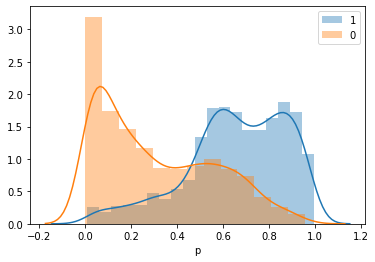

In [34]:
PARAMS={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    #'objective': 'tweedie','metric': 'tweedie',
     
    'objective': 'xentropy','metric': 'xentropy',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    'max_bin': 106, 'subsample': 0.771099403535024, 'subsample_freq': 0.8400465785558096, 'learning_rate': 0.12874289996372995,
    'num_leaves': 6, 'feature_fraction': 0.575992729020878, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.02809628431883306,
    'lambda_l2': 0.5460611272989466
}

score = 0
k = StratifiedKFold(n_splits=5)
off_df=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_data = train_df.iloc[trn,:]
    val_data = train_df.iloc[val,:]
    
    train_set= lgb.Dataset(trn_data[new_cols],  trn_data['jobflag_2'])
    val_set = lgb.Dataset(val_data[new_cols],  val_data['jobflag_2'])   
    
    model = lgb.train(
        train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
        early_stopping_rounds=200, verbose_eval=500
    )
    
    val_data['p'] = model.predict(val_data[new_cols])
    off_df.append(val_data[['jobflag', 'jobflag_2', 'p']])
    
off_df = pd.concat(off_df, axis=0)
off_df['pred'] = off_df.p.apply(lambda x: 1 if x>0.5 else 0)

print(metrics.accuracy_score(off_df.jobflag_2, off_df.pred))

sns.distplot(off_df[off_df.jobflag_2==1].p, label='1')
sns.distplot(off_df[off_df.jobflag_2==0].p, label='0')
plt.legend()

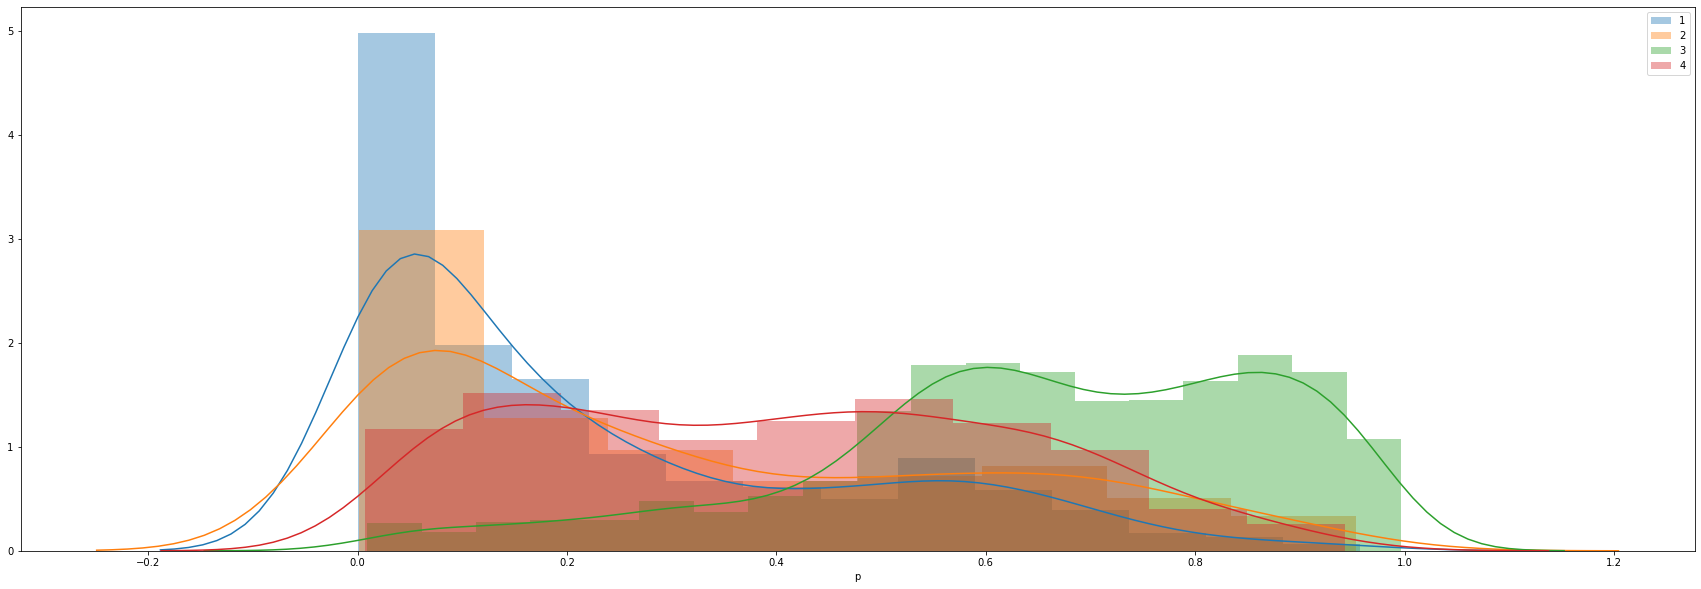

In [35]:
plt.figure(figsize=(30,10))
sns.distplot(off_df[off_df.jobflag==1].p, label='1')
sns.distplot(off_df[off_df.jobflag==2].p, label='2')
sns.distplot(off_df[off_df.jobflag==3].p, label='3')
sns.distplot(off_df[off_df.jobflag==4].p, label='4')
plt.legend()

In [38]:
print(list(set(['machinelearn', 'data', 'softwar', 'busi', 'troubleshoot', 'model', 'client', 'analyt', 'algorithm', 'clinic', 'leverag',
          'server', 'engag', 'go', 'front', 'predict', 'research', 'opportun', 'mechan', 'backend', 'system', 'test', 'interfac',
          'market', 'dashboard', 'profession', 'continu', 'set', 'electron', 'consult', 'deep', 'expert', 'relev', 'embed', 'initi',
          'simul', 'person', 'scrum', 'cultur', 'specif', 'role', 'member', 'fix', 'tool', 'dataset', 'stakehold', 'find', 'transform',
          'applic', 'insight', 'gap', 'will', 'learn', 'scale', 'configur', 'supplier', 'equip', 'throughout', 'engin', 'safeti', 'present',
          'sale', 'sourc', 'can', 'field', 'servic', 'desir', 'non', 'technic', 'control', 'commiss', 'explor', 'debug', 'task', 'scientist',
          'call', 'window', 'lead', 'email', 'manufactur', 'healthcar', 'mobil', 'interpret', 'access', 'open', 'via', 'necessari', 'multipl', 
          'regular', 'collect', 'maintain', 'larg', 'modifi', 'pipelin', 'referr', 'approach', 'product', 'confer', 'identifi', 'complianc',
          'contribut', 'potenti', 'requir', 'assembl', 'depend', 'code', 'relat', 'latest', 'organ', 'self', 'secur', 'qa', 'oper', 'overal',
          'script', 'defin', 'review', 'audienc', 'ongo', 'unit', 'term', 'increas', 'dynam', 'prototyp', 'develop', 'ai', 'leadership',
          'respons', 'pre', 'perform', 'caus', 'program', 'price', 'exploratori', 'scienc', 'educ', 'includ', 'flow', 'log', 'polici',
          'object', 'implement', 'particip', 'resid', 'propos', 'team', 'architectur', 'sell', 'stori', 'inform', 'excel', 'integr',
          'statu', 'exist', 'rigor', 'custom', 'construct', 'inspect', 'analys', 'standard', 'estim', 'address', 'goal', 'support',
          'network', 'defect', 'roadmap', 'point', 'use', 'problem', 'coordin', 'progress', 'disciplin', 'innov', 'state', 'date',
          'post', 'promot', 'optim', 'may', 'enhanc', 'deploy', 'verifi', 'agil', 'document', 'python', 'methodolog', 'manner', 'issu',
          'repres', 'map', 'upgrad', 'comput', 'group', 'hoc', 'capac', 'well', 'proactiv', 'metric', 'facilit', 'strateg', 'assist',
          'enabl', 'net', 'across', 'queri', 'agre', 'independ', 'creation', 'multi', 'report', 'establish', 'activ', 'consist', 'root',
          'differ', 'analysi', 'area', 'domain', 'need', 'autom', 'achiev', 'capabl', 'monitor', 'rule', 'prepar', 'extract', 'solut',
          'adher', 'principl', 'discuss', 'critic', 'life', 'mission', 'vehicl', 'compani', 'deliver', 'practic', 'benefit', 'java', 
          'travel', 'migrat', 'result', 'microsoft', 'knowledg', 'hardwar', 'databas', 'must', 'guidanc', 'challeng', 'resolut', 
          'process', 'explain', 'new', 'interact', 'good', 'collabor', 'method', 'abl', 'aw', 'relationship', 'updat', 'site', 'medic',
          'protocol', 'cloud', 'coach', 'success', 'decis', 'gather', 'valid', 'complex', 'vendor', 'detail', 'duti', 'assess', 'bug',
          'key', 'stream', 'edg', 'design', 'project', 'expand', 'small', 'correct', 'peer', 'scalabl', 'technolog', 'select', 'matter',
          'clearli', 'reliabl', 'execut', 'function', 'skill', 'partnership', 'within', 'ensur', 'base', 'vision', 'orient', 'order',
          'instal', 'way', 'translat', 'direct', 'partner', 'produc', 'act', 'behavior', 'sql', 'obtain', 'level', 'action', 'share', 
          'compon', 'high', 'cycl', 'appropri', 'commun', 'modul', 'mentor', 'deadlin', 'qualifi', 'abil', 'follow', 'contract', 'build',
          'question', 'verif', 'accur', 'experi', 'form', 'resolv', 'measur', 'util', 'effici', 'close', 'environ', 'outcom', 'align',
          'limit', 'draw', 'improv', 'current', 'full', 'prospect', 'scope', 'solv', 'track', 'think', 'statist', 'request', 'back',
          'highli', 'train', 'help', 'featur', 'work', 'senior', 'api', 'quickli', 'conduct', 'corpor', 'strong', 'ad', 'deliv', 'demonstr',
          'infrastructur', 'recommend', 'escal', 'leader', 'daili', 'content', 'make', 'guid', 'procedur', 'gener', 'failur', 'job',
          'junior', 'individu', 'distribut', 'releas', 'cost', 'complet', 'analyz', 'hand', 'advanc', 'assign', 'extern', 'run', 'industri',
          'depart', 'web', 'part', 'event', 'languag', 'iter', 'accuraci', 'segment', 'growth', 'techniqu', 'enterpris', 'understand',
          'staff', 'formul', 'drive', 'timelin', 'personnel', 'depth', 'connect', 'qualiti', 'version', 'intern', 'accept', 'write', 
          'basic', 'moder', 'subject', 'avail', 'user', 'manag', 'accord', 'take', 'determin', 'workflow', 'machin', 'serv', 'suggest',
          'divers', 'librari', 'effect', 'advisor', 'idea', 'input', 'account', 'time', 'valu', 'materi', 'case', 'top', 'regul', 'acquisit',
          'end', 'posit', 'effort', 'best', 'intellig', 'keep', 'global', 'futur', 'pattern', 'framework', 'stay', 'mainten', 'definit',
          'strategi', 'detect', 'face', 'creat', 'meet', 'met', 'concept', 'administr', 'schedul', 'devop', 'chang', 'incid', 'store',
          'digit', 'evalu', 'resourc', 'creativ', 'core', 'parti', 'risk', 'provid', 'tune', 'trend', 'real', 'grow', 'plan', 'employe',
          'govern', 'proof', 'regard', 'visual', 'approv', 'etc', 'region', 'appli', 'like', 'analyst', 'refin', 'deriv', 'expertis',
          'variou', 'influenc', 'addit', 'outsid', 'stack', 'overse', 'purpos', 'thought', 'gain', 'candid', 'organiz', 'novel', 'next',
          'cluster', 'priorit', 'prior', 'focu', 'commerci', 'deliveri', 'devic', 'platform', 'structur']+ ['data', 'analyt', 'model', 'softwar', 'particip', 'analysi', 'algorithm', 'requir', 'predict', 'busi', 'stakehold', 'custom', 
           'techniqu', 'machinelearn', 'system', 'technic', 'network', 'result', 'sale', 'meet', 'design', 'insight', 'train', 'secur',
           'build', 'test', 'engin', 'implement', 'configur', 'continu', 'work', 'understand', 'architectur', 'statist', 'across', 
           'infrastructur', 'opportun', 'activ', 'contribut', 'review', 'manag', 'product', 'present', 'research', 'plan', 'method',
           'make', 'agil', 'optim', 'establish', 'skill', 'collabor', 'report', 'effici', 'maintain', 'perform', 'use', 'develop', 'support',
           'member', 'client', 'specif', 'innov', 'compon', 'set', 'commun', 'servic', 'respons', 'platform', 'includ', 'document', 'defin',
           'exist', 'project', 'conduct', 'inform', 'environ', 'program', 'applic', 'chang', 'help', 'interfac', 'relat', 'abil', 'deliveri',
           'oper', 'monitor', 'creat', 'qualiti', 'team', 'assign', 'time', 'analyz', 'execut', 'issu', 'extern', 'end', 'comput', 'drive',
           'consult', 'learn', 'technolog', 'user', 'complex', 'expert', 'cloud', 'provid', 'solut', 'compani', 'leverag', 'integr', 'base',
           'process', 'function', 'enhanc', 'lead', 'complet', 'partner', 'high', 'new', 'assist', 'deliv', 'experi', 'level']+ ['client', 'code', 'machinelearn', 'softwar', 'model', 'data', 'engin', 'market', 'sale', 'busi', 'algorithm', 'consult',
           'manag', 'use', 'referr', 'email', 'provid', 'extern', 'dynam', 'relat', 'educ', 'scope', 'transform', 'member', 'tool',
           'servic', 'analysi', 'analyt', 'specif', 'propos', 'engag', 'log', 'system', 'test', 'complianc', 'appli', 'help', 'defin',
           'price', 'new', 'term', 'map', 'product', 'implement', 'advis', 'sell', 'problem', 'exist', 'board', 'architectur', 'detail',
           'develop', 'throughout', 'assist', 'prospect', 'build', 'qualifi', 'assess', 'perform', 'custom', 'direct', 'logic', 'result',
           'facilit', 'project', 'non', 'interfac', 'requir', 'integr', 'hardwar', 'concept', 'go', 'payrol', 'valid', 'abil', 'will',
           'meet', 'skill', 'plan', 'technic', 'profession', 'process', 'machin', 'troubleshoot', 'qualiti', 'account', 'techniqu',
           'write', 'train', 'pre', 'lead', 'agil', 'polici', 'report', 'advisor', 'applic', 'leadership', 'issu', 'wide', 'deliveri', 
           'creat', 'discoveri', 'secur', 'upgrad', 'optim', 'devop', 'rule', 'work', 'risk', 'contract', 'collabor', 'identifi',
           'autom', 'must', 'stakehold', 'leverag', 'multipl', 'compani', 'review', 'infrastructur', 'mentor', 'follow', 'coordin',
           'platform', 'cloud', 'stream', 'show', 'featur', 'learn', 'environ', 'research', 'agre', 'relationship', 'region', 'util',
           'visual', 'instal', 'present', 'achiev', 'practic', 'independ', 'demonstr', 'determin', 'sourc', 'resolut', 'need', 'predict',
           'deploy', 'maintain', 'modul', 'global', 'statist', 'organ', 'event', 'oper', 'understand', 'erp', 'solv', 'program', 'scienc',
           'abl', 'improv', 'team', 'necessari', 'effect', 'deliv', 'guidanc', 'technolog', 'particip', 'knowledg', 'complet', 'sql',
           'within', 'function', 'initi', 'set', 'benefit', 'unit', 'control', 'vendor', 'make', 'across', 'accord', 'activ', 'conduct',
           'complex', 'may', 'retail', 'industri', 'innov', 'potenti', 'assign', 'design', 'feder', 'partner', 'studi', 'solut', 'network',
           'cross', 'workflow', 'prototyp', 'contribut', 'close', 'posit', 'support', 'analyz', 'cost', 'person', 'level', 'materi',
           'matter', 'continu', 'act', 'procedur', 'user', 'databas', 'request', 'best', 'flow', 'action', 'standard', 'front', 'translat',
           'execut', 'addit', 'insight', 'small', 'updat', 'schedul', 'high', 'task', 'inform', 'post', 'equip', 'key', 'time', 'via',
           'gain', 'gener', 'field', 'current', 'confer', 'order', 'escal', 'case', 'monitor', 'larg', 'scalabl', 'state', 'share', 
           'deliver', 'collect', 'drive', 'establish', 'python', 'effici', 'manufactur', 'repres', 'effort', 'scale', 'target',
           'expertis', 'method', 'impact', 'strategi', 'idea', 'resolv', 'interpret', 'statu', 'interact', 'enhanc', 'prepar', 
           'limit', 'base', 'opportun', 'evalu', 'configur', 'chang', 'goal', 'resourc', 'scientist', 'differ', 'avail', 'strateg',
           'well', 'architect', 'decis', 'recommend', 'relev', 'pipelin', 'variou', 'duti', 'advanc', 'appropri']+['machinelearn', 'model', 'client', 'ai', 'data', 'provid', 'code', 'analysi', 'prototyp', 'test', 'support', 'learn', 'team',
          'control', 'sale', 'program', 'architectur', 'deep', 'key', 'concept', 'scientist', 'effici', 'integr', 'differ', 'technolog', 
          'approach', 'research', 'respons', 'manag', 'insight', 'environ', 'algorithm', 'pipelin', 'scienc', 'includ', 'activ', 'explor',
          'busi', 'network', 'custom', 'document', 'sourc', 'improv', 'deliveri', 'partner', 'featur', 'particip', 'architect', 'translat',
          'procedur', 'recommend', 'process', 'review', 'level', 'compani', 'techniqu', 'ensur', 'report', 'product', 'deploy', 'write',
          'complex', 'optim', 'appropri', 'avail', 'applic', 'exist', 'vision', 'issu', 'task', 'use', 'limit', 'plan', 'dataset',
          'collabor', 'engin', 'oper', 'configur', 'effect', 'analyz', 'expert', 'mainten', 'softwar', 'drive', 'abil', 'gener', 'predict',
          'across', 'advanc', 'determin', 'opportun', 'unit', 'need', 'infrastructur', 'qualiti', 'execut', 'troubleshoot', 'design',
          'distribut', 'train', 'system', 'develop', 'build', 'continu', 'domain', 'market', 'scalabl', 'new', 'platform', 'strateg',
          'assist', 'may', 'statist', 'technic', 'contribut', 'project', 'valu', 'commun', 'extract', 'secur', 'capabl', 'risk',
          'structur', 'detail', 'demonstr', 'lead', 'embed', 'tool', 'web', 'maintain', 'relev', 'analyt', 'function', 'defin', 'best',
          'conduct', 'meet', 'assign', 'effort', 'skill', 'engag', 'appli', 'knowledg', 'abl', 'interpret', 'agil', 'independ', 'investig',
          'evalu', 'variou', 'python', 'visual', 'requir', 'util', 'enhanc', 'databas', 'end', 'etc', 'trend', 'api', 'creat', 'leverag', 
          'think', 'simul', 'solv', 'action', 'scope', 'scale', 'accuraci', 'make', 'member', 'method', 'stakehold', 'address', 'establish',
          'pattern', 'work', 'servic', 'organ', 'real', 'identifi', 'mentor', 'statu', 'relat', 'must', 'standard', 'object', 'deliv',
          'impact', 'within', 'solut', 'experi', 'resourc', 'direct', 'valid', 'multipl', 'coordin']+ ['data', 'machinelearn', 'softwar', 'interfac', 'busi', 'analyt', 'model', 'server', 'test', 'scrum', 'algorithm', 'clinic',
           'troubleshoot', 'field', 'engag', 'client', 'mechan', 'dashboard', 'embed', 'front', 'equip', 'prototyp', 'simul', 'market',
           'scale', 'backend', 'go', 'requir', 'sale', 'electron', 'dataset', 'applic', 'term', 'throughout', 'unit', 'system', 'access',
           'consult', 'continu', 'research', 'call', 'profession', 'cultur', 'engin', 'can', 'tool', 'manufactur', 'member', 'deep',
           'interpret', 'present', 'learn', 'explor', 'custom', 'scientist', 'debug', 'support', 'make', 'new', 'set', 'abil', 'supplier',
           'safeti', 'statu', 'leverag', 'program', 'review', 'initi', 'databas', 'specif', 'control', 'transform', 'task', 'find', 'site',
           'configur', 'desir', 'non', 'opportun', 'insight', 'establish', 'fix', 'job', 'commun', 'proactiv', 'relat', 'contribut', 
           'qualiti', 'problem', 'gap', 'partner', 'role', 'agil', 'assign', 'goal', 'predict', 'code', 'technic', 'collect', 'person',
           'stakehold', 'complianc', 'product', 'commiss', 'defin', 'window', 'secur', 'relev', 'multipl', 'time', 'analys', 'across', 
           'direct', 'adher', 'lead', 'sourc', 'python', 'approach', 'self', 'platform', 'interact', 'within', 'healthcar', 'schedul', 
           'document', 'organ', 'action', 'best', 'pipelin', 'may', 'modifi', 'respons', 'facilit', 'develop', 'expert', 'depend', 'open', 
           'stori', 'educ', 'servic', 'appropri', 'ai', 'caus', 'collabor', 'perform', 'solut', 'assembl', 'practic', 'mobil', 'monitor',
           'progress', 'area', 'latest', 'produc', 'issu', 'email', 'duti', 'larg', 'team', 'assist', 'audienc', 'enabl', 'regular',
           'analysi', 'network', 'improv', 'abl', 'implement', 'base', 'necessari', 'propos', 'via', 'ongo', 'leadership', 'will', 'increas',
           'confer', 'key', 'deploy', 'migrat', 'price', 'deliver', 'coordin', 'independ', 'ad', 'guid', 'meet', 'matter', 'environ',
           'strateg', 'optim', 'conduct', 'hardwar', 'resolv', 'particip', 'share', 'identifi', 'construct', 'follow', 'prepar',
           'architectur', 'protocol', 'comput', 'referr', 'creation', 'disciplin', 'overal', 'net', 'java', 'address', 'work', 'potenti',
           'complex', 'script', 'evalu', 'repres', 'inform', 'microsoft', 'order', 'use', 'rigor', 'enterpris', 'ensur', 'sell', 'account',
           'activ', 'way', 'resourc', 'innov', 'intern', 'upgrad', 'travel', 'bug', 'estim', 'report', 'cloud', 'dynam', 'inspect', 'post',
           'well', 'leader', 'hoc', 'point', 'oper', 'demonstr', 'polici', 'act', 'group', 'capabl', 'guidanc', 'must', 'integr', 'root',
           'need', 'select', 'futur', 'critic', 'level', 'flow', 'technolog', 'resolut', 'date', 'consist', 'resid', 'project',
           'infrastructur', 'challeng', 'analyz', 'process', 'strong', 'high', 'architect', 'linux', 'help', 'detail', 'limit',
           'impact', 'relationship', 'design', 'appli', 'manner', 'promot', 'close', 'deliveri', 'enhanc', 'exist', 'methodolog', 'state',
           'skill', 'method', 'concept', 'knowledg', 'featur', 'mainten', 'focu', 'map', 'compon', 'current', 'languag', 'maintain', 
           'metric', 'excel', 'autom', 'plan', 'mission', 'differ', 'track', 'scienc', 'recommend', 'obtain', 'effect', 'understand',
           'provid', 'api', 'benefit', 'scalabl', 'techniqu', 'procedur', 'train', 'build', 'accur', 'translat', 'extract', 'form',
           'statist', 'manag', 'gener', 'suggest', 'updat', 'compani', 'verif', 'standard', 'reliabl', 'end', 'valid', 'effici', 'request',
           'solv', 'addit', 'domain', 'life', 'vehicl', 'execut', 'aw', 'experi', 'includ', 'drive', 'prospect', 'pre', 'assess', 'highli',
           'parti', 'vendor', 'etc', 'valu', 'queri', 'risk', 'discuss', 'modul', 'stream', 'scope', 'good', 'result', 'function', 'complet',
           'releas', 'orient', 'extern', 'depth', 'coach', 'user', 'principl', 'capac', 'cycl', 'small', 'draw', 'write', 'success',
           'achiev', 'strategi', 'distribut', 'workflow', 'part', 'full', 'object', 'deliv', 'qa', 'measur', 'decis', 'instal', 'clearli',
           'verifi', 'version', 'contract', 'daili', 'util', 'expand', 'mentor', 'multi', 'agre', 'cost', 'log', 'explain', 'behavior',
           'avail', 'expertis', 'segment', 'defect', 'stack', 'partnership', 'medic', 'exploratori', 'accord', 'staff', 'escal', 'content',
           'definit', 'subject', 'variou', 'determin', 'creativ', 'run', 'input', 'visual', 'event', 'advanc', 'posit', 'senior', 'chang',
           'cross', 'vision', 'tune', 'stay', 'depart', 'framework', 'gather', 'idea', 'priorit', 'materi', 'question', 'qualifi', 'store',
           'failur', 'machin', 'hand', 'effort', 'rule', 'web', 'creat']+ ['data', 'analyt', 'model', 'analysi', 'softwar', 'particip', 'techniqu', 'predict', 'algorithm', 'requir', 'busi', 'stakehold',
           'sale', 'custom', 'network', 'machinelearn', 'test', 'design', 'support', 'insight', 'perform', 'system', 'result',
           'review', 'continu', 
           'meet', 'technic', 'implement', 'build', 'servic', 'secur', 'understand', 'provid', 'establish', 'architectur', 'skill',
           'engin', 'report',
           'optim', 'work', 'commun', 'across', 'configur', 'present', 'plan', 'respons', 'product', 'maintain', 'solut', 'specif',
           'environ', 'manag',
           'opportun', 'applic', 'client', 'train', 'effici', 'activ', 'creat', 'method', 'defin', 'set', 'member', 'conduct', 'develop',
           'contribut',
           'platform', 'project', 'statist', 'analyz', 'interfac', 'code', 'innov', 'team', 'collabor', 'complet', 'infrastructur', 'agil',
           'oper', 
           'extern', 'within', 'research','includ', 'make', 'best', 'compon', 'help', 'autom', 'practic', 'use', 'high', 'new', 'qualiti',
           'issu', 'integr', 'document', 'improv', 'procedur', 'drive', 'intern', 'standard', 'expert', 'function', 'program', 'close',
           'knowledg', 'relat', 'problem', 'identifi']+ ['softwar', 'code', 'client', 'machinelearn', 'model', 'data', 'engin', 'sale', 'email', 'use', 'market', 'algorithm', 'busi', 
           'test', 'manag', 'analyt', 'consult', 'complianc', 'improv', 'defin', 'dynam', 'detail', 'member', 'problem', 'sell', 'tool',
           'scope', 'product', 'hardwar', 'prospect', 'collabor', 'relat', 'transform', 'specif', 'appli', 'perform', 'new', 'servic', 
           'analysi', 'applic', 'engag', 'help', 'educ', 'map', 'event', 'term', 'referr', 'non', 'creat', 'propos', 'extern',
           'implement', 'assist', 'log', 'result', 'team', 'throughout', 'train', 'architectur', 'direct', 'system', 'secur', 'work',
           'issu', 'assess', 'profession', 'integr', 'build', 'custom', 'wide', 'project', 'design', 'meet', 'document', 'exist', 'independ',
           'research', 'develop', 'qualifi', 'pre', 'stream', 'ensur', 'optim', 'provid', 'facilit', 'account', 'relationship', 'technic',
           'deploy', 'stakehold', 'review', 'devop', 'intern', 'board', 'demonstr', 'process', 'organ', 'advis', 'abil', 'report', 'qualiti',
           'techniqu', 'follow', 'understand', 'troubleshoot', 'interfac', 'achiev', 'program', 'polici', 'identifi', 'instal', 'support',
           'agil', 'inform', 'upgrad', 'base', 'best', 'platform', 'deliv', 'effect', 'contract', 'mentor', 'vendor', 'partner',
           'leadership', 'go', 'autom', 'network', 'benefit', 'valid', 'must', 'infrastructur', 'particip', 'risk', 'practic', 'recommend',
           'payrol', 'regulatori', 'multipl', 'skill', 'standard', 'function', 'concept', 'control', 'within', 'oper', 'user', 'order',
           'requir', 'demand', 'potenti', 'coordin', 'drive', 'determin', 'schedul', 'lead', 'resolut', 'leverag', 'compani', 'time',
           'across', 'learn', 'maintain', 'execut', 'need', 'effici', 'machin', 'sourc', 'activ', 'innov', 'complex', 'request', 'insight',
           'prepar', 'continu', 'materi', 'write', 'strategi', 'solut', 'initi', 'opportun', 'limit', 'state', 'plan', 'person', 'assign', 
           'set', 'addit', 'featur', 'predict', 'architect', 'monitor', 'analyz', 'larg', 'technolog', 'field', 'part', 'solv', 'present',
           'challeng', 'complet', 'can', 'approach', 'establish', 'may', 'cloud', 'knowledg', 'prototyp', 'translat', 'site', 'high', 
           'deliveri', 'experi', 'evalu', 'commun', 'level', 'close']+['machinelearn', 'ai', 'deep', 'model', 'data', 'learn', 'prototyp', 'team', 'scientist', 'client', 'architectur', 'provid', 
           'custom', 'effici', 'concept', 'technolog', 'differ', 'test', 'support', 'research', 'analysi', 'algorithm', 'deploy',
           'approach', 'featur', 'sourc', 'code', 'particip', 'network', 'pipelin', 'includ', 'activ', 'issu', 'softwar', 'limit',
           'manag', 'respons', 'improv', 'product', 'architect', 'analyz', 'build', 'program', 'expert', 'write', 'scienc', 'translat',
           'sale', 'need', 'insight', 'key', 'solut', 'partner', 'environ', 'avail', 'complex', 'explor', 'level', 'control', 'execut',
           'exist', 'document', 'drive', 'appropri', 'project', 'develop', 'capabl', 'practic', 'busi', 'extract', 'extern', 'engin',
           'commun', 'distribut', 'process', 'optim', 'integr', 'applic', 'recommend', 'qualiti', 'best', 'review', 'effect', 'collabor',
           'ensur', 'system', 'report', 'problem', 'cloud', 'techniqu', 'appli', 'implement', 'perform', 'scale', 'use', 'design', 'user',
           'infrastructur', 'organ', 'deliveri', 'procedur', 'defin', 'determin', 'dataset', 'abil', 'scalabl', 'technic', 'initi',
           'standard', 'analyt', 'predict', 'function', 'abl', 'continu', 'meet', 'new', 'compani', 'valu', 'tool', 'util', 'gener', 
           'platform', 'task', 'accuraci', 'valid', 'specif', 'plan', 'unit', 'requir', 'opportun', 'base', 'will', 'cross', 'make',
           'contribut', 'assist', 'configur', 'leverag', 'maintain', 'visual', 'secur', 'train', 'work', 'identifi', 'strategi'])))

['increas', 'scope', 'limit', 'task', 'maintain', 'tune', 'analyz', 'consult', 'overal', 'procedur', 'formul', 'moder', 'refin', 'advanc', 'proactiv', 'act', 'mainten', 'etc', 'deploy', 'commerci', 'strategi', 'audienc', 'scalabl', 'govern', 'consist', 'progress', 'manufactur', 'candid', 'prototyp', 'use', 'growth', 'manag', 'transform', 'analys', 'vendor', 'deliver', 'experi', 'metric', 'ongo', 'modifi', 'engin', 'microsoft', 'root', 'partner', 'met', 'establish', 'inspect', 'daili', 'agre', 'input', 'part', 'user', 'open', 'term', 'api', 'resolut', 'solv', 'matter', 'perform', 'excel', 'embed', 'mentor', 'approach', 'pipelin', 'compani', 'scientist', 'problem', 'enabl', 'knowledg', 'engag', 'request', 'accuraci', 'softwar', 'capabl', 'expand', 'must', 'opportun', 'develop', 'hoc', 'lead', 'individu', 'discuss', 'focu', 'throughout', 'identifi', 'group', 'goal', 'meet', 'end', 'analyt', 'current', 'behavior', 'environ', 'librari', 'person', 'top', 'educ', 'impact', 'cloud', 'take', 'a

In [39]:
features = ['increas', 'scope', 'limit', 'task', 'maintain', 'tune', 'analyz', 'consult', 'overal', 'procedur', 'formul', 'moder', 'refin', 'advanc', 'proactiv', 'act', 'mainten', 'etc', 'deploy', 'commerci', 'strategi', 'audienc', 'scalabl', 'govern', 'consist', 'progress', 'manufactur', 'candid', 'prototyp', 'use', 'growth', 'manag', 'transform', 'analys', 'vendor', 'deliver', 'experi', 'metric', 'ongo', 'modifi', 'engin', 'microsoft', 'root', 'partner', 'met', 'establish', 'inspect', 'daili', 'agre', 'input', 'part', 'user', 'open', 'term', 'api', 'resolut', 'solv', 'matter', 'perform', 'excel', 'embed', 'mentor', 'approach', 'pipelin', 'compani', 'scientist', 'problem', 'enabl', 'knowledg', 'engag', 'request', 'accuraci', 'softwar', 'capabl', 'expand', 'must', 'opportun', 'develop', 'hoc', 'lead', 'individu', 'discuss', 'focu', 'throughout', 'identifi', 'group', 'goal', 'meet', 'end', 'analyt', 'current', 'behavior', 'environ', 'librari', 'person', 'top', 'educ', 'impact', 'cloud', 'take', 'appli', 'target', 'scienc', 'relat', 'intern', 'gain', 'effici', 'concept', 'can', 'escal', 'prepar', 'independ', 'success', 'help', 'comput', 'mobil', 'estim', 'custom', 'improv', 'area', 'effort', 'databas', 'includ', 'evalu', 'close', 'price', 'acquisit', 'vision', 'global', 'plan', 'technic', 'principl', 'techniqu', 'team', 'quickli', 'complet', 'cost', 'futur', 'instal', 'promot', 'flow', 'provid', 'interfac', 'high', 'outcom', 'thought', 'outsid', 'set', 'verif', 'hand', 'platform', 'influenc', 'unit', 'grow', 'scrum', 'proof', 'prior', 'expert', 'referr', 'base', 'particip', 'drive', 'find', 'track', 'depend', 'data', 'need', 'safeti', 'risk', 'understand', 'stack', 'definit', 'implement', 'order', 'cross', 'desir', 'regul', 'methodolog', 'benefit', 'relationship', 'verifi', 'travel', 'direct', 'coordin', 'suggest', 'explor', 'strateg', 'abil', 'equip', 'adher', 'trend', 'algorithm', 'troubleshoot', 'secur', 'demand', 'detect', 'resid', 'role', 'learn', 'modul', 'segment', 'event', 'purpos', 'valu', 'parti', 'across', 'variou', 'good', 'scale', 'organ', 'confer', 'monitor', 'simul', 'will', 'extern', 'site', 'requir', 'appropri', 'ai', 'small', 'member', 'system', 'regular', 'predict', 'assist', 'caus', 'determin', 'infrastructur', 'upgrad', 'defin', 'hardwar', 'visual', 'report', 'partnership', 'discoveri', 'sell', 'rule', 'research', 'web', 'addit', 'polici', 'self', 'qualiti', 'access', 'architectur', 'email', 'differ', 'achiev', 'window', 'supplier', 'object', 'organiz', 'keep', 'framework', 'investig', 'present', 'administr', 'run', 'orient', 'share', 'devop', 'advis', 'new', 'regulatori', 'junior', 'staff', 'support', 'optim', 'build', 'like', 'guidanc', 'statist', 'specif', 'key', 'healthcar', 'creativ', 'sql', 'posit', 'valid', 'intellig', 'full', 'construct', 'result', 'innov', 'failur', 'program', 'way', 'market', 'model', 'write', 'feder', 'commiss', 'overse', 'migrat', 'decis', 'basic', 'continu', 'mission', 'architect', 'repres', 'function', 'enhanc', 'resourc', 'servic', 'creat', 'deadlin', 'medic', 'draw', 'contract', 'java', 'propos', 'updat', 'releas', 'detail', 'integr', 'mechan', 'resolv', 'deep', 'busi', 'execut', 'initi', 'tool', 'multi', 'ensur', 'fix', 'analysi', 'recommend', 'expertis', 'server', 'ad', 'non', 'digit', 'disciplin', 'analyst', 'electron', 'date', 'incid', 'logic', 'deliveri', 'subject', 'state', 'field', 'case', 'produc', 'erp', 'domain', 'relev', 'serv', 'account', 'necessari', 'gener', 'exploratori', 'may', 'clinic', 'profession', 'review', 'translat', 'dataset', 'region', 'backend', 'connect', 'iter', 'dynam', 'bug', 'aw', 'machinelearn', 'depart', 'larg', 'complex', 'strong', 'industri', 'explain', 'avail', 'python', 'qualifi', 'critic', 'leader', 'question', 'divers', 'form', 'workflow', 'employe', 'control', 'stay', 'approv', 'demonstr', 'face', 'leverag', 'practic', 'activ', 'qa', 'oper', 'deliv', 'regard', 'show', 'product', 'rigor', 'client', 'interpret', 'make', 'assess', 'machin', 'peer', 'gap', 'real', 'gather', 'studi', 'deriv', 'think', 'solut', 'cultur', 'design', 'structur', 'queri', 'prospect', 'timelin', 'stori', 'statu', 'edg', 'guid', 'assembl', 'corpor', 'method', 'train', 'contribut', 'test', 'stakehold', 'select', 'featur', 'technolog', 'interact', 'align', 'commun', 'facilit', 'best', 'assign', 'go', 'stream', 'board', 'map', 'accept', 'core', 'time', 'action', 'chang', 'sourc', 'pattern', 'complianc', 'advisor', 'novel', 'document', 'project', 'potenti', 'front', 'personnel', 'level', 'standard', 'post', 'latest', 'defect', 'dashboard', 'devic', 'cycl', 'creation', 'content', 'wide', 'conduct', 'idea', 'extract', 'compon', 'enterpris', 'correct', 'well', 'within', 'senior', 'util', 'insight', 'payrol', 'process', 'collabor', 'work', 'pre', 'challeng', 'depth', 'debug', 'sale', 'applic', 'respons', 'roadmap', 'clearli', 'follow', 'materi', 'accord', 'version', 'issu', 'network', 'life', 'code', 'script', 'capac', 'highli', 'agil', 'back', 'leadership', 'job', 'next', 'schedul', 'reliabl', 'via', 'retail', 'skill', 'multipl', 'store', 'distribut', 'call', 'accur', 'collect', 'cluster', 'manner', 'exist', 'point', 'effect', 'linux', 'inform', 'net', 'vehicl', 'abl', 'priorit', 'protocol', 'languag', 'coach', 'autom', 'obtain', 'log', 'measur', 'duti', 'configur', 'address']

In [43]:
print(sorted(features)), len(features)

['abil', 'abl', 'accept', 'access', 'accord', 'account', 'accur', 'accuraci', 'achiev', 'acquisit', 'across', 'act', 'action', 'activ', 'ad', 'addit', 'address', 'adher', 'administr', 'advanc', 'advis', 'advisor', 'agil', 'agre', 'ai', 'algorithm', 'align', 'analys', 'analysi', 'analyst', 'analyt', 'analyz', 'api', 'appli', 'applic', 'approach', 'appropri', 'approv', 'architect', 'architectur', 'area', 'assembl', 'assess', 'assign', 'assist', 'audienc', 'autom', 'avail', 'aw', 'back', 'backend', 'base', 'basic', 'behavior', 'benefit', 'best', 'board', 'bug', 'build', 'busi', 'call', 'can', 'candid', 'capabl', 'capac', 'case', 'caus', 'challeng', 'chang', 'clearli', 'client', 'clinic', 'close', 'cloud', 'cluster', 'coach', 'code', 'collabor', 'collect', 'commerci', 'commiss', 'commun', 'compani', 'complet', 'complex', 'complianc', 'compon', 'comput', 'concept', 'conduct', 'confer', 'configur', 'connect', 'consist', 'construct', 'consult', 'content', 'continu', 'contract', 'contribut', '

(None, 538)